### COMSM0093: Introduction to Financial Technology 2023. Main coursework. 
### Wenying Wang

Part A:

In [65]:
# import all the libraries we need
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
import pandas as pd
from BSE import market_session
'''
Run a Vernon Smith experiment.
define a run_Vernon function:
N = number of repeated trials. Default = 1
end_time = length of simulation. Default = 10 minutes
R_percen= percentage of SHVR traders. Default = 0.5
'''
'''
setting supply and demand, as required “all sellers should have the same limit price of 310, giving a flat supply curve; buyer limit prices should range from a maximum of 490 at the high end of the demand curve, down to 250 at the low end, with equal-sized steps along the curve.”
which means that the supply curve is a horizontal line with P=310 and the demand curve is a sloping line from p=250 to P=490
'''
def run_Vernon(N=1,end_time=60*10,R_percen=0.5):
    # 10 minutes per simulation
    start_time=0
    end_time=60*10

    supply=(310,310)
    demand=(490,250)
    supply_schedule=[{'from': start_time, 'to': end_time, 'ranges': [supply], 'stepmode': 'fixed'}]
    demand_schedule=[{'from': start_time, 'to': end_time, 'ranges': [demand], 'stepmode': 'fixed'}]
  
    order_interval=60

    order_sched={'sup': supply_schedule, 'dem': demand_schedule,
                'interval': order_interval, 'timemode': 'periodic'}
   
    # then, settle the number, type of traders:R% for SHVR and (1-R%) for ZIC
    num_of_traders=20 # this variable means the number of seller
    SHVR_num=int(R_percen*num_of_traders)
    ZIC_num=20-SHVR_num
    sellers_spec=[('SHVR', SHVR_num), ('ZIC', ZIC_num)]
    buyers_spec=sellers_spec
    traders_spec={'sellers':sellers_spec, 'buyers':buyers_spec}
    
    # in this case, we are only interested in average profits per trader. We set all other flags to False
    dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
              'dump_avgbals': True, 'dump_tape': False}

    # run N trials of this experiment
    for i in range(N):
        trial_id = str(i)+'_'+str(R_percen)+'_'+str(N)
        verbose = False 
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)
# invoke the function and run 50 trials to get data
run_Vernon(N=50)

After running the code, we can get 50 files to analyze. 
Firstly, we need to build a function to combine the useful data.
It is easy to know that we only need the two average profits columns in the last time(last row) of each file.

In [156]:
import glob
# define a combine_data function to combine the useful data
def combine_data(N,data_name,R_percen): # the data name is to record the multiple data output for Part B and C
    folder_path='/Users/guzhemeimao/Downloads/'
    file_paths=glob.glob(folder_path+f'*{R_percen}_{N}_avg_balance.csv')
    
# create a empty list to store the average profit of SHVR
    SHVR_values=[]
# read all files   
    for file_path in file_paths:
    # read all files into a DataFrame
        df0=pd.read_csv(file_path)
    # get the last row
        last_row=df0.dropna().tail(1)
        if not last_row.empty:
            SHVR_value=last_row.iloc[0, 7]  
            
        # check if the value is numeric before appending
            if pd.notna(SHVR_value) and pd.to_numeric(SHVR_value, errors='coerce')==SHVR_value:
                SHVR_values.append(SHVR_value)

# convert the list of SHVR to a new DataFrame
    df1=pd.DataFrame({'SHVR average profits': SHVR_values})
# repeat the process to get the useful data of ZIC
    ZIC_values=[]
    for file_path in file_paths:
        df0=pd.read_csv(file_path)
 
        last_row=df0.dropna().tail(1)
        if not last_row.empty:
            ZIC_value=last_row.iloc[0, 11]
       
            if pd.notna(ZIC_value) and pd.to_numeric(ZIC_value, errors='coerce')==ZIC_value:
                ZIC_values.append(ZIC_value)

    df2=pd.DataFrame({'ZIC average profits': ZIC_values})
    
# combine the df1 and df2 into df
    df=pd.concat([df1, df2], axis=1)

    data_[data_name]=df
# create a empty dictionary to store the name of combined DataFrame
data_={}
# run the combine_data function, the name of 'df50_50' means R=50 and N=50.
combine_data(50,'df50_50',0.5)

Then, we can use multiple ways to analyze the data to compare the two type of traders.

Firstly, we can visualize the data. There are so many ways to visualize data, I choose box plots to visualize. Because the two sets of data were generated from many repeated experiments, the two sets have the same volume so bar charts are not suitable, they don't have a relationship with time trends so line graphs are not suitable...
I want to see the data distribution, so box plots are appropriate.

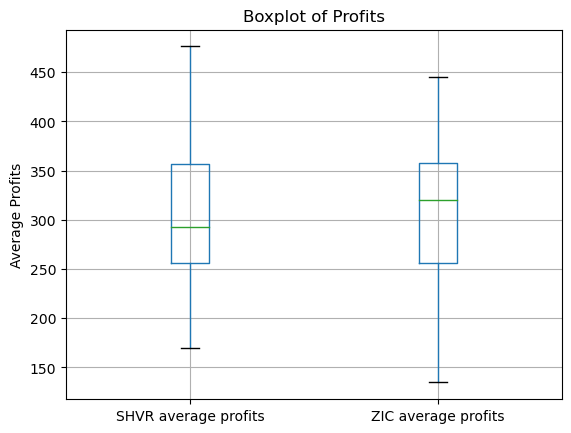

In [668]:
data_['df50_50'].boxplot(column=['SHVR average profits', 'ZIC average profits'])
plt.title('Boxplot of Profits')
plt.ylabel('Average Profits')
plt.show()

According to the box plot, we know that there is a similar range of SHVR and ZIC, and the ZIC has a higher median average profit. On the whole, ZIC has a lower extreme value than SHVR.

Secondly, we can see some basic statistics of the two data sets.

In [669]:
data_['df50_50'].describe()

SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             301.836000           311.767000
std               71.130543            71.798493
min              170.100000           134.700000
25%              255.800000           256.500000
50%              292.725000           320.700000
75%              357.025000           358.225000
max              476.250000           445.050000

We can see that ZIC has a slightly higher mean than SHVR.
They have similar standard deviation which means they have similar dispersion.
Additionally, SHVR has higher minimum and maximum profits than ZIC which can also be seen from the box plot.

Thirdly, I want to compare the two sets. 
The first thing is to determine whether the two data sets are normally distributed. I decided to draw a Q-Q plot to check the first.

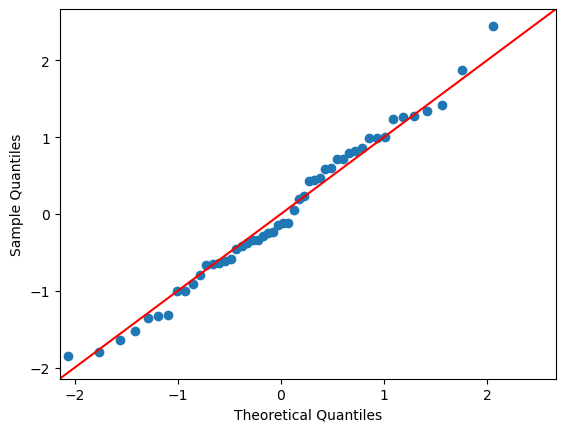

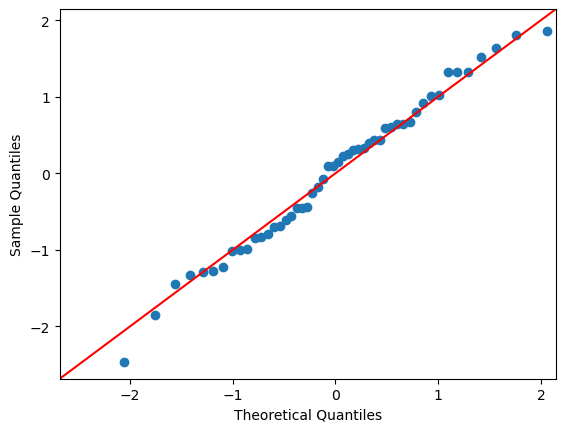

In [670]:
import statsmodels.api as sm
# normalise data
norm_x = (data_['df50_50']['SHVR average profits'] - data_['df50_50']['SHVR average profits'].mean())/data_['df50_50']['SHVR average profits'].std()
norm_y = (data_['df50_50']['ZIC average profits'] - data_['df50_50']['ZIC average profits'].mean())/data_['df50_50']['ZIC average profits'].std()
# create Q-Q plot with 45-degree line 
fig = sm.qqplot(norm_x, line='45') 
fig = sm.qqplot(norm_y, line='45')

It can be seen that both the two sets fall near the 45-degree line which means they are approximately normally distributed.
Furthermore, I use statistical tests to determine.

In [671]:
# Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution
from scipy import stats

for col in data_['df50_50'].columns:
    statistic, pvalue = stats.shapiro(data_['df50_50'][col])
    if pvalue < 0.05:
        print("strategy " + "{:}".format(col) + 
              ". We can reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is not normally distributed.")
    else:
        print("strategy " + "{:}".format(col) + 
              ". We cannot reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is normally distributed.")

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.68). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.72). Therefore, data is normally distributed.


In conclusion, we can regard the two sets as normally distributed and perform correct hypothesis testing.
Since we compare two sets of data, we can use a t-test. 
The null hypothesis is that there is no significant difference between SHVR average profits and ZIC average profits.

In [672]:
# run the test
statistic, p=stats.ttest_ind(data_['df50_50']['SHVR average profits'],data_['df50_50']['ZIC average profits'], equal_var=False)

# judge the results
if p < 0.05:
    print("Independent T-test: " + 'SHVR average profits' + "/" + 'ZIC average profits' 
          + " (p=" + "{:.3f}".format(p) + " < 0.05). " +
          "Reject null hypothesis that the two samples " + 
          "have identical average values")
else:
    print("Independent T-test: " + 'SHVR average profits' + "/" + 'ZIC average profits' + 
          " (p=" + "{:.3f}".format(p) + " > 0.05). " +
          "Cannot reject null hypothesis that the two samples " +
          "have identical average values")


Independent T-test: SHVR average profits/ZIC average profits (p=0.489 > 0.05). Cannot reject null hypothesis that the two samples have identical average values


The result shows that the p value>0.05, so we cannot reject the null hypothesis which means the samples have identical average values.

We know that the SHVR and ZIC traders have similar average profits.
There are several possible reasons. 
1. The time of our experiment was 10 minutes, which may be too short to let the strategy perform itself well.
2. Fifty trials may not be enough to find the statistical difference between the two strategies. 
3. The stochastic nature of ZIC may produce a similar action with SHVR.

In [614]:
# run N=500
run_Vernon(N=500)

In [615]:
# invoke the combine_data function to combine data
combine_data(500,'df50_500',R_percen=0.5)

# print the result
print(data_['df50_500'])   # the name 'df50_500' means R=50,N=500

     SHVR average profits  ZIC average profits
0                  430.10               183.85
1                  273.85               340.25
2                  280.25               332.65
3                  247.55               366.85
4                  290.15               323.95
..                    ...                  ...
495                319.35               295.80
496                241.50               373.65
497                315.35               298.40
498                157.75               457.40
499                327.80               285.85

[500 rows x 2 columns]


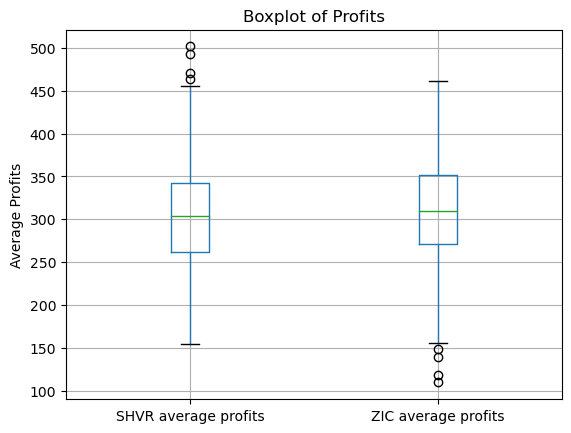

In [619]:
data_['df50_500'].boxplot(column=['SHVR average profits', 'ZIC average profits'])
plt.title('Boxplot of Profits')
plt.ylabel('Average Profits')
plt.show()

According to the box plot, we know that there is a similar range of SHVR and ZIC, and the ZIC has a higher median average profit. On the whole, SHVR has a lower extreme value than SHVR. 

In [624]:
# see some basic statistics of the two data sets
data_['df50_500'].describe()

SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             303.985900           309.608800
std               59.481136            59.906544
min              154.400000           109.550000
25%              262.350000           271.112500
50%              303.650000           309.150000
75%              342.400000           351.425000
max              501.550000           460.750000

We can see that ZIC has a slightly higher mean than SHVR.
They have similar standard deviation which means they have similar dispersion.
SHVR has higher minimum and maximum profits than ZIC.

Determine whether the two data sets are normally distributed. 
I decided to draw a Q-Q plot to check the fist.

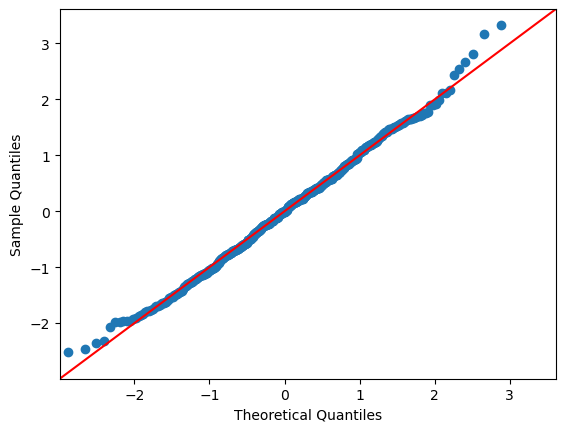

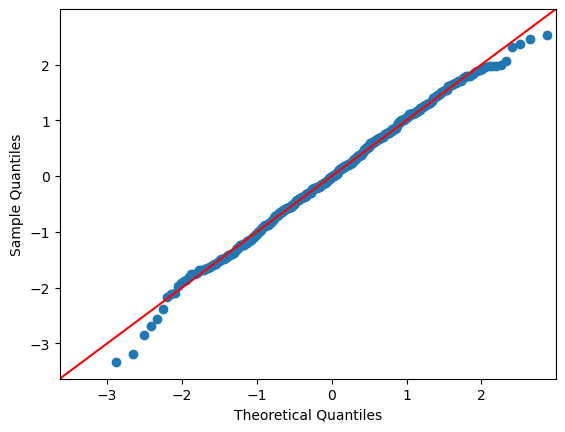

In [625]:
import statsmodels.api as sm
# normalise data
norm_x = (data_['df50_500']['SHVR average profits'] - data_['df50_500']['SHVR average profits'].mean())/data_['df50_500']['SHVR average profits'].std()
norm_y = (data_['df50_500']['ZIC average profits'] - data_['df50_500']['ZIC average profits'].mean())/data_['df50_500']['ZIC average profits'].std()
# create Q-Q plot with 45-degree line 
fig = sm.qqplot(norm_x, line='45') 
fig = sm.qqplot(norm_y, line='45')

It can be seen that both the two sets fall near the 45-degree line which means they are approximately normally distributed.
Furthermore, I use statistical test to determine.

In [626]:
# Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution
from scipy import stats

for col in data_['df50_500'].columns:
    statistic, pvalue = stats.shapiro(data_['df50_500'][col])
    if pvalue < 0.05:
        print("strategy " + "{:}".format(col) + 
              ". We can reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is not normally distributed.")
    else:
        print("strategy " + "{:}".format(col) + 
              ". We cannot reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is normally distributed.")

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.27). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.28). Therefore, data is normally distributed.


In conclusion, we can regard the two sets as normally distributed and perform correct hypothesis testing.
Since we compare two sets of data, we can use a t-test. 
The null hypothesis is that there is no significant difference between SHVR average profits and ZIC average profits.

In [627]:
# run the test
statistic, p=stats.ttest_ind(data_['df50_500']['SHVR average profits'],data_['df50_500']['ZIC average profits'], equal_var=False)

# judge the results
if p < 0.05:
    print("Independent T-test: " + 'SHVR average profits' + "/" + 'ZIC average profits' 
          + " (p=" + "{:.3f}".format(p) + " < 0.05). " +
          "Reject null hypothesis that the two samples " + 
          "have identical average values")
else:
    print("Independent T-test: " + 'SHVR average profits' + "/" + 'ZIC average profits' + 
          " (p=" + "{:.3f}".format(p) + " > 0.05). " +
          "Cannot reject null hypothesis that the two samples " +
          "have identical average values")


Independent T-test: SHVR average profits/ZIC average profits (p=0.137 > 0.05). Cannot reject null hypothesis that the two samples have identical average values


We know that the SHVR and ZIC traders have similar average profits.
There are several possible reasons. 
1. The time of our experiment was 10 minutes, which may be too short to let the strategy perform itself well.
2. The stochastic nature of ZIC may produce a similar action with SHVR.
The second reason for the experiment of N=50 is deleted, because I think N=500 is enough for us.

Part B:

In Part B, we have many R values. So we need to create a list to store these R values.

In [170]:
R_values=[10,20,30,40,60,70,80,90]
N_values=[50,500]
# use two nested loops to achieve the goal
for R in R_values:
    for N in N_values:
        run_Vernon(N=N, R_percen=R/100.0)  # invoke the run_Vernon function

In [171]:
# use another two nested loops to combine the data
for R in R_values:
    for N in N_values:
        data_name=f'df{R}_{N}'
        combine_data(N,data_name,R_percen=R/100.0) # invoke the combine_data function


The following content is about analyzing the data.

In [172]:
import statsmodels.api as sm
from scipy import stats
def ana_R(name=None):
    data_[name].boxplot(column=['SHVR average profits', 'ZIC average profits'])
    plt.title('Boxplot of Profits')
    plt.ylabel('Average Profits')
    plt.show()

# see some basic statistics of the two data sets
    data_[name].describe()


# normalise data
    norm_x = (data_[name]['SHVR average profits'] - data_[name]['SHVR average profits'].mean())/data_[name]['SHVR average profits'].std()
    norm_y = (data_[name]['ZIC average profits'] - data_[name]['ZIC average profits'].mean())/data_[name]['ZIC average profits'].std()
# create Q-Q plot with 45-degree line 
    fig = sm.qqplot(norm_x, line='45') 
    fig = sm.qqplot(norm_y, line='45')

# Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution


    for col in data_[name].columns:
        statistic, pvalue = stats.shapiro(data_[name][col])
        if pvalue < 0.05:
            print("strategy " + "{:}".format(col) + 
              ". We can reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is not normally distributed.")
        else:
            print("strategy " + "{:}".format(col) + 
              ". We cannot reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is normally distributed.")

In [558]:
# if data is normally distributed, we can use t-test
def pb_t_test(name=None):

# run the test
    statistic, p=stats.ttest_ind(data_[name]['SHVR average profits'],data_[name]['ZIC average profits'], equal_var=False)

# judge the results
    if p < 0.05:
        print("Independent T-test: " + 'SHVR average profits' + "/" + 'ZIC average profits' 
          + " (p=" + "{:.3f}".format(p) + " < 0.05). " +
          "Reject null hypothesis that the two samples " + 
          "have identical average values")
    else:
        print("Independent T-test: " + 'SHVR average profits' + "/" + 'ZIC average profits' + 
          " (p=" + "{:.3f}".format(p) + " > 0.05). " +
          "Cannot reject null hypothesis that the two samples " +
          "have identical average values")


In [559]:
# if data is not normally distributed, we can use Mann-Whitney U
def mw_test(name):
    statistic, p=stats.mannwhitneyu(data_[name]['SHVR average profits'],data_[name]['ZIC average profits'])
    # judge the results
    if p < 0.05:
        print(" Mann-Whitney U test: " +"(p=" + " {:.3f}".format(p) + " < 0.05). " +
          "Reject null hypothesis that the samples " + 
          "have identical average values."+"   so there is significant difference in average profits")
    else:
        print(" Mann-Whitney U test: " +"(p=" + " {:.3f}".format(p) + " > 0.05). " +
          "Cannot reject null hypothesis that the samples " +
          "have identical average values")


'R=10' means there are 10% traders of type SHVR and 90% traders of type ZIC.
Because we have 20 buyers and 20 sellers, so we have 2 buyers of SHVR and 18 buyers of ZIC, and 2 sellers of SHVR and 18 sellers of ZIC.
R=10, N=50:

In [560]:
print(data_['df10_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             350.475000           300.796111
std              173.233734            19.440797
min               67.250000           261.805556
25%              193.687500           289.125000
50%              364.500000           298.916667
75%              464.187500           318.409723
max              694.500000           331.583333


We can see SHVR has a higher mean than ZIC.
SHVR has a bigger standard deviation which because the different number of traders.
Fewer traders of SHVR causes high degree of uncertainty and it is sensitive to extreme values, resulting the high std.

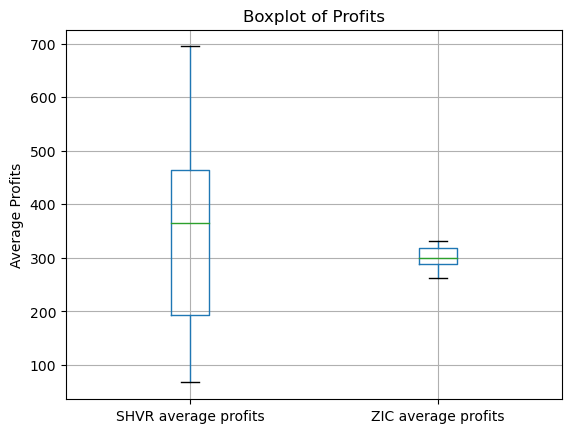

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.11). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.09). Therefore, data is normally distributed.


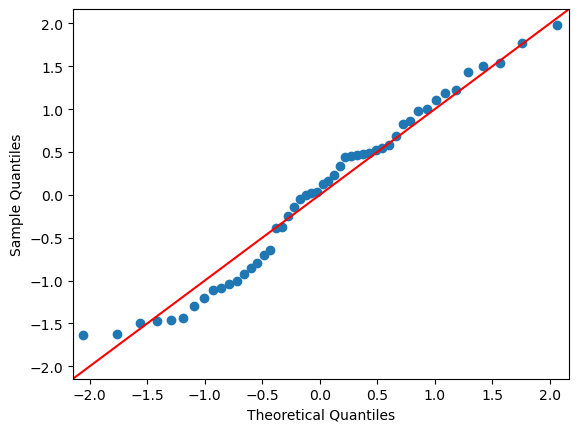

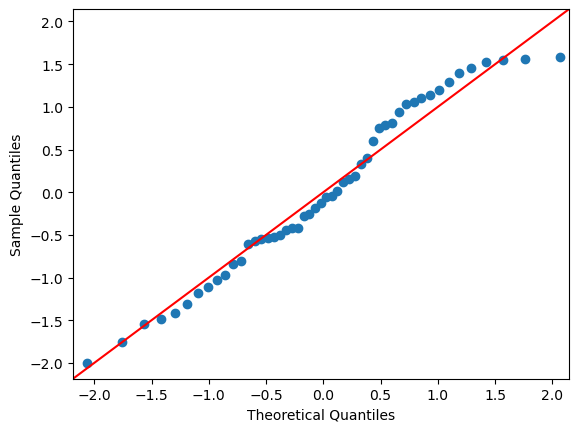

In [628]:
ana_R(name='df10_50')

In [629]:
pb_t_test(name='df10_50')

Independent T-test: SHVR average profits/ZIC average profits (p=0.049 < 0.05). Reject null hypothesis that the two samples have identical average values


R=10, N=500:

In [630]:
print(data_['df10_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             327.676000           303.311167
std              171.571704            19.223942
min               44.000000           249.861111
25%              182.687500           290.486111
50%              323.375000           303.319445
75%              439.062500           319.638889
max              802.000000           335.333333


We can see SHVR has a higher mean than ZIC.
SHVR has a bigger standard deviation, the reason is same as 'N=50'.

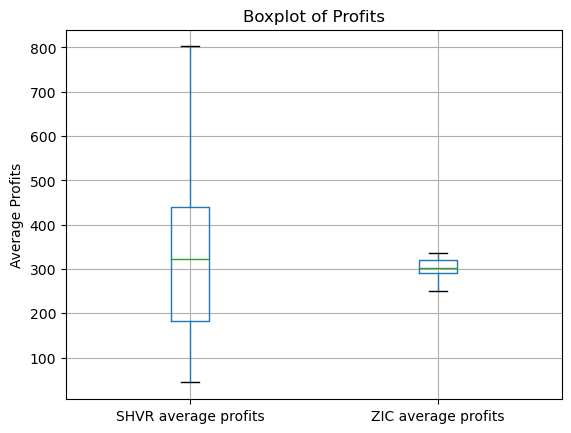

strategy SHVR average profits. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIC average profits. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.


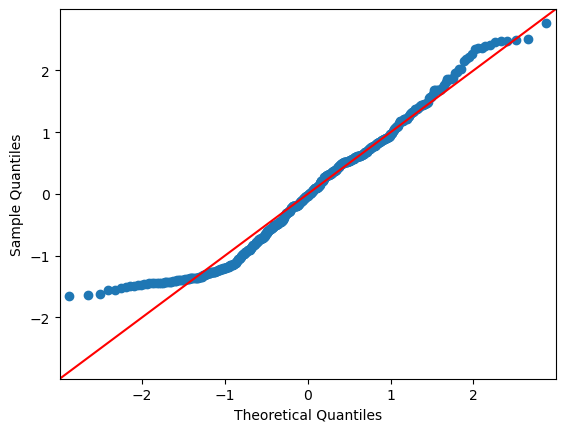

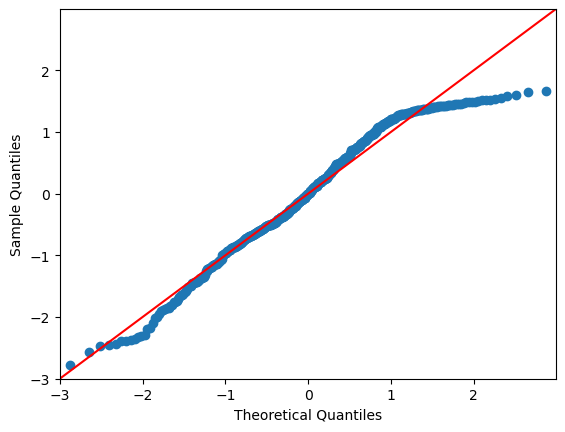

In [631]:
ana_R(name='df10_500')

In [632]:
mw_test('df10_500')

 Mann-Whitney U test: (p= 0.023 < 0.05). Reject null hypothesis that the samples have identical average values.   so there is significant difference in average profits


Then, we can compare the median value of the two strategies to find which strategy has the greater profit.
Since SHVR has a higher median than ZIC. 
So, SHVR is statistically more profitable than ZIC.

R=20, N=50:

In [633]:
print(data_['df20_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             292.465000           309.311875
std              104.171188            26.094483
min               88.500000           248.187500
25%              221.062500           297.117188
50%              289.312500           310.125000
75%              338.468750           327.679688
max              541.000000           361.468750


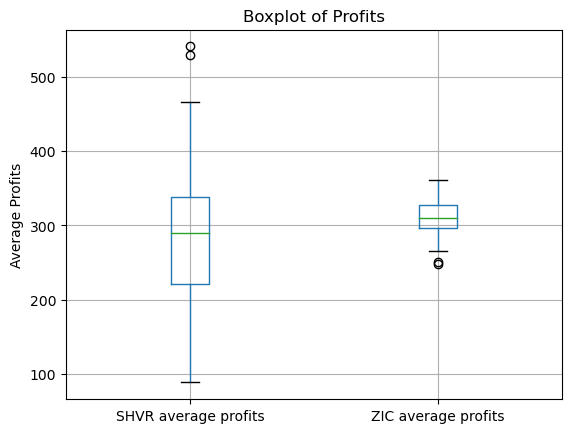

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.35). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.35). Therefore, data is normally distributed.


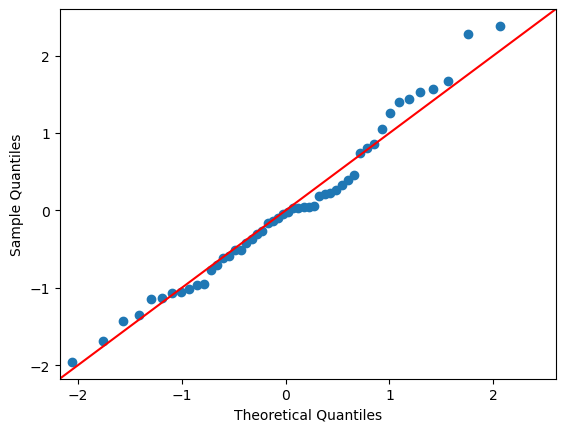

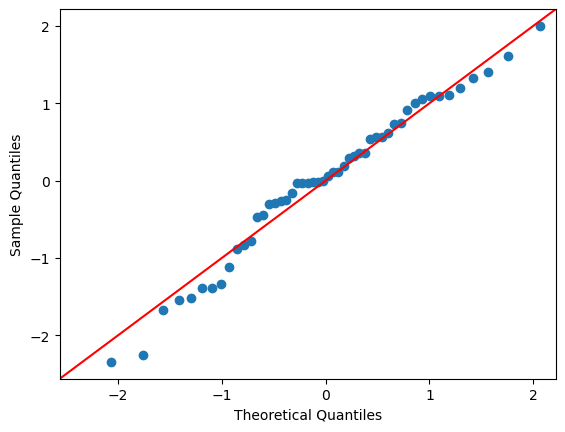

In [634]:
ana_R(name='df20_50')

In [635]:
pb_t_test(name='df20_50')

Independent T-test: SHVR average profits/ZIC average profits (p=0.272 > 0.05). Cannot reject null hypothesis that the two samples have identical average values


R=20, N=500:

In [636]:
print(data_['df20_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             327.001250           300.667750
std              108.686226            27.337368
min               58.125000           216.281250
25%              251.187500           282.304688
50%              328.125000           300.640625
75%              400.281250           318.890625
max              659.750000           368.031250


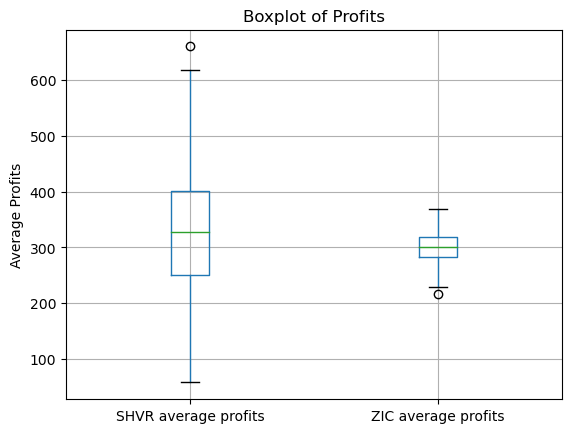

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.35). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.32). Therefore, data is normally distributed.


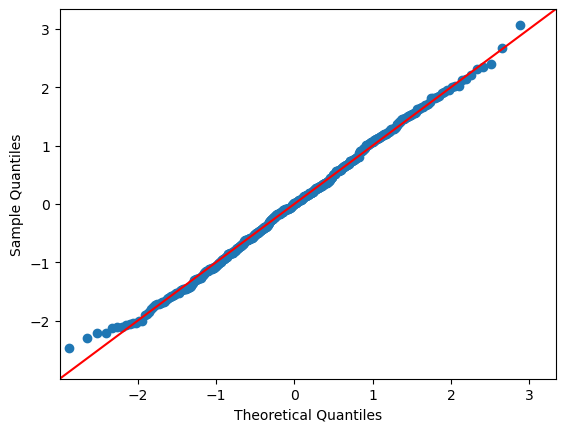

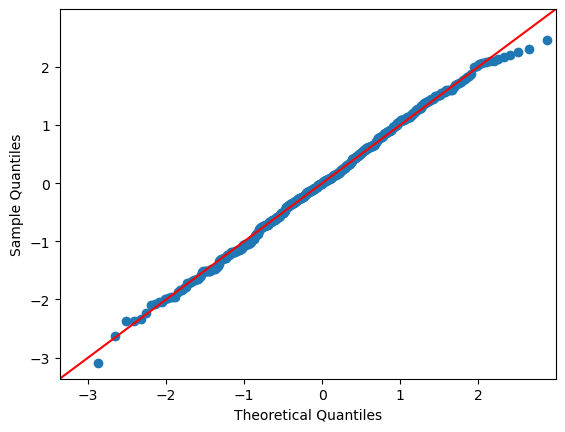

In [637]:
ana_R(name='df20_500')

In [571]:
mw_test('df20_500')

 Mann-Whitney U test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.   so there is significant difference in average profits


Since SHVR has a higher median than ZIC. 
So, SHVR is statistically more profitable than ZIC.

R=30,N=50:

In [572]:
print(data_['df30_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             326.375000           297.196429
std               79.213397            34.413826
min              133.083333           218.071429
25%              268.937500           274.125000
50%              328.166667           295.714286
75%              382.041667           322.741071
max              511.666667           378.357143


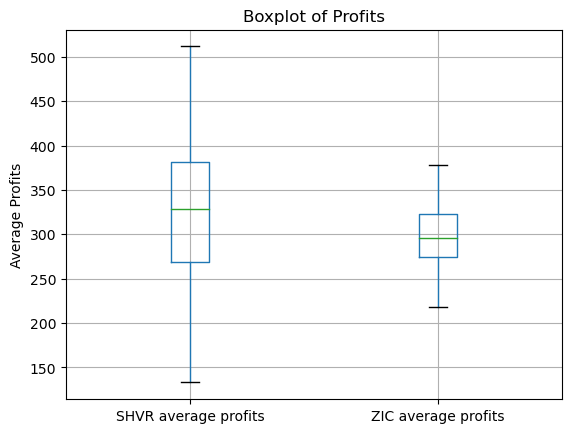

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.93). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.92). Therefore, data is normally distributed.


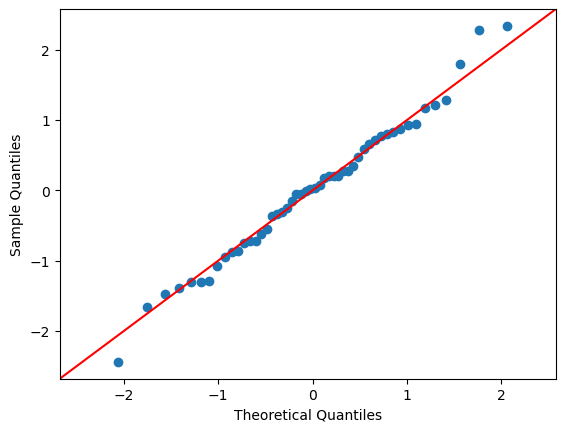

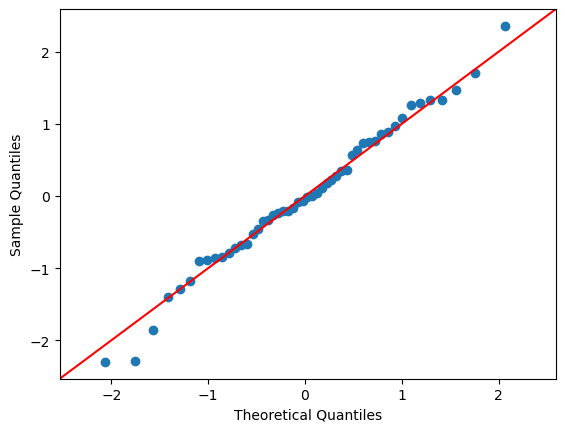

In [573]:
ana_R(name='df30_50')

In [574]:
pb_t_test(name='df30_50')

Independent T-test: SHVR average profits/ZIC average profits (p=0.020 < 0.05). Reject null hypothesis that the two samples have identical average values


R=30,N=500:

In [575]:
print(data_['df30_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             313.194833           303.107286
std               83.946926            36.195234
min              110.166667           202.535714
25%              247.958333           277.133928
50%              312.833333           303.285714
75%              374.041667           331.258929
max              547.083333           390.571429


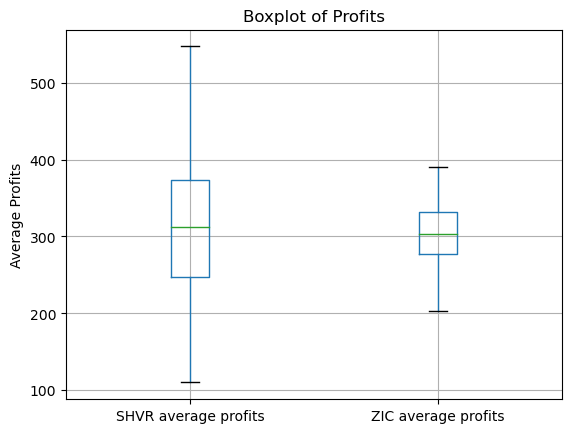

strategy SHVR average profits. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.
strategy ZIC average profits. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.


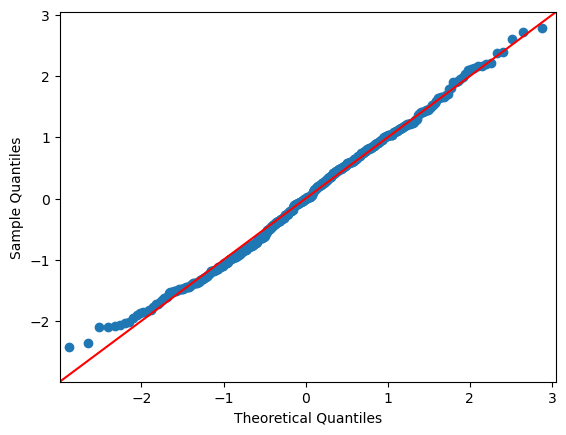

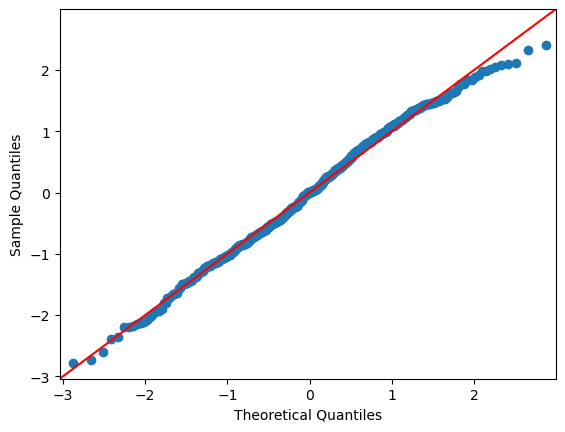

In [576]:
ana_R(name='df30_500')

In [577]:
mw_test('df30_500')

 Mann-Whitney U test: (p= 0.026 < 0.05). Reject null hypothesis that the samples have identical average values.   so there is significant difference in average profits


Since SHVR has a higher median than ZIC. 
So, SHVR is statistically more profitable than ZIC.

R=40,N=50:

In [638]:
print(data_['df40_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             310.772500           303.605833
std               77.592684            52.092612
min              149.062500           178.333333
25%              252.406250           271.458333
50%              308.593750           305.333333
75%              357.437500           343.666667
max              498.812500           412.500000


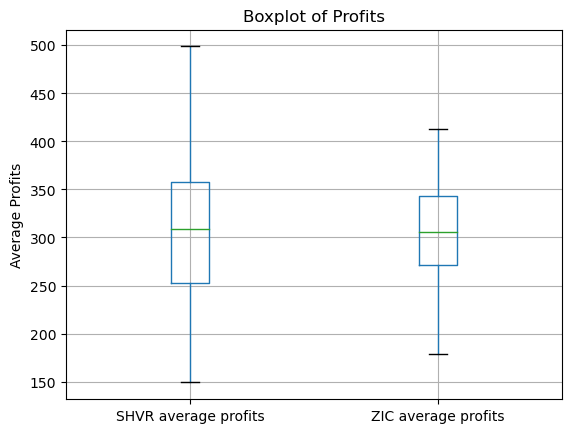

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.97). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.96). Therefore, data is normally distributed.


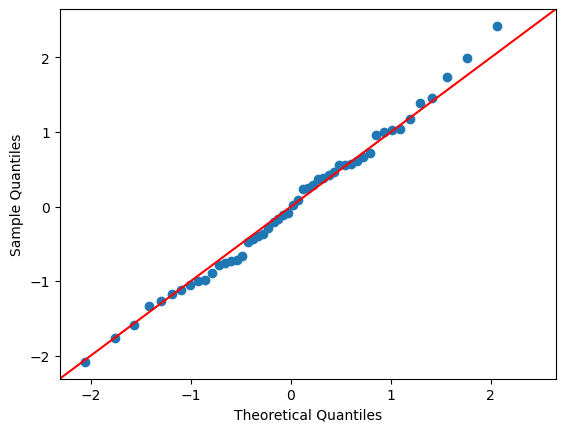

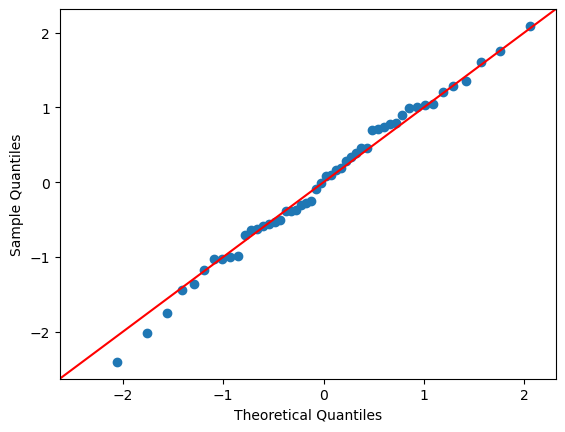

In [639]:
ana_R(name='df40_50')

In [640]:
pb_t_test(name='df40_50')

Independent T-test: SHVR average profits/ZIC average profits (p=0.589 > 0.05). Cannot reject null hypothesis that the two samples have identical average values


R=40,N=500:

In [641]:
print(data_['df40_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             310.477500           303.805500
std               71.750396            48.140692
min              106.187500           155.500000
25%              258.390625           271.250000
50%              307.375000           305.416667
75%              358.562500           338.687500
max              532.500000           438.791667


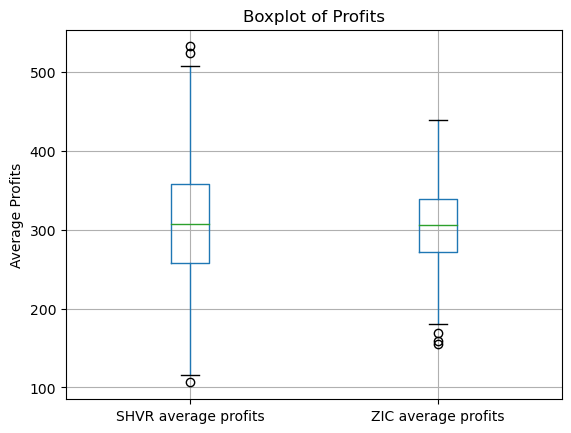

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.07). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.07). Therefore, data is normally distributed.


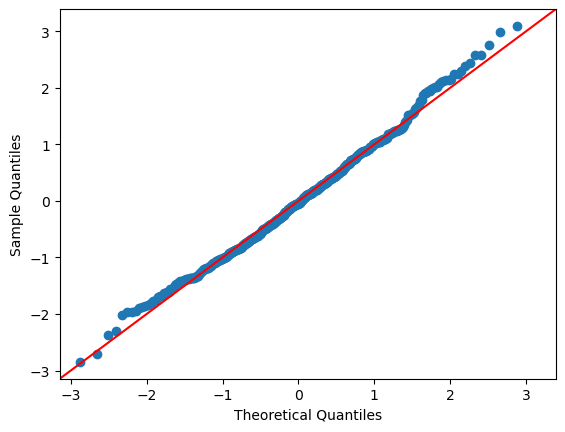

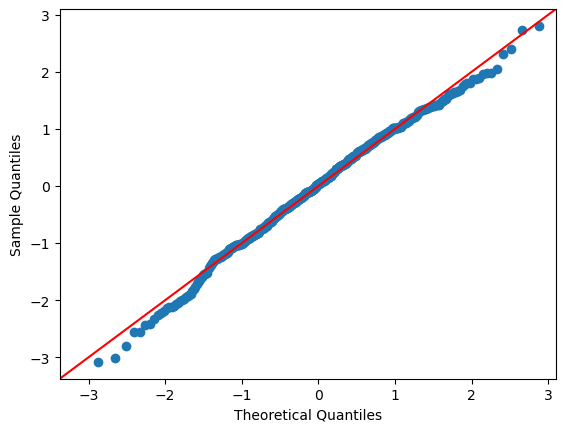

In [642]:
ana_R(name='df40_500')

In [643]:
pb_t_test(name='df40_500')

Independent T-test: SHVR average profits/ZIC average profits (p=0.085 > 0.05). Cannot reject null hypothesis that the two samples have identical average values


R=60,N=50:

In [644]:
print(data_['df60_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             311.863333           299.577500
std               48.549430            73.236212
min              189.166667           132.812500
25%              277.958333           243.437500
50%              318.312500           289.281250
75%              348.552083           350.421875
max              423.083333           485.187500


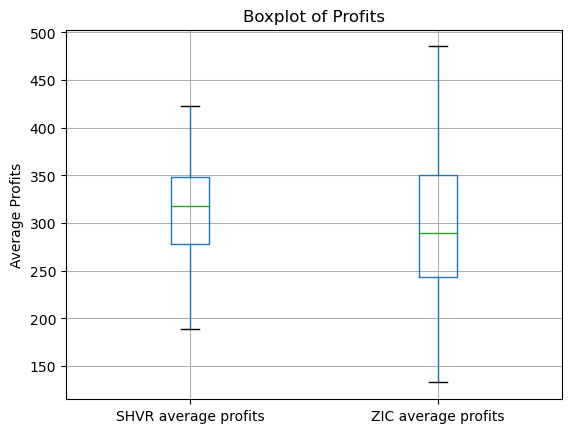

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.69). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.67). Therefore, data is normally distributed.


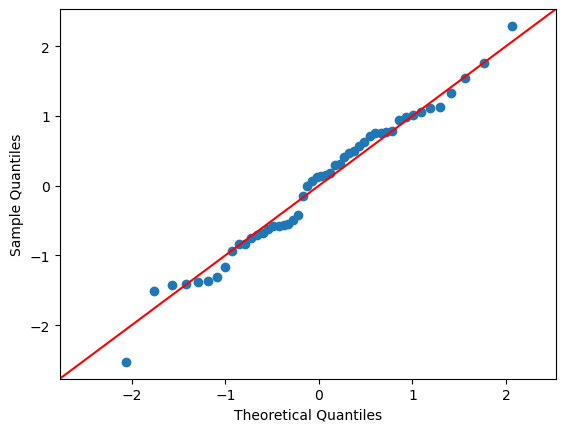

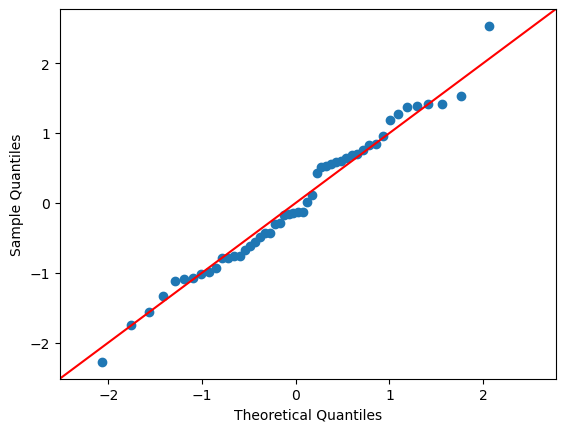

In [645]:
ana_R(name='df60_50')

In [646]:
pb_t_test(name='df60_50')

Independent T-test: SHVR average profits/ZIC average profits (p=0.326 > 0.05). Cannot reject null hypothesis that the two samples have identical average values


R=60,N=500:

In [647]:
print(data_['df60_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             308.814667           304.175625
std               48.807265            73.614593
min              179.125000            73.812500
25%              275.541667           253.218750
50%              306.083333           308.343750
75%              341.385417           354.640625
max              462.416667           498.562500


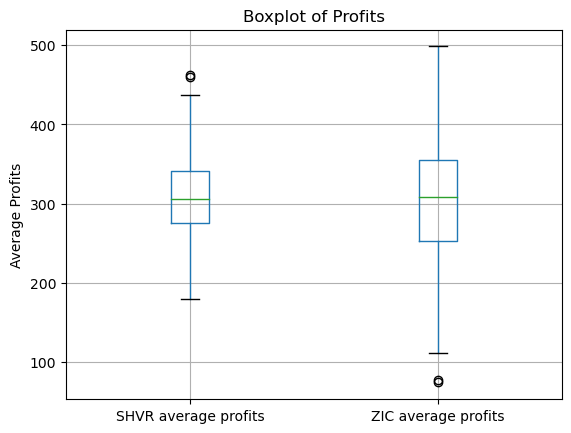

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.34). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.33). Therefore, data is normally distributed.


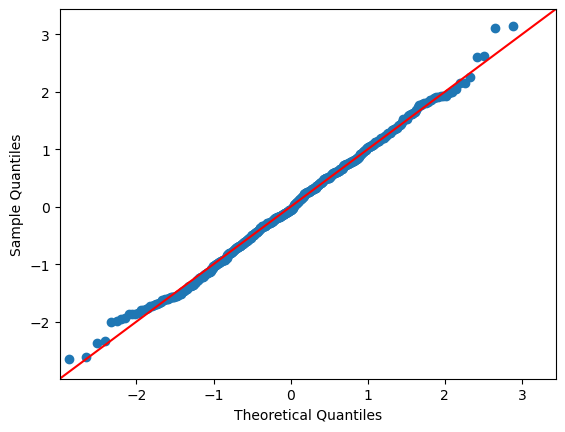

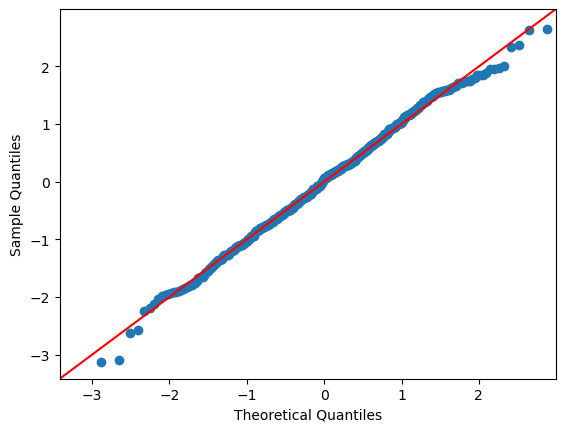

In [648]:
ana_R(name='df60_500')

In [649]:
pb_t_test(name='df60_500')

Independent T-test: SHVR average profits/ZIC average profits (p=0.241 > 0.05). Cannot reject null hypothesis that the two samples have identical average values


R=70,N=50:

In [650]:
print(data_['df70_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             305.193571           312.196667
std               37.423249            87.516522
min              227.821429            62.416667
25%              273.750000           243.333333
50%              303.571429           314.041667
75%              334.946429           384.750000
max              411.785714           493.666667


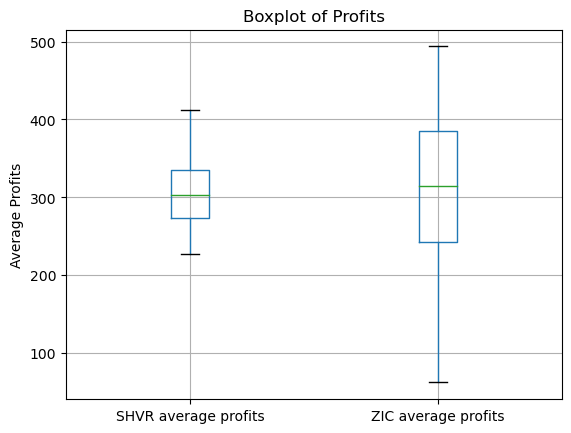

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.30). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.28). Therefore, data is normally distributed.


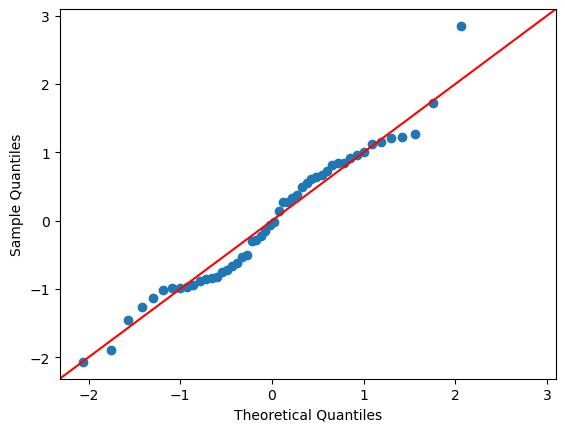

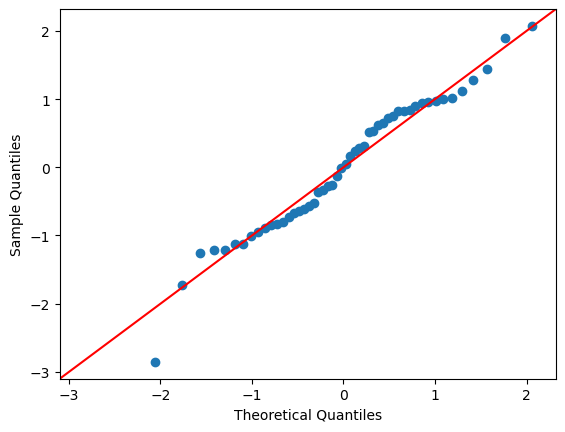

In [651]:
ana_R(name='df70_50')

In [652]:
pb_t_test(name='df70_50')

Independent T-test: SHVR average profits/ZIC average profits (p=0.605 > 0.05). Cannot reject null hypothesis that the two samples have identical average values


R=70,N=500:

In [653]:
print(data_['df70_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             304.811143           313.121500
std               40.521329            94.943266
min              179.678571            51.500000
25%              276.267857           251.395833
50%              304.535715           314.000000
75%              331.276786           380.145833
max              416.571429           606.000000


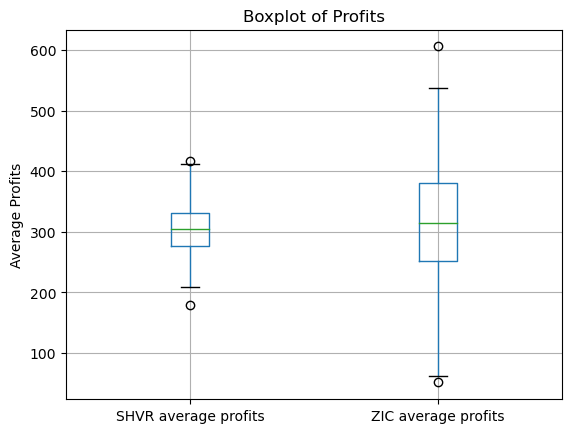

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.13). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.13). Therefore, data is normally distributed.


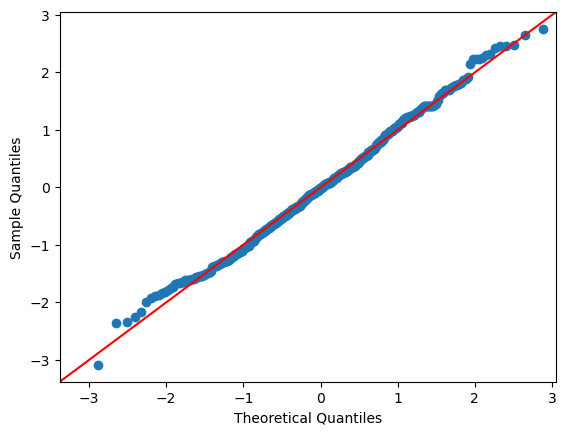

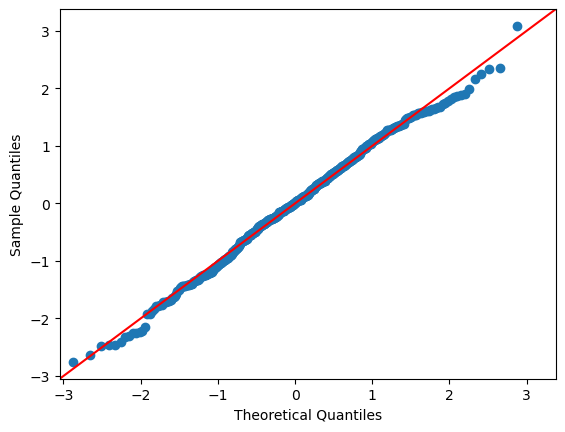

In [654]:
ana_R(name='df70_500')

In [655]:
pb_t_test(name='df70_500')

Independent T-test: SHVR average profits/ZIC average profits (p=0.072 > 0.05). Cannot reject null hypothesis that the two samples have identical average values


R=80,N=50:

In [656]:
print(data_['df80_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             314.017500           281.457500
std               30.494852           121.871489
min              253.468750            16.875000
25%              291.914062           199.781250
50%              313.156250           285.250000
75%              334.523438           370.218750
max              380.250000           524.000000


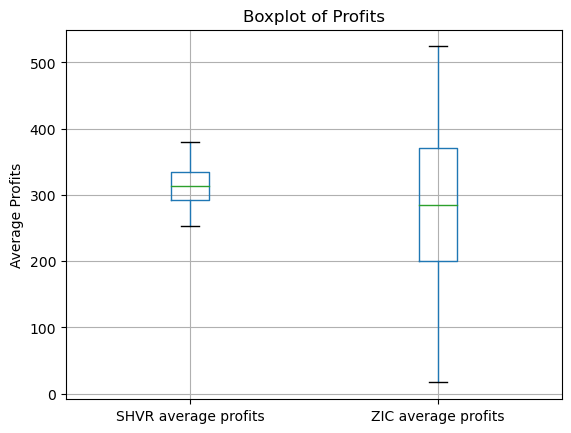

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.47). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.46). Therefore, data is normally distributed.


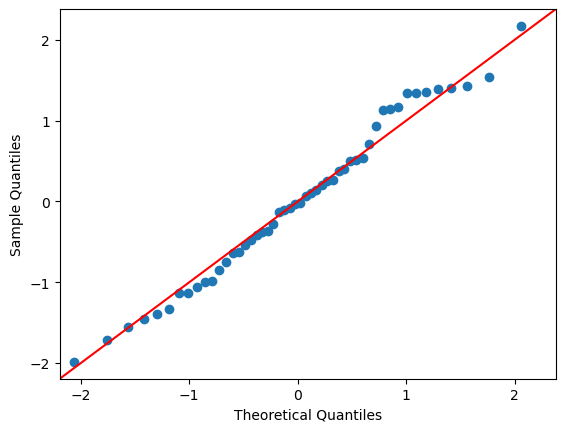

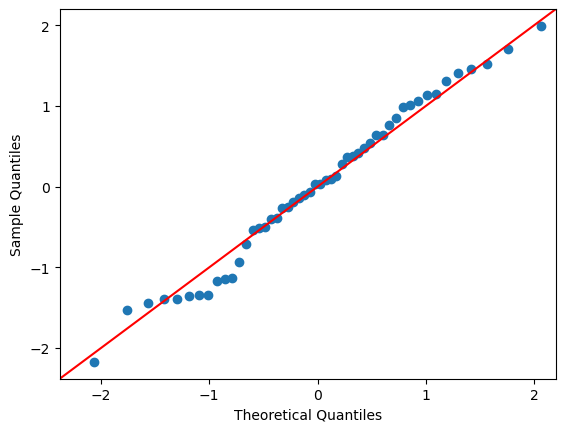

In [657]:
ana_R(name='df80_50')

In [658]:
pb_t_test(name='df80_50')

Independent T-test: SHVR average profits/ZIC average profits (p=0.072 > 0.05). Cannot reject null hypothesis that the two samples have identical average values


R=80,N=500:

In [659]:
print(data_['df80_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             305.015562           317.181000
std               32.101196           128.689479
min              205.593750             0.000000
25%              283.304688           229.781250
50%              303.234375           324.062500
75%              326.796875           404.406250
max              384.468750           715.500000


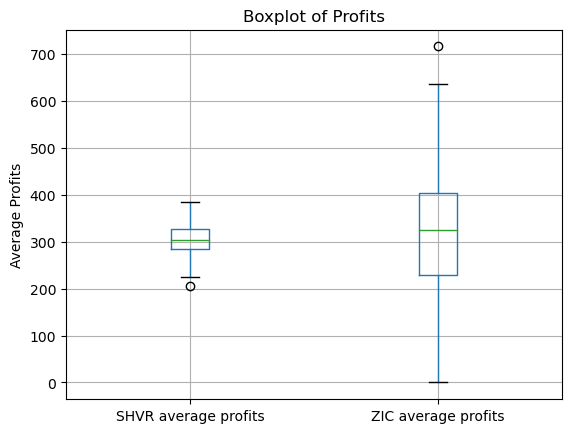

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.24). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.23). Therefore, data is normally distributed.


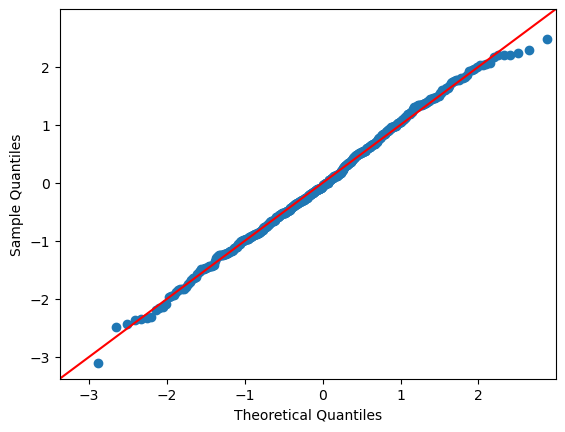

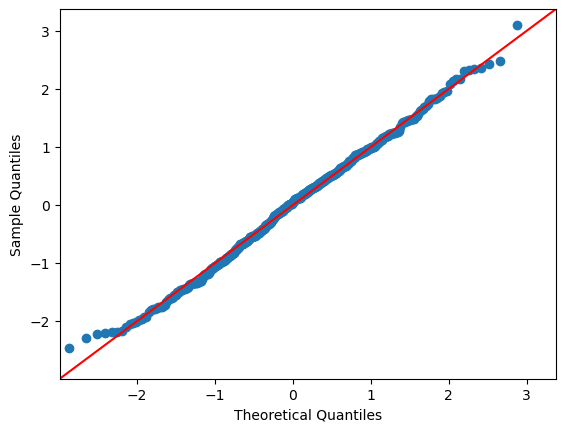

In [660]:
ana_R(name='df80_500')

In [661]:
pb_t_test(name='df80_500')

Independent T-test: SHVR average profits/ZIC average profits (p=0.041 < 0.05). Reject null hypothesis that the two samples have identical average values


Since ZIC has a higher median than SHVR. 
So, ZIC is statistically more profitable than SHVR.

R=90,N=50:

In [662]:
print(data_['df90_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             309.012778           294.035000
std               19.779096           178.594534
min              273.722222             0.000000
25%              292.027778           153.625000
50%              307.888889           304.000000
75%              324.680555           447.500000
max              341.750000           612.250000


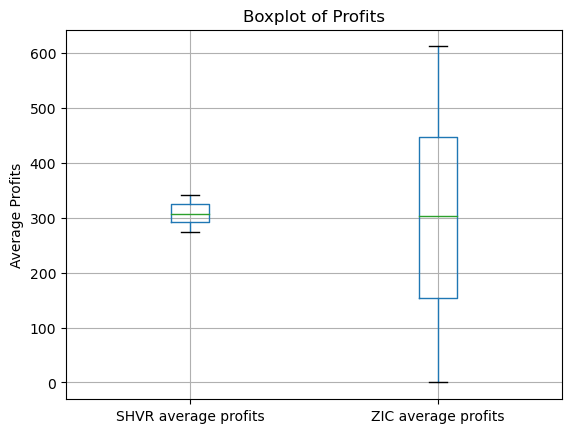

strategy SHVR average profits. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.
strategy ZIC average profits. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.


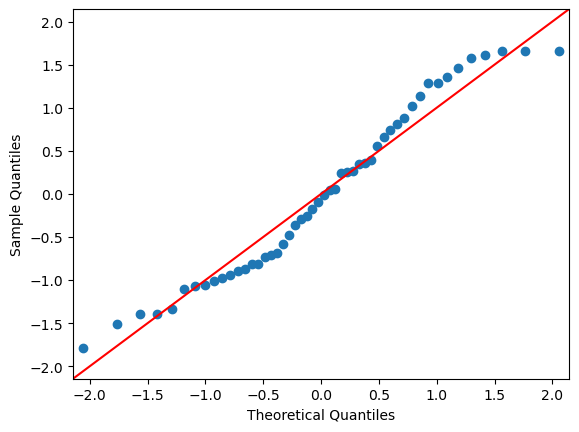

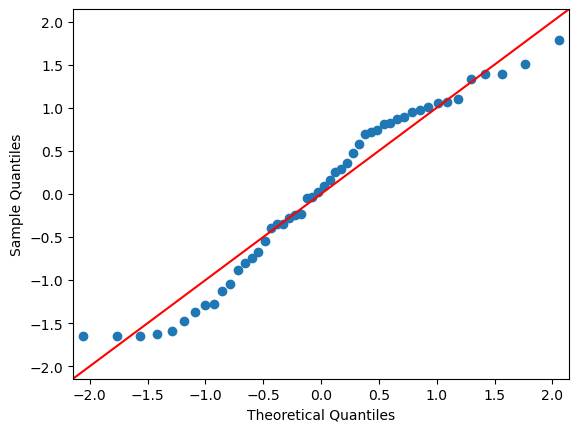

In [663]:
ana_R(name='df90_50')

In [664]:
mw_test('df90_50')

 Mann-Whitney U test: (p= 0.937 > 0.05). Cannot reject null hypothesis that the samples have identical average values


R=90,N=500:

In [665]:
print(data_['df90_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             306.515500           316.397000
std               20.676376           186.667169
min              259.583333             0.000000
25%              292.472223           167.937500
50%              306.263889           318.500000
75%              322.909722           443.500000
max              341.750000           739.500000


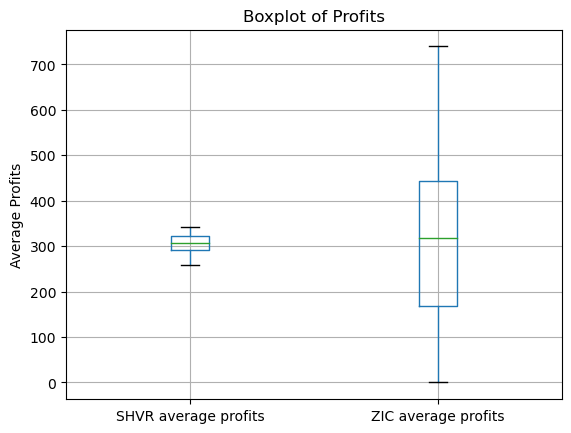

strategy SHVR average profits. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIC average profits. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.


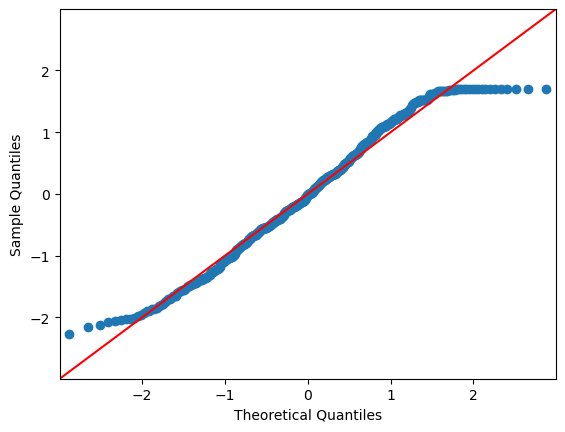

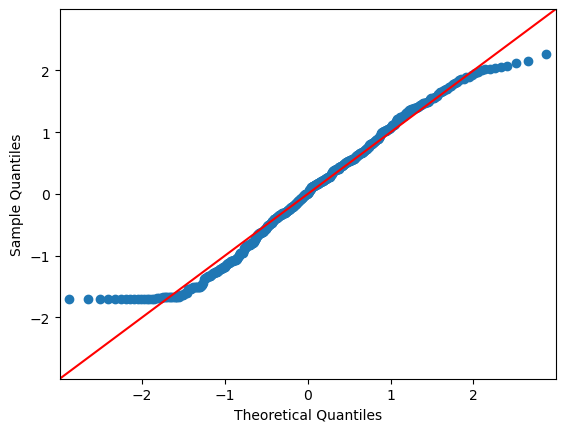

In [666]:
ana_R(name='df90_500')

In [667]:
mw_test('df90_500')

 Mann-Whitney U test: (p= 0.155 > 0.05). Cannot reject null hypothesis that the samples have identical average values


Part C:

In [608]:
# create run_Vernon_four function to run the new experiment
def run_Vernon_four(N=1,end_time=60*10,ratios=None,num=1):
    start_time=0
    end_time=60*10
    # the supply curve is a horizontal line of P=310 and the demand curve is a sloping line from 490 to 250
    supply=(310,310)
    demand=(490,250)

    supply_schedule=[{'from': start_time, 'to': end_time, 'ranges': [supply], 'stepmode': 'fixed'}]
    demand_schedule=[{'from': start_time, 'to': end_time, 'ranges': [demand], 'stepmode': 'fixed'}]
  
    order_interval=60

    order_sched={'sup': supply_schedule, 'dem': demand_schedule,
                'interval': order_interval, 'timemode': 'periodic'}

    num_of_traders=20 
    SHVR_num=int(ratios[0]*num_of_traders)
    GVWY_num=int(ratios[1]*num_of_traders)
    ZIC_num=int(ratios[2]*num_of_traders)
    ZIP_num=int(ratios[3]*num_of_traders)
    sellers_spec=[('SHVR',SHVR_num),('GVWY',GVWY_num),('ZIC', ZIC_num),('ZIP',ZIP_num)]
    buyers_spec=sellers_spec
    traders_spec={'sellers':sellers_spec,'buyers':buyers_spec}
   
    # we are only interested in average profits per trader. We set all other flags to False.
    dump_flags={'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
              'dump_avgbals': True, 'dump_tape': False}

    # run N trials of this experiment configuration

    for i in range(N):
        trial_id=str(i)+'pc'+'_'+str(num)+'_'+str(N)
        verbose=False 
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)




# define all required ratios
ratios_all=[
    [0.25, 0.25, 0.25, 0.25], # num=1
    [0.4, 0.2, 0.2, 0.2],     # num=2
    [0.2, 0.4, 0.2, 0.2],     # num=3
    [0.2, 0.2, 0.4, 0.2],     # num=4
    [0.2, 0.2, 0.2, 0.4],     # num=5
    [0.1, 0.3, 0.3, 0.3],     # num=6
    [0.3, 0.1, 0.3, 0.3],     # num=7
    [0.3, 0.3, 0.1, 0.3],     # num=8
    [0.3, 0.3, 0.3, 0.1],     # num=9
    [0.7, 0.1, 0.1, 0.1],     # num=10
    [0.1, 0.7, 0.1, 0.1],     # num=11
    [0.1, 0.1, 0.7, 0.1],     # num=12
    [0.1, 0.1, 0.1, 0.7]      # num=13
]


In [609]:
# run 'N=50'
i_num=1
for r in ratios_all:
    run_Vernon_four(N=50,end_time=60*10,ratios=r,num=i_num)
    i_num+=1


In [323]:
def pc_combine_data(N,data_name,num): 
    C_folder_path='/Users/guzhemeimao/Downloads/'
    C_file_paths=glob.glob(C_folder_path+f'*pc_{num}_{N}_avg_balance.csv')
    
    GVWY_values=[]
    # get the last row
    for C_file_path in C_file_paths: 
        C_df = pd.read_csv(C_file_path)
        last_row=C_df.dropna().tail(1)
        if not last_row.empty:
            GVWY_value=last_row.iloc[0,7]  
            
        # check if the value is numeric before appending
            if pd.notna(GVWY_value) and pd.to_numeric(GVWY_value, errors='coerce')==GVWY_value:
                GVWY_values.append(GVWY_value)
  
 # repeat the process to get the useful data of SHVR, ZIC, ZIP
    SHVR_values=[]
    # get the last row
    for C_file_path in C_file_paths: 
            C_df = pd.read_csv(C_file_path)
            last_row=C_df.dropna().tail(1)
            if not last_row.empty:
                SHVR_value=last_row.iloc[0,11]  
            
        # check if the value is numeric before appending
                if pd.notna(SHVR_value) and pd.to_numeric(SHVR_value, errors='coerce')==SHVR_value:
                    SHVR_values.append(SHVR_value)
    ZIC_values=[]
    for C_file_path in C_file_paths: 
            C_df = pd.read_csv(C_file_path)
            last_row=C_df.dropna().tail(1)
            if not last_row.empty:
                ZIC_value=last_row.iloc[0,15]
       
                if pd.notna(ZIC_value) and pd.to_numeric(ZIC_value, errors='coerce')==ZIC_value:
                     ZIC_values.append(ZIC_value)
    ZIP_values=[]
    for C_file_path in C_file_paths:  
            C_df = pd.read_csv(C_file_path)
            last_row=C_df.dropna().tail(1)
            if not last_row.empty:
                ZIP_value=last_row.iloc[0,19]
       
                if pd.notna(ZIP_value) and pd.to_numeric(ZIP_value, errors='coerce')==ZIP_value:
                    ZIP_values.append(ZIP_value)
# convert the list to some new DataFrame
    df1=pd.DataFrame({'GVWY': GVWY_values})
    df2=pd.DataFrame({'SHVR': SHVR_values})  
    df3=pd.DataFrame({'ZIC': ZIC_values})
    df4=pd.DataFrame({'ZIP': ZIP_values})
# combine the df1, df2, df3, df4 into df
    df=pd.concat([df1, df2, df3, df4], axis=1)

    data_C[data_name]=df

    

# create a empty dictionary to store the name
data_c={}

In [324]:
# create a function to visualize and analyse
def pc_ana(data_name='C_df_1'):
    data_C[data_name].boxplot(column=['GVWY','SHVR', 'ZIC','ZIP'])
    plt.title('Boxplot of Profits')
    plt.ylabel('Average Profits')
    plt.show()

# normalise data
    norm_1 = (data_C[data_name]['GVWY'] - data_C[data_name]['GVWY'].mean())/data_C[data_name]['GVWY'].std()
    norm_2 = (data_C[data_name]['SHVR'] - data_C[data_name]['SHVR'].mean())/data_C[data_name]['SHVR'].std()
    norm_3 = (data_C[data_name]['ZIC'] - data_C[data_name]['ZIC'].mean())/data_C[data_name]['ZIC'].std()
    norm_4 = (data_C[data_name]['ZIP'] - data_C[data_name]['ZIP'].mean())/data_C[data_name]['ZIP'].std()
# create Q-Q plot with 45-degree line 
    fig = sm.qqplot(norm_1, line='45') 
    fig = sm.qqplot(norm_2, line='45')
    fig = sm.qqplot(norm_3, line='45') 
    fig = sm.qqplot(norm_4, line='45')
# Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution


    for col in data_C[data_name].columns:
        statistic, pvalue = stats.shapiro(data_C[data_name][col])
        if pvalue < 0.05:
            print("strategy " + "{:}".format(col) + 
              ". We can reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is not normally distributed.")
        else:
            print("strategy " + "{:}".format(col) + 
              ". We cannot reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is normally distributed.")
    

visualization and test: ANOVA is designed to compare multiple distributions, so we use ANOVA when data is normally distributed. When data is not normally distributed, we use Kruskal-Wallis.

In [325]:
def anova(data_name):
    statistic, pvalue = stats.f_oneway(data_C[data_name]['GVWY'],data_C[data_name]['SHVR'],data_C[data_name]['ZIC'],data_C[data_name]['ZIP'])
    if pvalue < 0.05:
        print("ANOVA: (p=" + "{:.2f}".format(pvalue) + 
          " < 0.05). Reject null. The groups have a " +
          "different population mean.") 
    else:
        print("ANOVA: (p=" + "{:.2f}".format(pvalue) + 
          " > 0.05). Cannot reject null hypothesis " + 
          "that groups have same population mean.")

In [387]:
def kw(data_name):
    statistic, pvalue = stats.kruskal(data_C[data_name]['GVWY'],data_C[data_name]['SHVR'],data_C[data_name]['ZIC'],data_C[data_name]['ZIP'])
    
    # judge the results
    if pvalue < 0.05:
        print("Kruskal-Wallis  test: " +"(p=" + " {:.3f}".format(pvalue) + " < 0.05). " +
          "Reject null hypothesis that the samples " + 
          "have identical average values."+"     so there is significant difference in profits")
    else:
        print("Kruskal-Wallis  test: " +"(p=" + " {:.3f}".format(pvalue) + " > 0.05). " +
          "Cannot reject null hypothesis that the samples " +
          "have identical average values")

[0.25, 0.25, 0.25, 0.25]:


In [327]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_1',1)  # num='1'indicate the ratio of (25:25:25:25)

In [388]:
# see some basic statistics of the data sets
data_C['C_df_1'].describe()

GVWY       SHVR         ZIC         ZIP
count   50.000000   50.00000   50.000000   50.000000
mean   310.412000  285.91600  309.890000  320.026000
std     99.895361   97.38879  103.846479   98.306708
min     87.400000   97.10000  129.000000  104.100000
25%    247.300000  233.47500  228.950000  234.425000
50%    315.450000  282.25000  341.600000  321.100000
75%    377.500000  328.45000  398.475000  387.650000
max    516.600000  577.90000  507.700000  549.200000

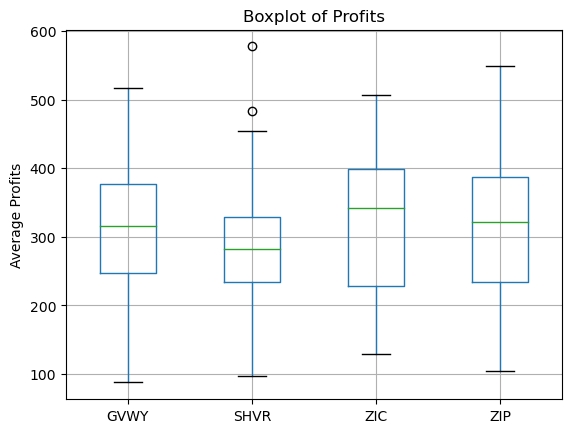

strategy GVWY. We cannot reject the null hypothesis (p=0.72). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.54). Therefore, data is normally distributed.
strategy ZIC. We can reject the null hypothesis (p=0.02). Therefore, data is not normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.93). Therefore, data is normally distributed.


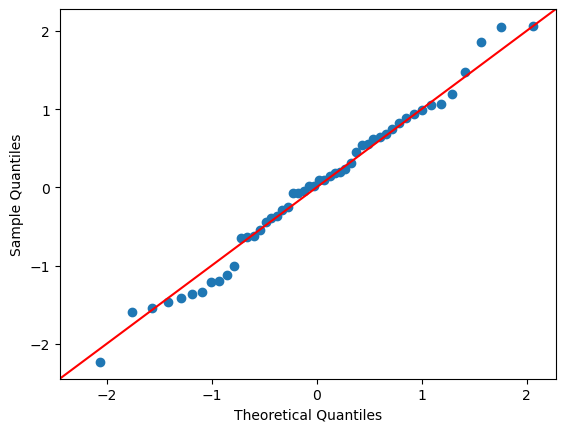

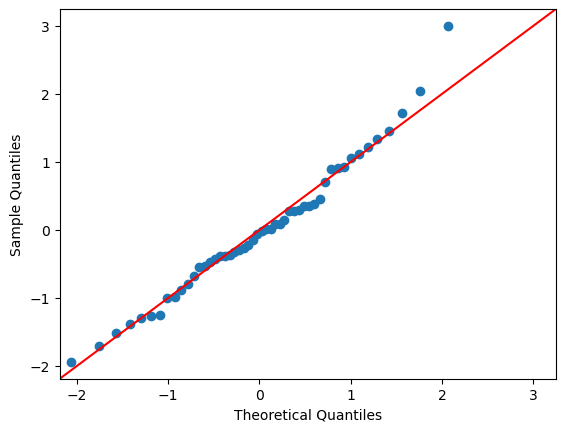

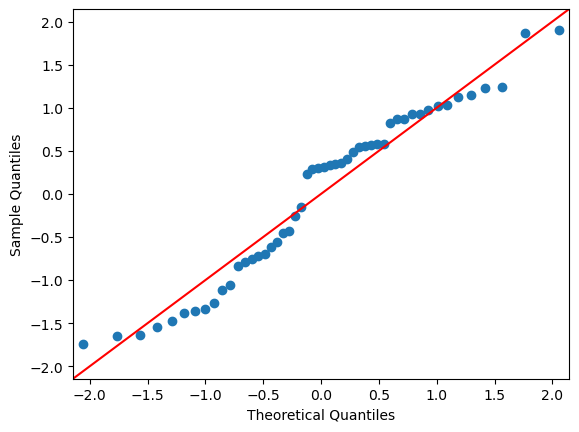

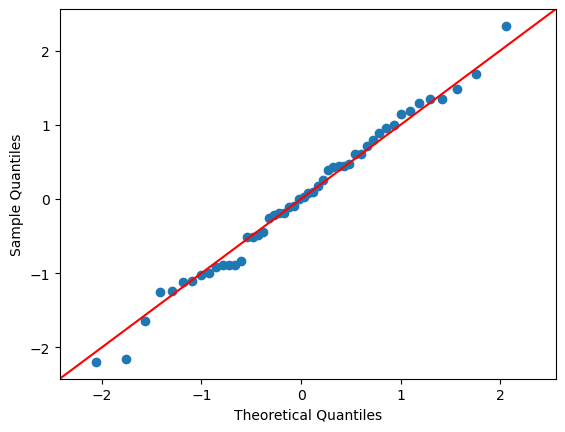

In [389]:
pc_ana('C_df_1')

In [390]:
kw('C_df_1')

Kruskal-Wallis  test: (p= 0.293 > 0.05). Cannot reject null hypothesis that the samples have identical average values


[0.4, 0.2, 0.2, 0.2]     # num=2

In [391]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_2',2)  

In [392]:
# see some basic statistics of the data sets
data_C['C_df_2'].describe()

GVWY        SHVR         ZIC         ZIP
count   50.000000   50.000000   50.000000   50.000000
mean   282.840000  294.068750  334.012500  330.310000
std     91.077619   70.965066  110.645959  113.259712
min     96.625000  145.812500   88.375000   97.875000
25%    208.375000  253.437500  254.937500  260.062500
50%    295.062500  283.687500  352.875000  339.937500
75%    336.093750  332.750000  424.656250  403.656250
max    503.625000  447.312500  534.000000  606.500000

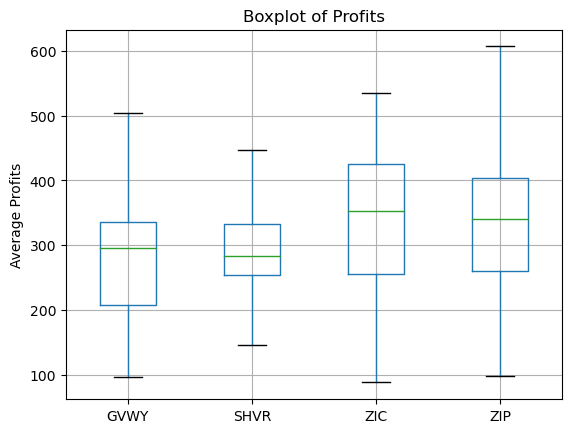

strategy GVWY. We cannot reject the null hypothesis (p=0.82). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.36). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.41). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.93). Therefore, data is normally distributed.


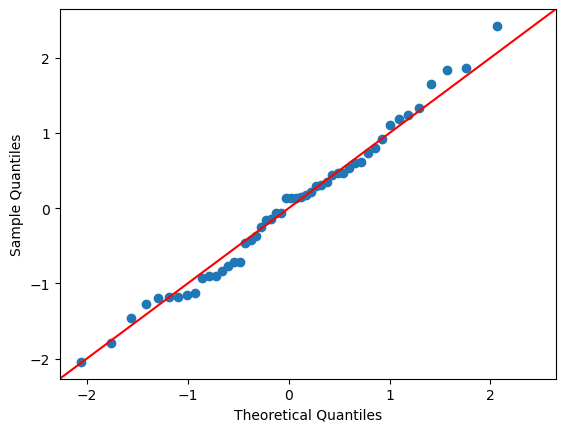

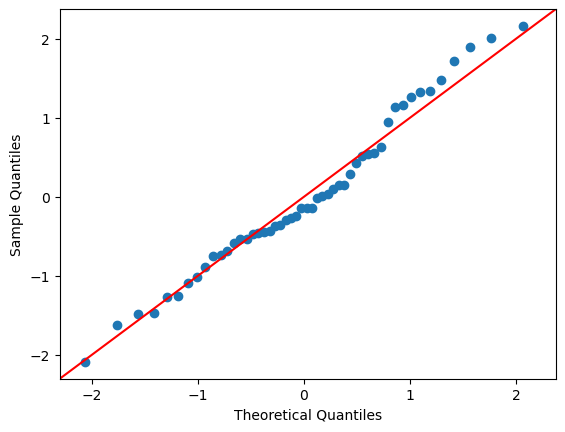

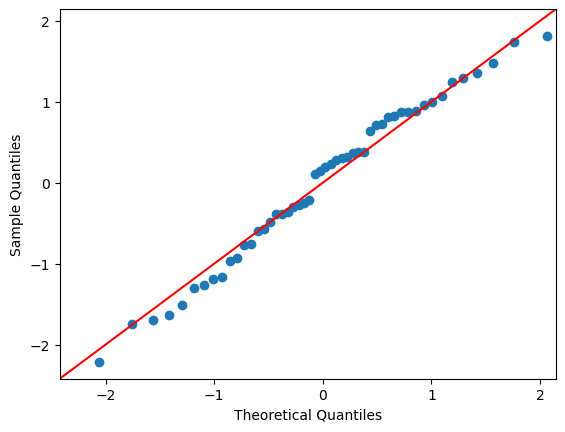

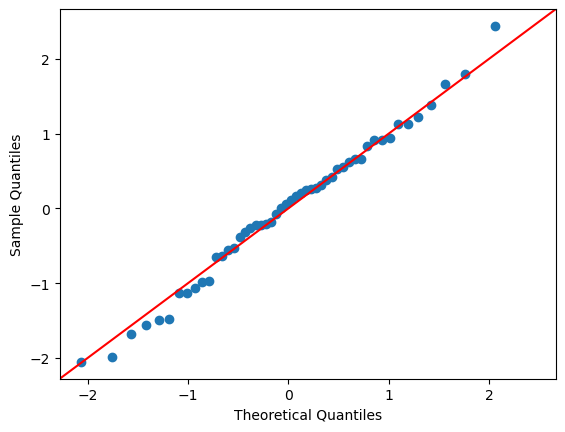

In [393]:
pc_ana('C_df_2')

In [394]:
anova('C_df_2')

ANOVA: (p=0.02 < 0.05). Reject null. The groups have a different population mean.


 [0.2, 0.4, 0.2, 0.2],     # num=3


In [395]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_3',3)  

In [396]:
# see some basic statistics of the data sets
data_C['C_df_3'].describe()

GVWY        SHVR        ZIC         ZIP
count   50.000000   50.000000   50.00000   50.000000
mean   299.911250  282.997500  345.40750  305.050000
std     58.434749  129.504559   99.85226   94.638642
min    187.937500   68.625000  166.87500  155.250000
25%    265.359375  194.750000  285.15625  224.875000
50%    299.375000  260.625000  331.81250  302.187500
75%    341.062500  340.718750  389.93750  366.468750
max    429.125000  574.875000  619.12500  581.000000

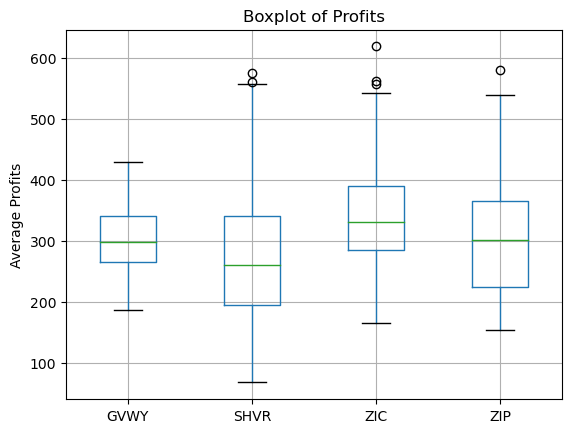

strategy GVWY. We cannot reject the null hypothesis (p=0.45). Therefore, data is normally distributed.
strategy SHVR. We can reject the null hypothesis (p=0.02). Therefore, data is not normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.12). Therefore, data is normally distributed.
strategy ZIP. We can reject the null hypothesis (p=0.05). Therefore, data is not normally distributed.


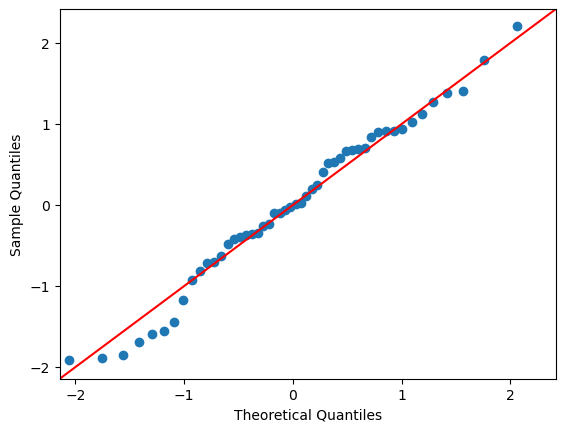

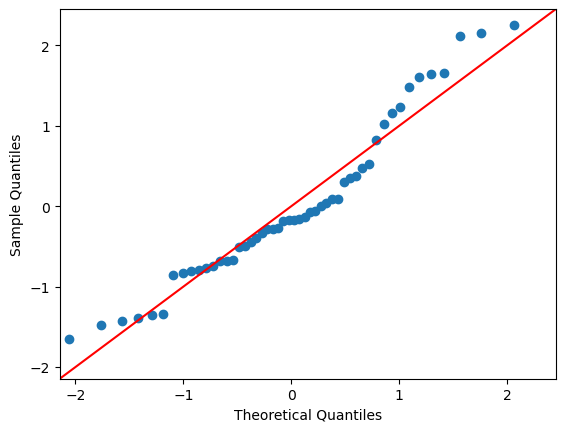

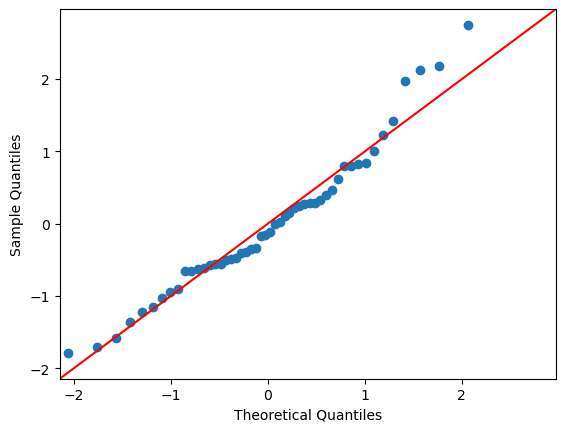

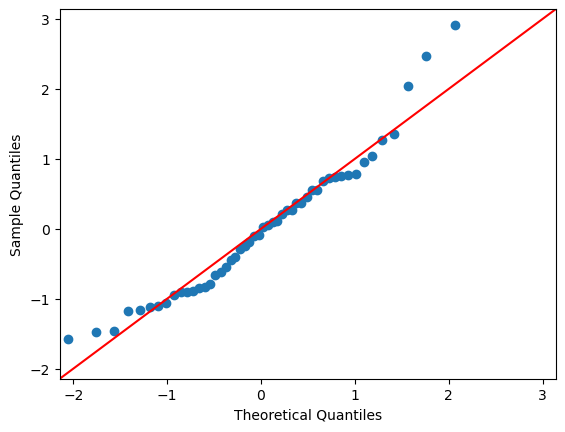

In [397]:
pc_ana('C_df_3')

In [398]:
kw('C_df_3')

Kruskal-Wallis  test: (p= 0.006 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


    [0.2, 0.2, 0.4, 0.2],     # num=4


In [399]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_4',4) 

In [400]:
# see some basic statistics of the data sets
data_C['C_df_4'].describe()

GVWY        SHVR         ZIC         ZIP
count   50.000000   50.000000   50.000000   50.000000
mean   281.140000  267.052500  337.482500  307.170000
std    119.539947  111.007955   80.317336  115.045931
min     27.375000   13.000000  164.187500   23.000000
25%    170.812500  200.906250  290.109375  215.218750
50%    281.375000  252.625000  340.937500  314.562500
75%    374.875000  335.937500  394.656250  393.500000
max    600.125000  530.375000  495.937500  528.000000

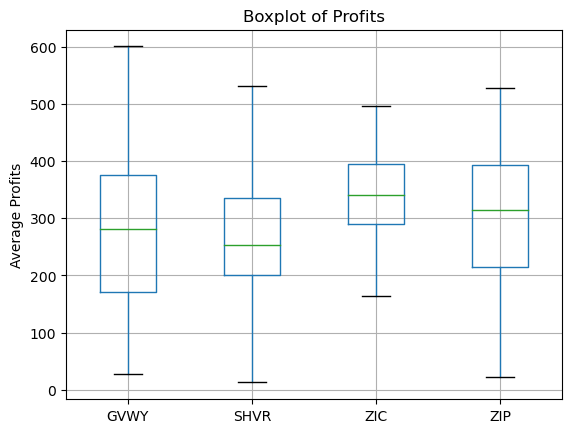

strategy GVWY. We cannot reject the null hypothesis (p=0.25). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.89). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.80). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.42). Therefore, data is normally distributed.


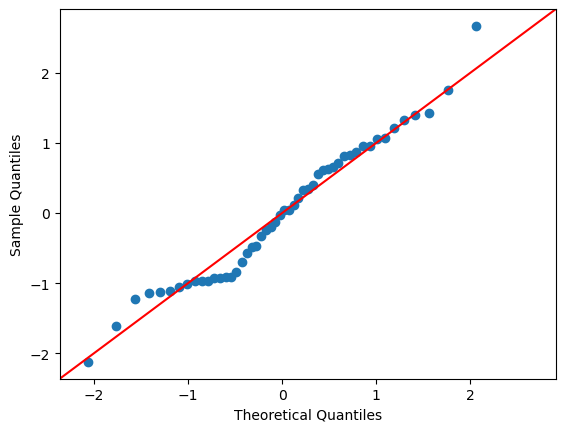

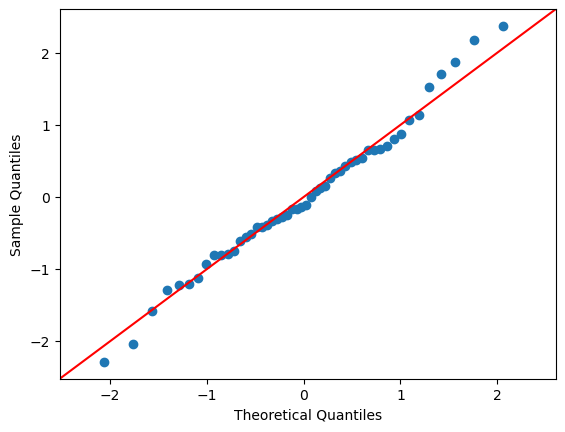

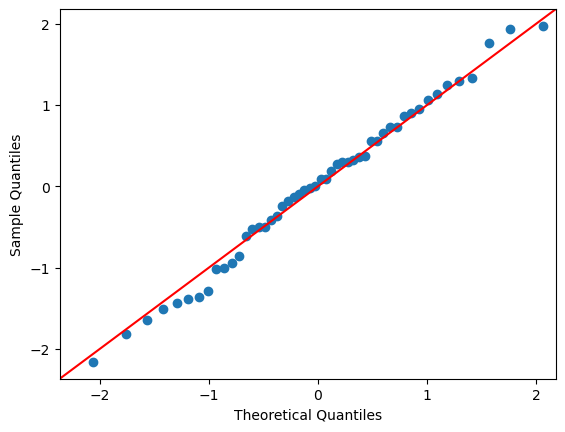

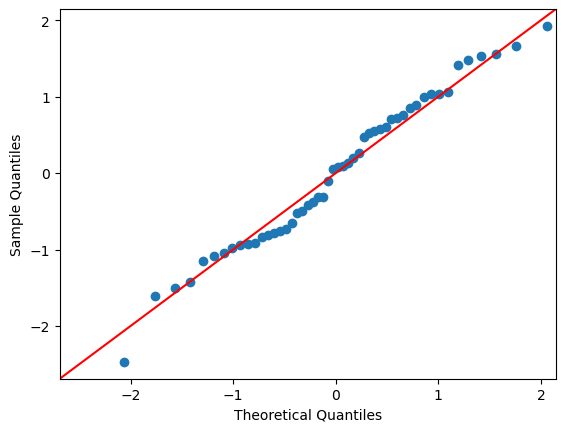

In [401]:
pc_ana('C_df_4')

In [402]:
anova('C_df_4')

ANOVA: (p=0.01 < 0.05). Reject null. The groups have a different population mean.


    [0.2, 0.2, 0.2, 0.4],     # num=5


In [403]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_5',5) 

In [404]:
# see some basic statistics of the data sets
data_C['C_df_5'].describe()

GVWY        SHVR        ZIC        ZIP
count   50.000000   50.000000   50.00000   50.00000
mean   291.782500  294.467500  315.17250  314.17125
std    112.038119  141.109924  116.46707   77.22777
min     56.000000   15.750000   80.12500  126.12500
25%    219.656250  206.593750  238.96875  258.21875
50%    302.687500  289.937500  314.62500  303.53125
75%    354.500000  394.062500  400.96875  368.71875
max    561.750000  623.750000  560.12500  475.56250

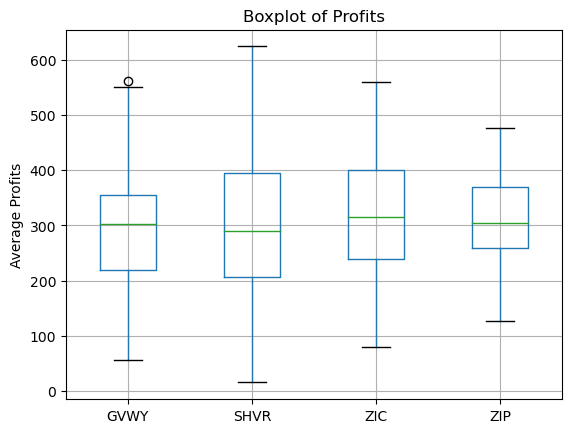

strategy GVWY. We cannot reject the null hypothesis (p=0.82). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.86). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.70). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.68). Therefore, data is normally distributed.


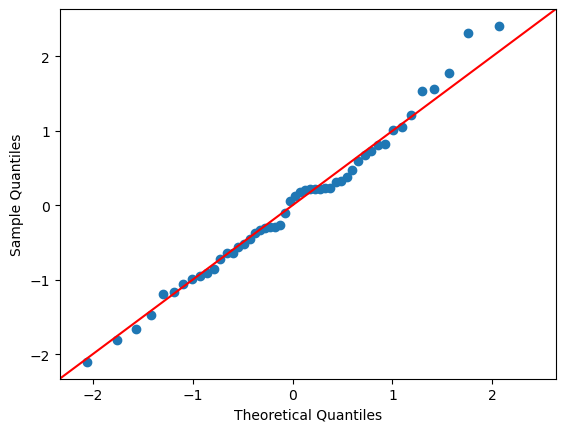

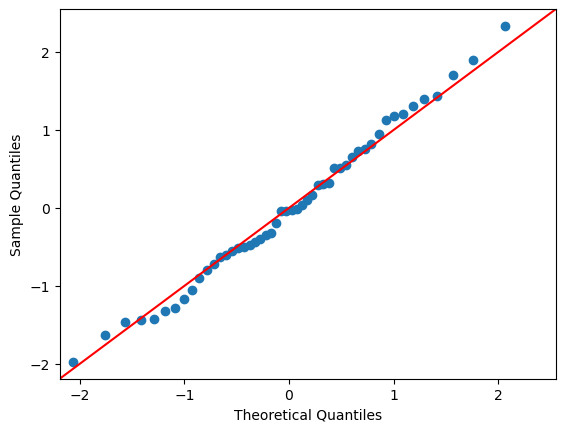

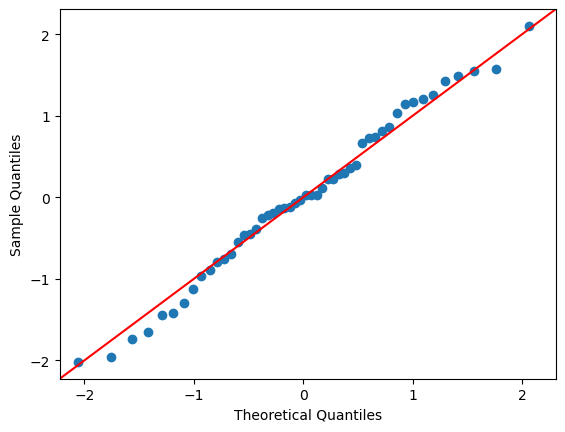

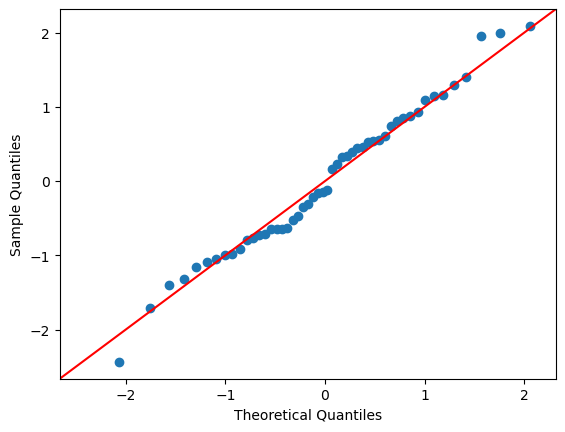

In [405]:
pc_ana('C_df_5')

In [406]:
anova('C_df_5')

ANOVA: (p=0.62 > 0.05). Cannot reject null hypothesis that groups have same population mean.


    [0.1, 0.3, 0.3, 0.3],     # num=6


In [407]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_6',6) 

In [408]:
# see some basic statistics of the data sets
data_C['C_df_6'].describe()

GVWY        SHVR         ZIC         ZIP
count   50.000000   50.000000   50.000000   50.000000
mean   302.356667  314.105000  306.418333  305.451667
std     72.740652  184.577027  102.146171   94.590095
min    140.583333   13.500000   94.333333   59.333333
25%    246.062500  179.062500  217.062500  237.541667
50%    290.583333  297.250000  310.750000  294.625000
75%    356.479167  431.625000  381.708333  361.625000
max    511.000000  759.500000  498.416667  545.166667

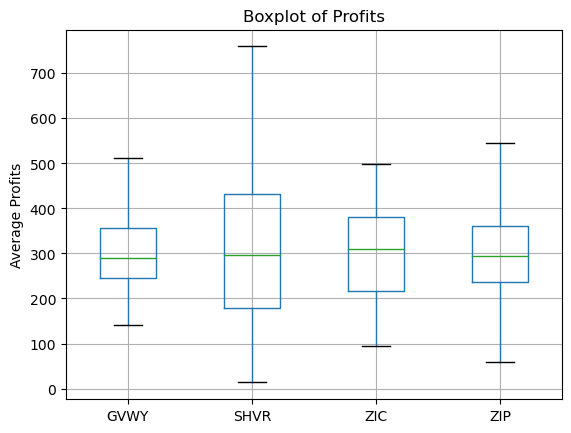

strategy GVWY. We cannot reject the null hypothesis (p=0.69). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.15). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.26). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.77). Therefore, data is normally distributed.


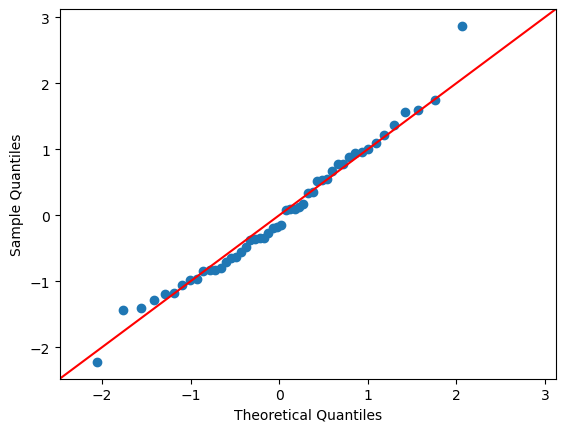

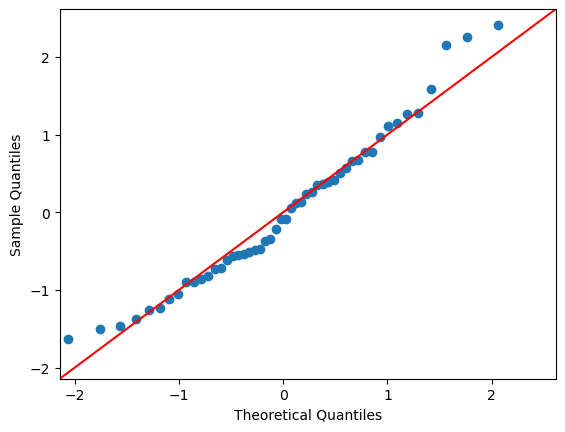

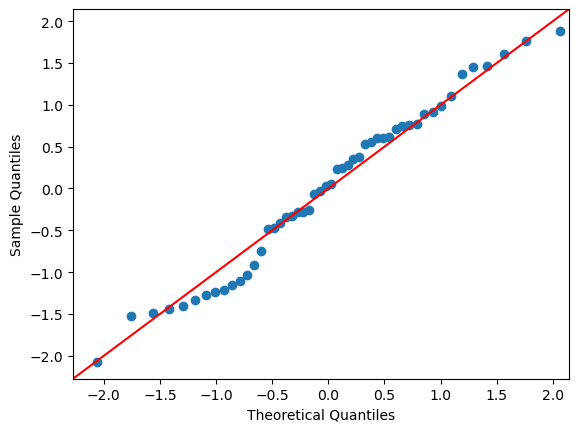

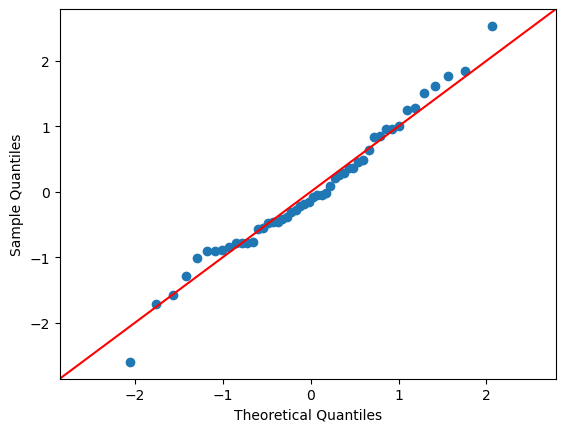

In [409]:
pc_ana('C_df_6')

In [410]:
anova('C_df_6')

ANOVA: (p=0.97 > 0.05). Cannot reject null hypothesis that groups have same population mean.


    [0.3, 0.1, 0.3, 0.3],     # num=7


In [411]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_7',7) 

In [412]:
# see some basic statistics of the data sets
data_C['C_df_7'].describe()

GVWY        SHVR         ZIC         ZIP
count   50.000000   50.000000   50.000000   50.000000
mean   279.125000  316.370000  303.230000  307.845000
std    160.252266   88.469239   85.402561   87.700095
min     24.000000  153.000000  126.416667  138.083333
25%    142.375000  244.833333  244.833333  241.916667
50%    266.750000  327.333333  296.458333  310.000000
75%    380.562500  377.770833  376.250000  360.770833
max    605.000000  538.500000  467.750000  476.000000

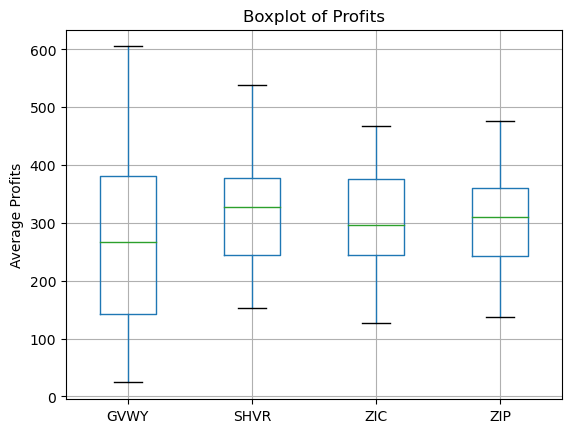

strategy GVWY. We cannot reject the null hypothesis (p=0.13). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.11). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.31). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.38). Therefore, data is normally distributed.


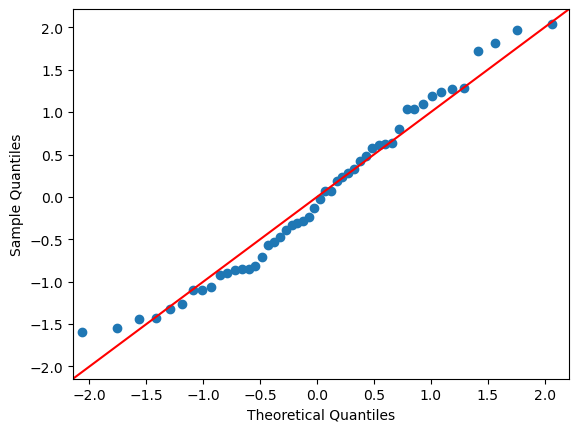

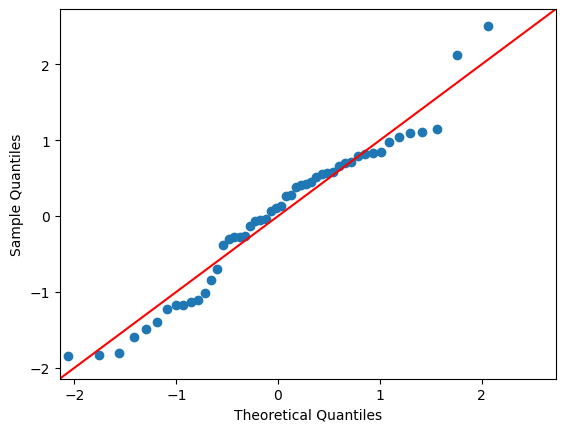

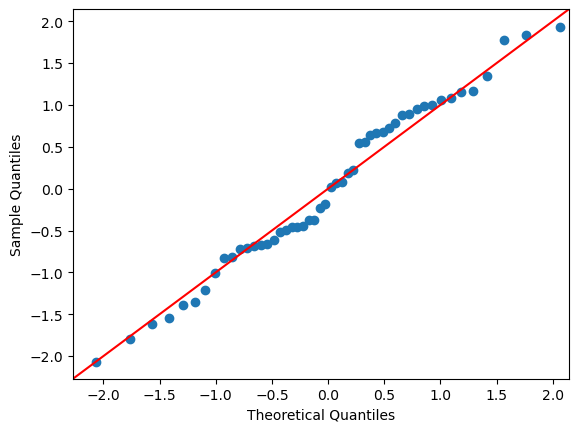

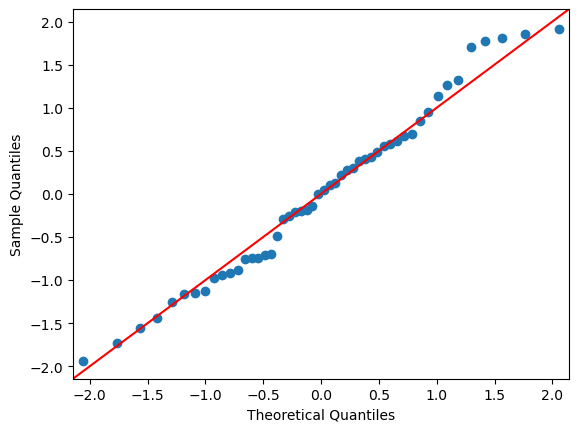

In [413]:
pc_ana('C_df_7')

In [414]:
anova('C_df_7')

ANOVA: (p=0.37 > 0.05). Cannot reject null hypothesis that groups have same population mean.


    [0.3, 0.3, 0.1, 0.3],     # num=8
   

In [415]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_8',8) 

In [416]:
# see some basic statistics of the data sets
data_C['C_df_8'].describe()

GVWY        SHVR         ZIC         ZIP
count   50.000000   50.000000   50.000000   50.000000
mean   296.308333  268.531667  362.065000  335.378333
std     91.174461   89.170258  175.313166   96.155447
min    123.583333   66.166667    2.500000  182.083333
25%    220.062500  213.645833  247.687500  264.270833
50%    288.958333  262.750000  356.500000  340.583333
75%    348.854167  323.145833  473.312500  400.166667
max    567.416667  460.916667  710.000000  611.333333

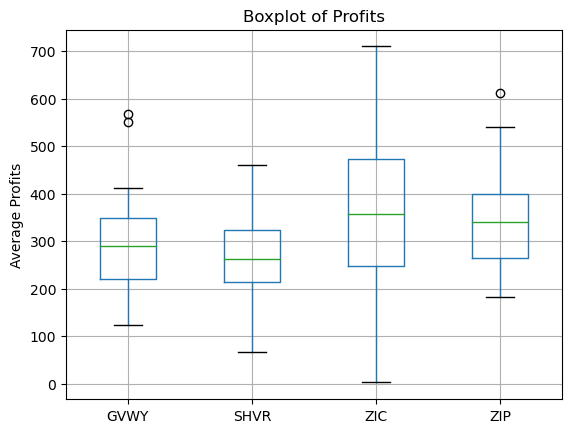

strategy GVWY. We cannot reject the null hypothesis (p=0.07). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.85). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.39). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.20). Therefore, data is normally distributed.


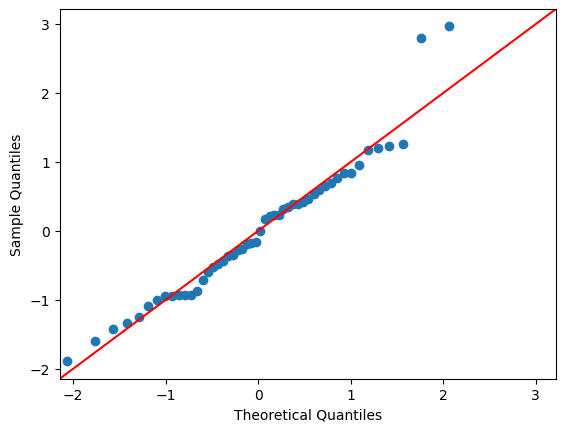

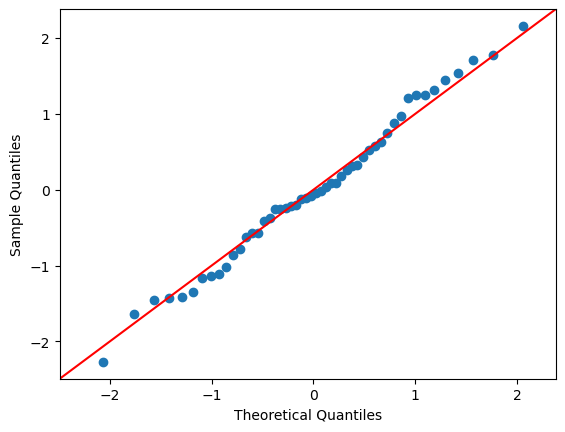

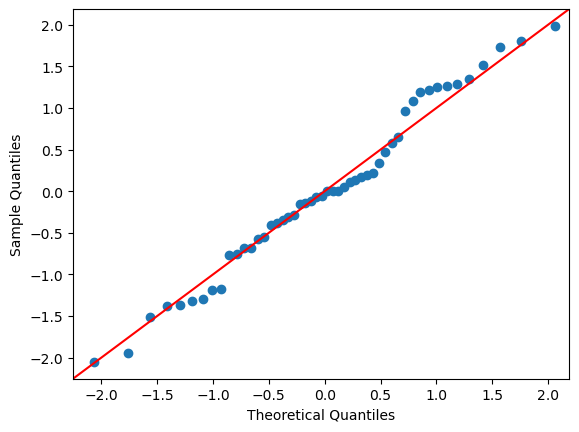

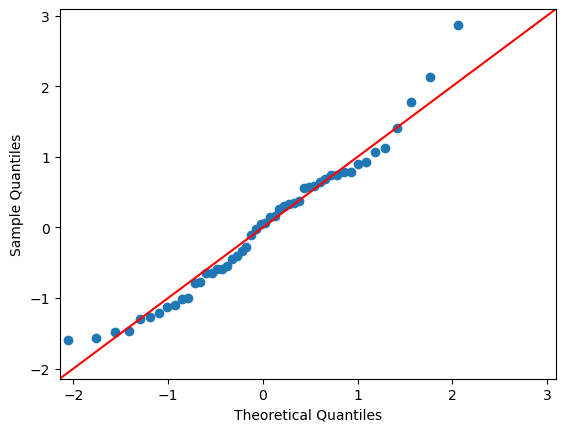

In [417]:
pc_ana('C_df_8')

In [418]:
anova('C_df_8')

ANOVA: (p=0.00 < 0.05). Reject null. The groups have a different population mean.


 [0.3, 0.3, 0.3, 0.1],     # num=9


In [419]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_9',9) 

In [420]:
# see some basic statistics of the data sets
data_C['C_df_9'].describe()

GVWY        SHVR         ZIC         ZIP
count   50.000000   50.000000   50.000000   50.000000
mean   291.011667  295.535000  332.955000  312.280000
std     77.918003   93.228330   89.479161  159.185968
min    129.916667  110.500000  123.916667   13.250000
25%    245.916667  230.000000  264.750000  190.500000
50%    297.083333  288.208333  345.750000  310.375000
75%    343.520833  354.958333  396.375000  421.062500
max    461.750000  558.583333  494.250000  638.750000

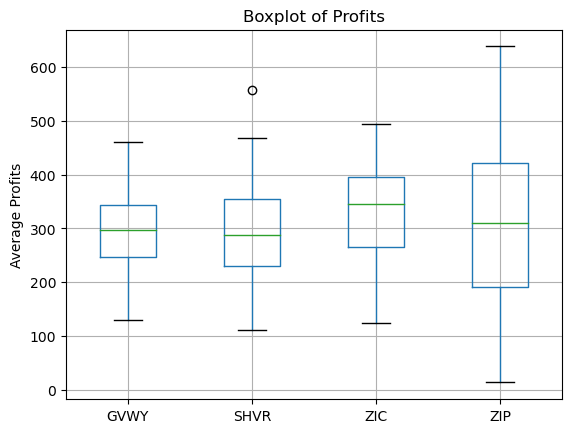

strategy GVWY. We cannot reject the null hypothesis (p=0.47). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.86). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.23). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.66). Therefore, data is normally distributed.


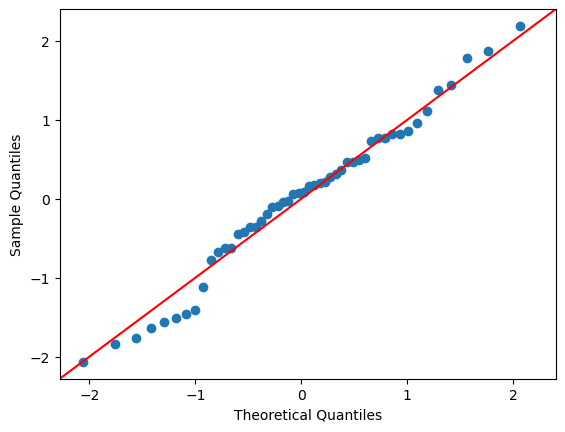

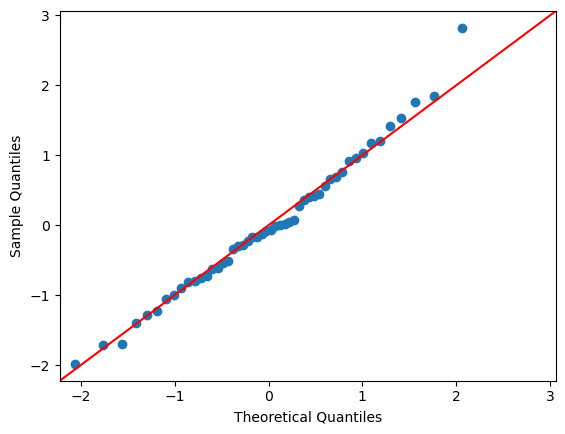

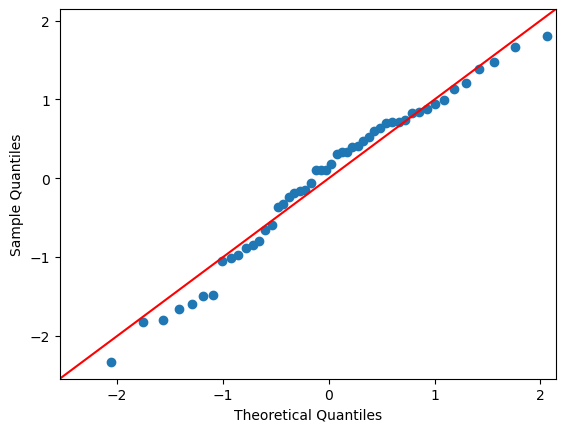

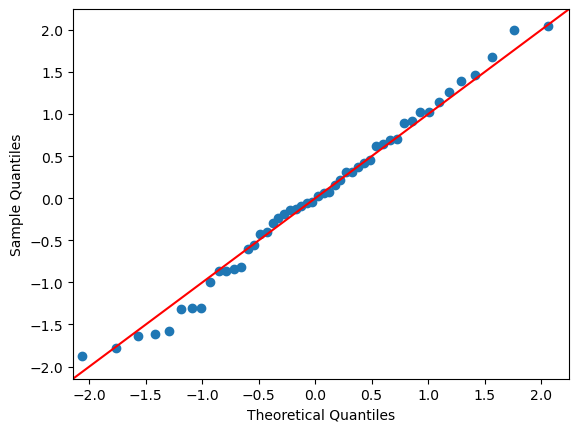

In [421]:
pc_ana('C_df_9')

In [422]:
anova('C_df_9')

ANOVA: (p=0.21 > 0.05). Cannot reject null hypothesis that groups have same population mean.


    [0.7, 0.1, 0.1, 0.1],     # num=10


In [423]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_10',10) 

In [424]:
# see some basic statistics of the data sets
data_C['C_df_10'].describe()

GVWY        SHVR         ZIC         ZIP
count   50.000000   50.000000   50.000000   50.000000
mean   303.485000  300.875714  363.590000  300.695000
std    155.638501   40.835227  168.784292  169.582157
min     14.750000  237.107143   63.750000    0.000000
25%    189.000000  271.000000  236.562500  144.000000
50%    319.375000  296.160715  361.500000  318.625000
75%    392.125000  322.080357  476.312500  414.750000
max    636.500000  386.250000  757.750000  688.750000

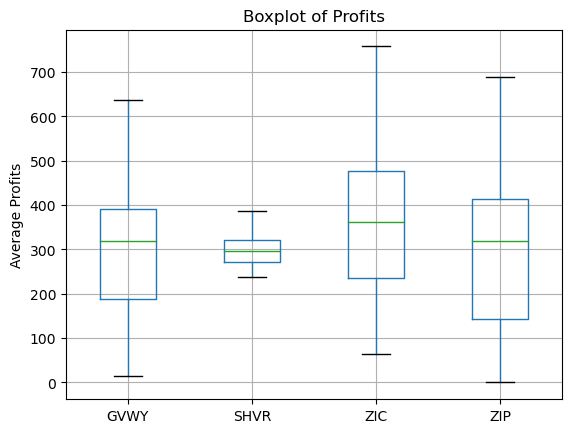

strategy GVWY. We cannot reject the null hypothesis (p=0.62). Therefore, data is normally distributed.
strategy SHVR. We can reject the null hypothesis (p=0.02). Therefore, data is not normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.48). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.39). Therefore, data is normally distributed.


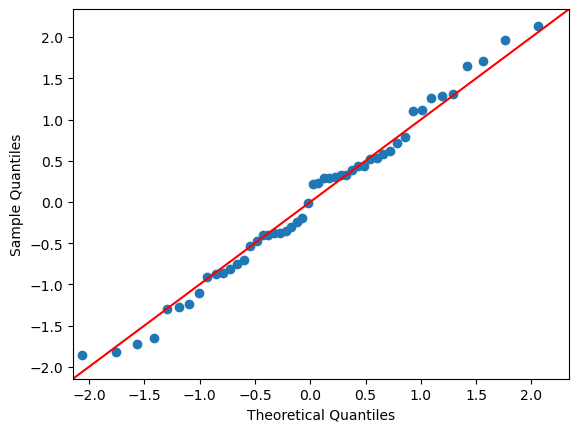

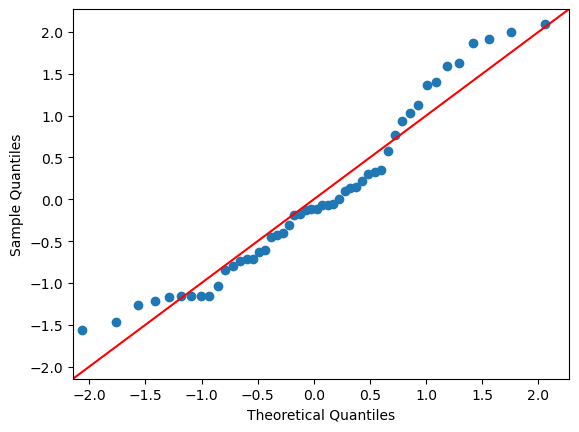

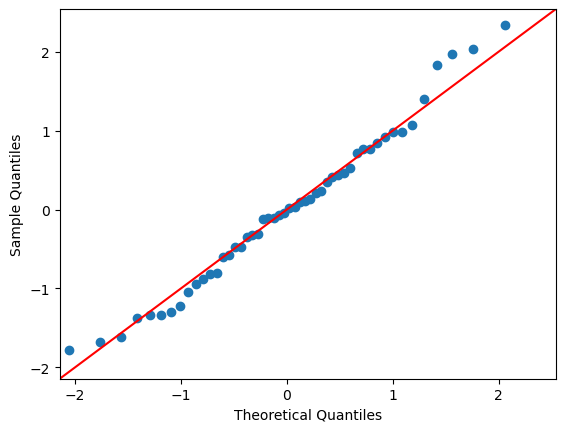

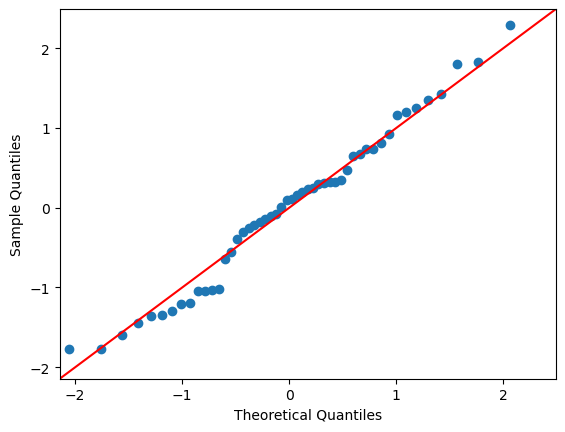

In [425]:
pc_ana('C_df_10')

In [426]:
kw('C_df_10')

Kruskal-Wallis  test: (p= 0.117 > 0.05). Cannot reject null hypothesis that the samples have identical average values


    [0.1, 0.7, 0.1, 0.1],     # num=11
    

In [427]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_11',11) 

In [428]:
# see some basic statistics of the data sets
data_C['C_df_11'].describe()

GVWY        SHVR        ZIC         ZIP
count   50.000000   50.000000   50.00000   50.000000
mean   299.241429  261.730000  359.56000  352.610000
std     43.437857  145.382087  187.96035  193.129082
min    192.857143    0.000000   63.75000   29.000000
25%    267.589285  139.062500  221.43750  198.062500
50%    299.964286  288.125000  327.12500  344.875000
75%    326.919643  361.375000  473.81250  463.000000
max    389.857143  626.250000  733.50000  782.500000

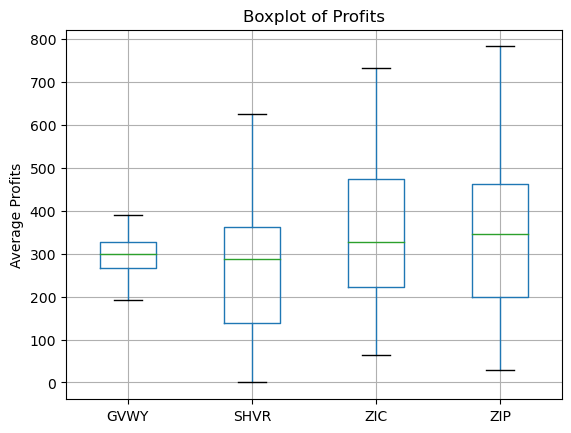

strategy GVWY. We cannot reject the null hypothesis (p=0.81). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.10). Therefore, data is normally distributed.
strategy ZIC. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.10). Therefore, data is normally distributed.


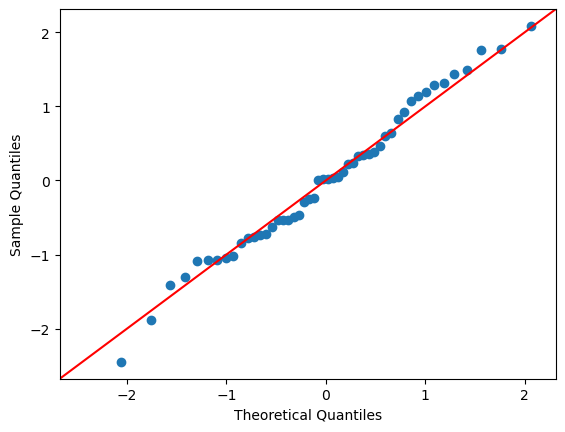

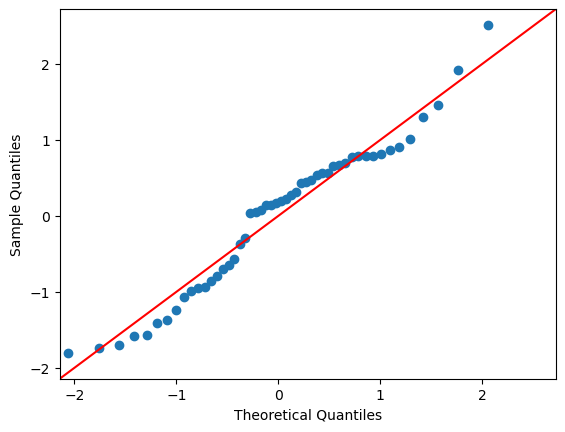

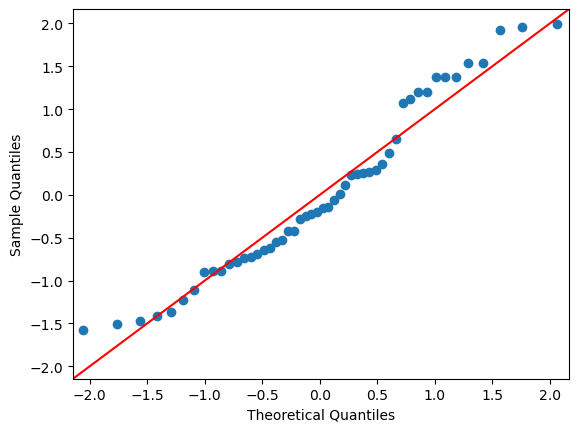

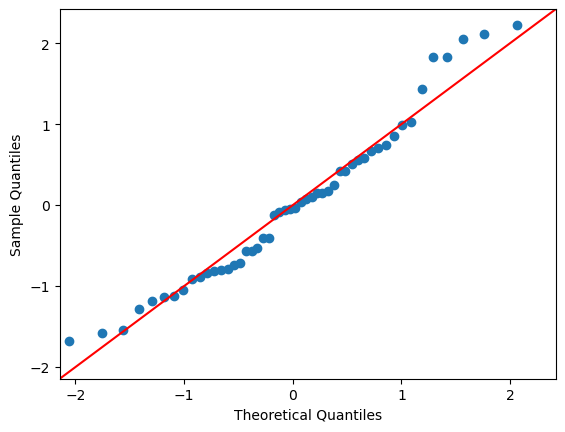

In [429]:
pc_ana('C_df_11')

In [430]:
kw('C_df_11')

Kruskal-Wallis  test: (p= 0.079 > 0.05). Cannot reject null hypothesis that the samples have identical average values


[0.1, 0.1, 0.7, 0.1],     # num=12


In [431]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_12',12) 

In [432]:
# see some basic statistics of the data sets
data_C['C_df_12'].describe()

GVWY       SHVR         ZIC         ZIP
count   50.000000   50.00000   50.000000   50.000000
mean   266.365000  325.33500  313.135714  275.260000
std    154.033633  178.37471   33.165125  178.697741
min      4.000000   27.75000  227.642857   20.750000
25%    151.750000  175.00000  291.750000   77.625000
50%    255.875000  352.25000  317.142857  316.750000
75%    353.125000  422.50000  335.598214  419.250000
max    632.000000  718.50000  380.964286  594.250000

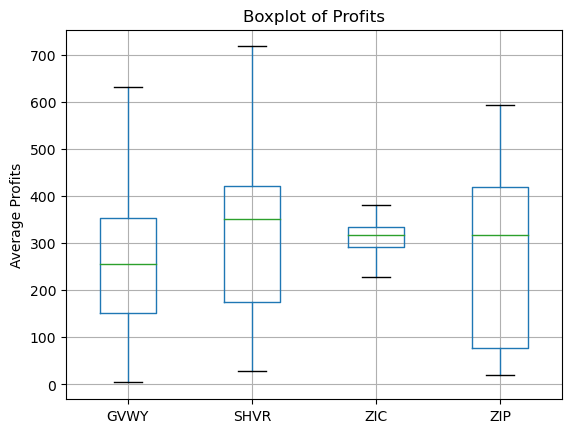

strategy GVWY. We cannot reject the null hypothesis (p=0.39). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.20). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.61). Therefore, data is normally distributed.
strategy ZIP. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.


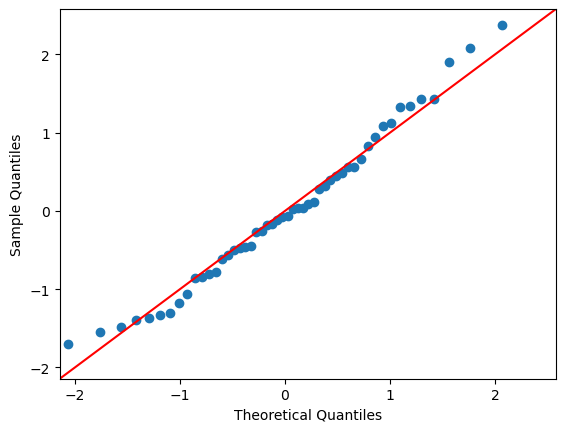

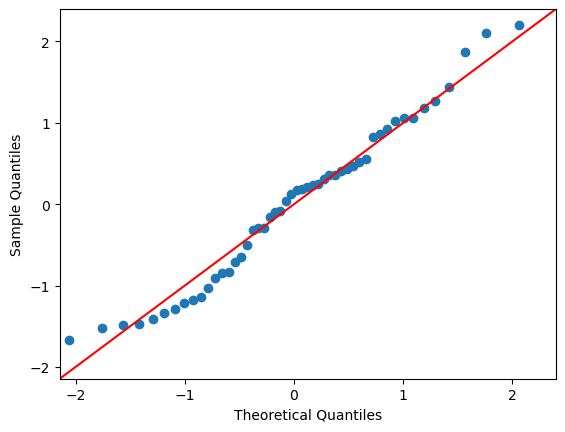

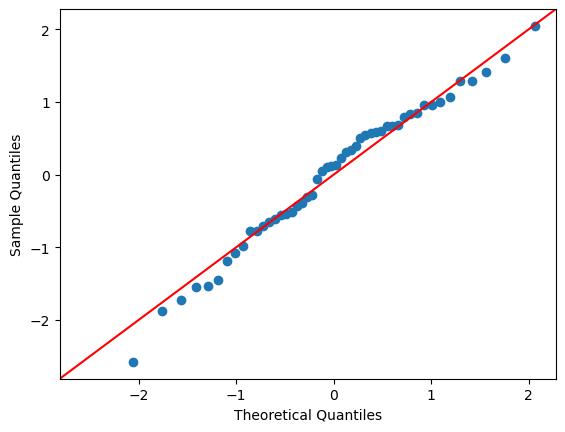

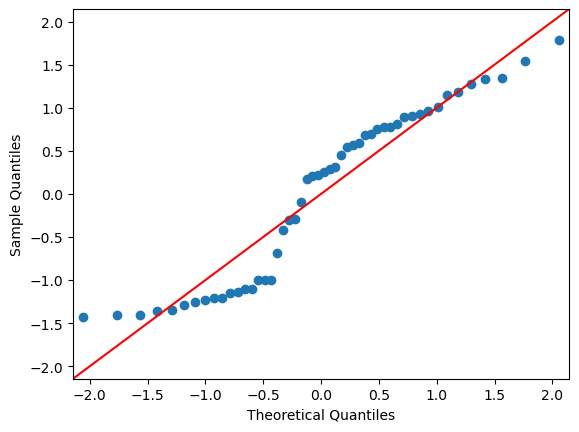

In [433]:
pc_ana('C_df_12')

In [434]:
kw('C_df_12')

Kruskal-Wallis  test: (p= 0.166 > 0.05). Cannot reject null hypothesis that the samples have identical average values


    [0.1, 0.1, 0.1, 0.7]      # num=13

In [435]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_13',13) 

In [436]:
# see some basic statistics of the data sets
data_C['C_df_13'].describe()

GVWY        SHVR         ZIC         ZIP
count   50.000000   50.000000   50.000000   50.000000
mean   269.700000  318.445000  258.235000  311.757857
std    151.877586  182.859217  141.063674   39.324504
min      5.500000   17.000000    6.000000  198.964286
25%    152.312500  158.312500  147.437500  286.714286
50%    282.250000  350.000000  247.250000  307.107143
75%    368.687500  421.062500  357.687500  331.848214
max    638.250000  758.250000  619.500000  416.285714

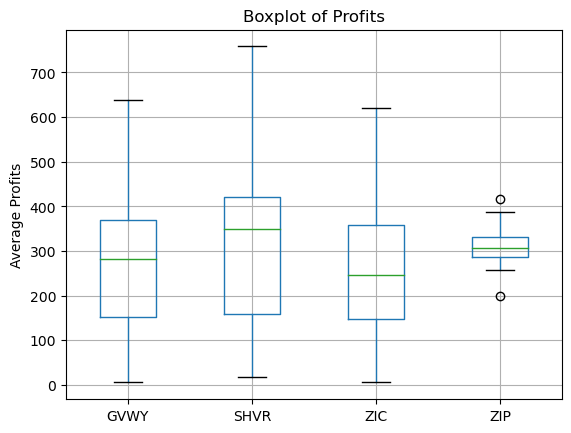

strategy GVWY. We cannot reject the null hypothesis (p=0.30). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.08). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.30). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.28). Therefore, data is normally distributed.


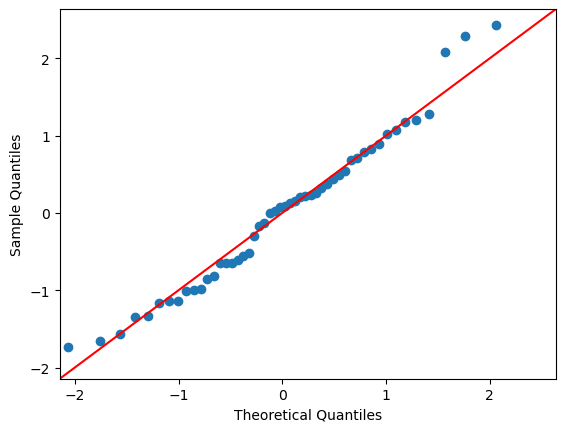

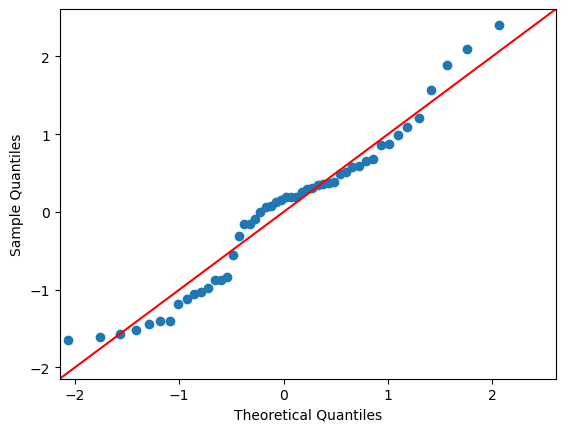

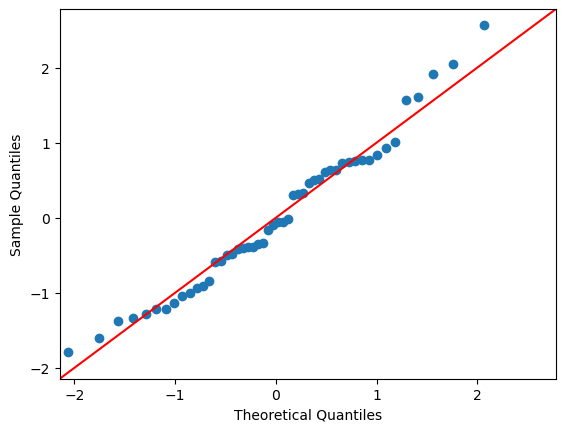

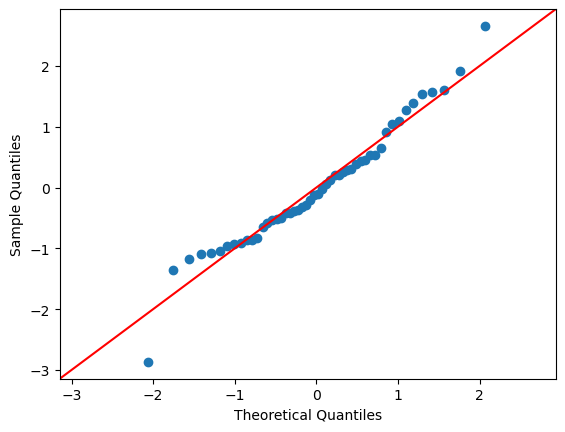

In [437]:
pc_ana('C_df_13')

In [438]:
anova('C_df_13')

ANOVA: (p=0.08 > 0.05). Cannot reject null hypothesis that groups have same population mean.


Then, we explore the situation that 'N=500' and observe the results.

In [381]:
# run 'N=500'
j_num=1
for r in ratios_all:
    run_Vernon_four(N=500,end_time=60*10,ratios=r,num=j_num)
    j_num+=1

[0.25, 0.25, 0.25, 0.25], # num=1

In [383]:
# run the pc_combine_data function
pc_combine_data(500,'hC_df_1',1) 

In [439]:
# see some basic statistics of the data sets
data_C['hC_df_1'].describe()

GVWY        SHVR         ZIC         ZIP
count  500.00000  500.000000  500.000000  500.000000
mean   280.54060  304.191200  321.611600  320.222200
std     93.13663   98.901506  101.045318   97.053666
min     60.50000   58.600000   20.800000   38.100000
25%    217.27500  236.075000  250.725000  256.950000
50%    273.70000  305.150000  320.850000  314.900000
75%    345.12500  369.725000  387.325000  387.225000
max    581.50000  622.900000  602.300000  578.200000

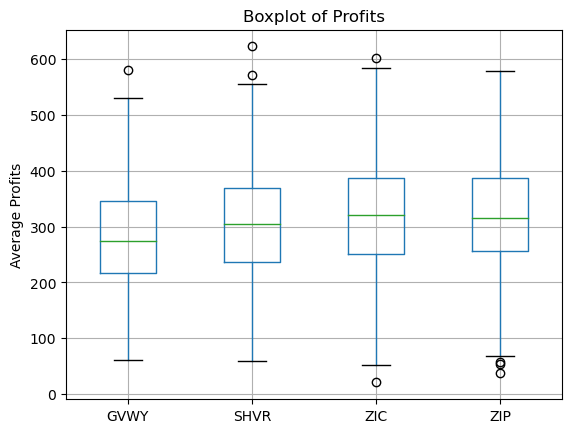

strategy GVWY. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.45). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.39). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.19). Therefore, data is normally distributed.


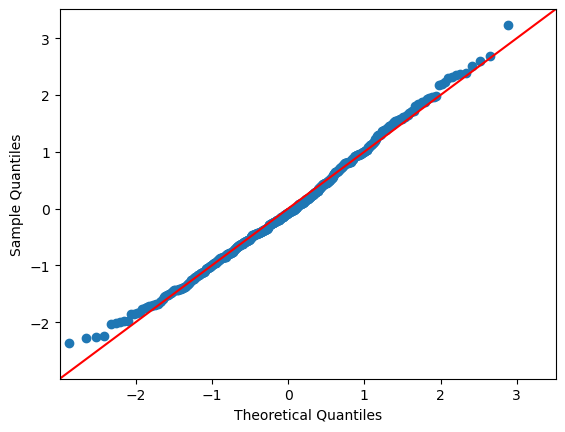

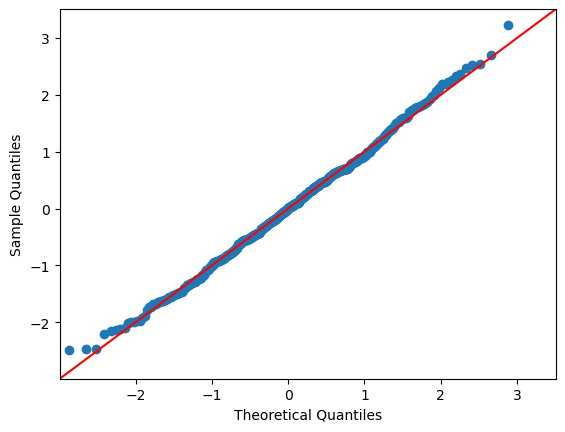

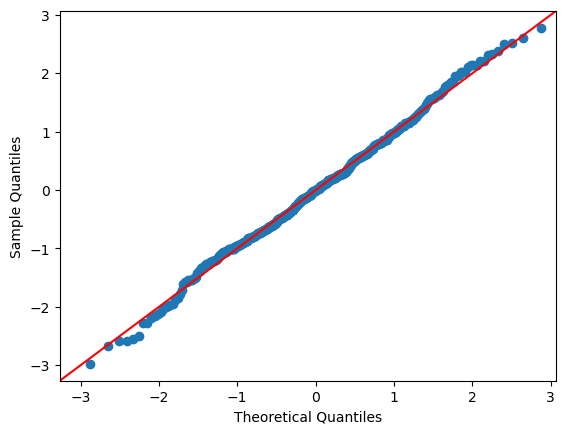

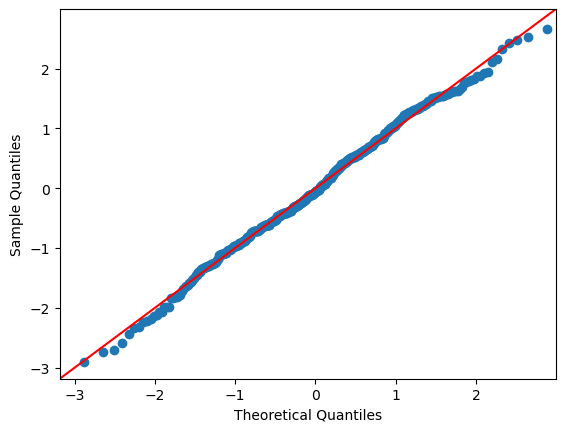

In [440]:
pc_ana('hC_df_1')

In [441]:
kw('hC_df_1')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


   [0.4, 0.2, 0.2, 0.2],     # num=2
   

In [442]:
pc_combine_data(500,'hC_df_2',2) 

In [443]:
data_C['hC_df_2'].describe()

GVWY        SHVR         ZIC         ZIP
count  500.000000  500.000000  500.000000  500.000000
mean   295.071250  293.845750  332.686000  319.737750
std    108.515675   73.641014  108.722865  119.150729
min     23.000000  106.312500   52.250000    9.375000
25%    215.593750  239.750000  255.062500  233.562500
50%    295.250000  290.656250  325.500000  321.437500
75%    370.437500  345.734375  407.375000  396.531250
max    590.500000  559.250000  652.625000  700.500000

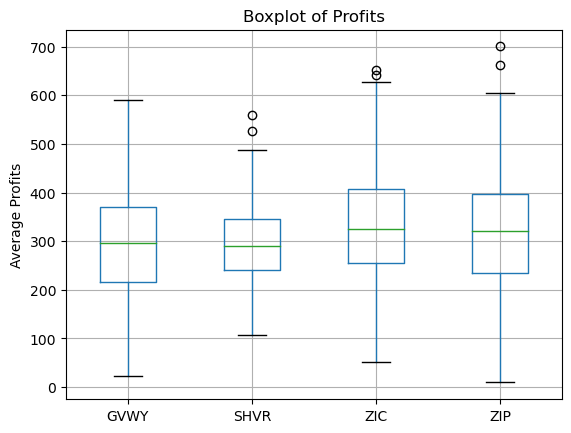

strategy GVWY. We cannot reject the null hypothesis (p=0.32). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.08). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.39). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.82). Therefore, data is normally distributed.


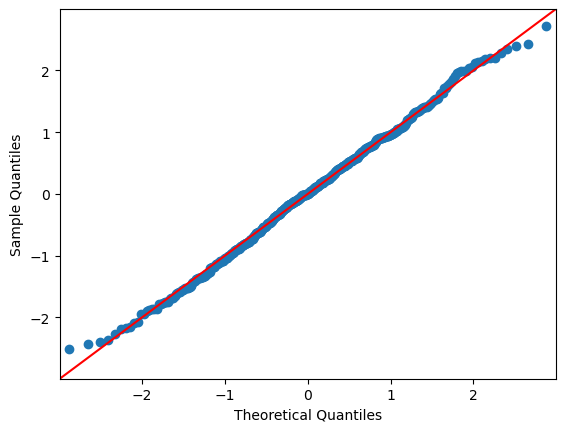

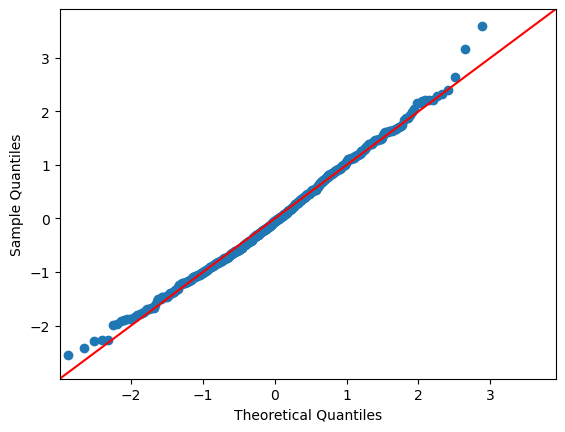

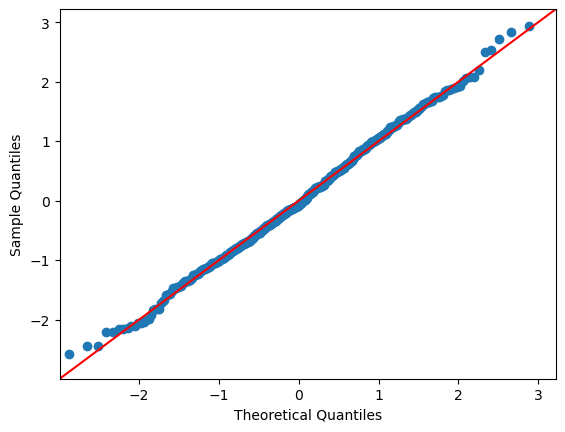

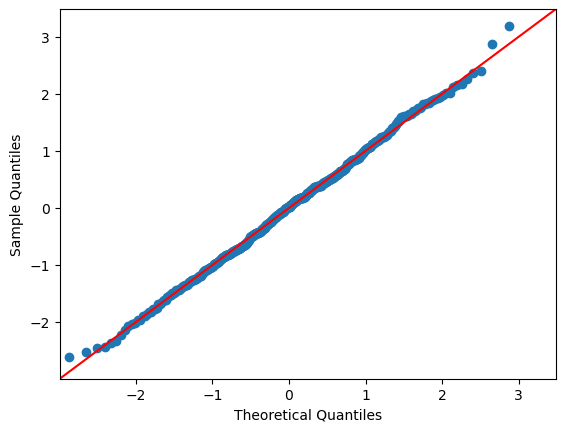

In [446]:
pc_ana('hC_df_2')

In [447]:
anova('hC_df_2')

ANOVA: (p=0.00 < 0.05). Reject null. The groups have a different population mean.


 [0.2, 0.4, 0.2, 0.2],     # num=3


In [448]:
pc_combine_data(500,'hC_df_3',3) 

In [449]:
data_C['hC_df_3'].describe()

GVWY        SHVR         ZIC         ZIP
count  500.000000  500.000000  500.000000  500.000000
mean   292.410000  297.986250  334.252750  316.539250
std     66.573918  125.505218  123.654435  125.076548
min    113.250000   27.000000   73.250000   21.625000
25%    244.187500  208.375000  247.062500  223.500000
50%    293.656250  295.437500  332.062500  308.375000
75%    336.281250  384.531250  411.656250  407.968750
max    487.062500  709.000000  701.875000  683.500000

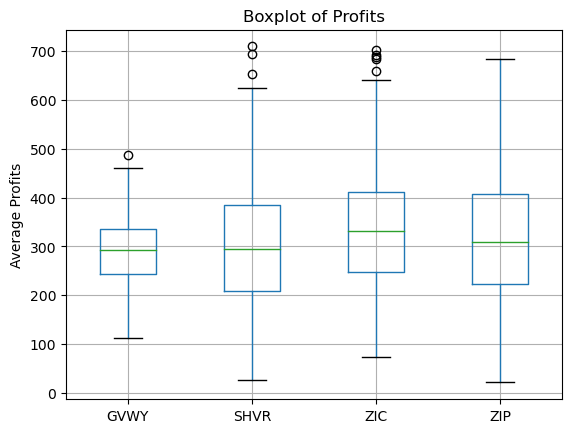

strategy GVWY. We cannot reject the null hypothesis (p=0.37). Therefore, data is normally distributed.
strategy SHVR. We can reject the null hypothesis (p=0.02). Therefore, data is not normally distributed.
strategy ZIC. We can reject the null hypothesis (p=0.01). Therefore, data is not normally distributed.
strategy ZIP. We can reject the null hypothesis (p=0.01). Therefore, data is not normally distributed.


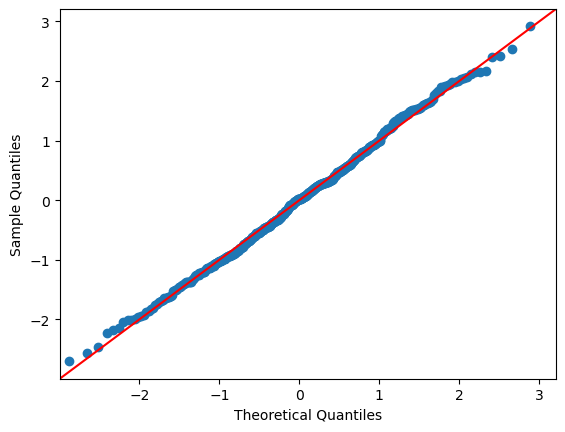

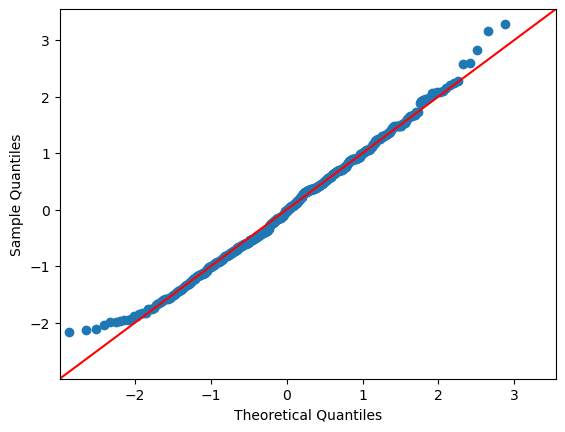

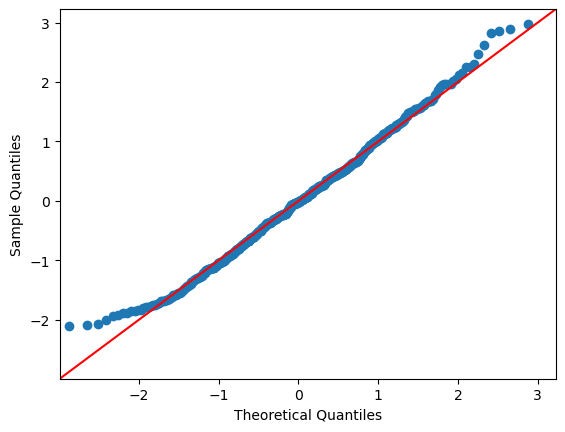

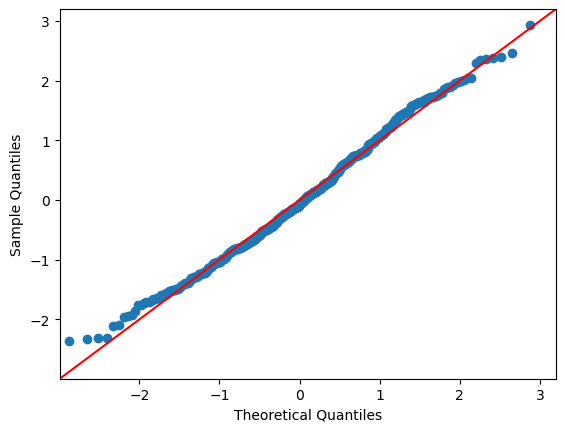

In [450]:
pc_ana('hC_df_3')

In [451]:
kw('hC_df_3')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


    [0.2, 0.2, 0.4, 0.2],     # num=4


In [452]:
pc_combine_data(500,'hC_df_4',4) 

In [453]:
data_C['hC_df_4'].describe()

GVWY        SHVR         ZIC         ZIP
count  500.000000  500.000000  500.000000  500.000000
mean   282.488000  312.999250  312.604625  310.577500
std    104.151942  119.709802   72.731286  123.698331
min     31.250000   31.875000  118.000000   37.125000
25%    211.750000  227.812500  262.046875  219.687500
50%    278.875000  309.062500  311.500000  301.562500
75%    357.593750  391.656250  361.828125  398.281250
max    571.750000  688.000000  525.500000  643.750000

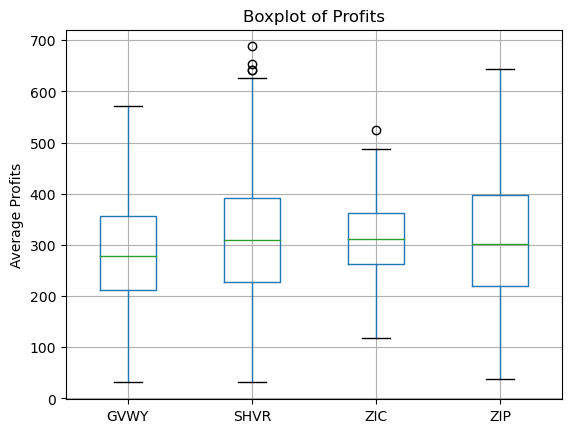

strategy GVWY. We cannot reject the null hypothesis (p=0.10). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.15). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.68). Therefore, data is normally distributed.
strategy ZIP. We can reject the null hypothesis (p=0.01). Therefore, data is not normally distributed.


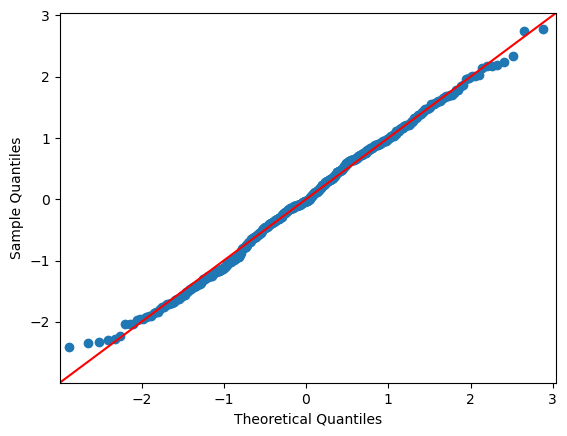

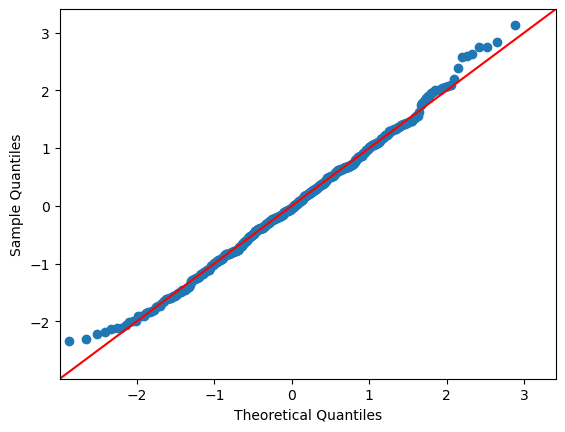

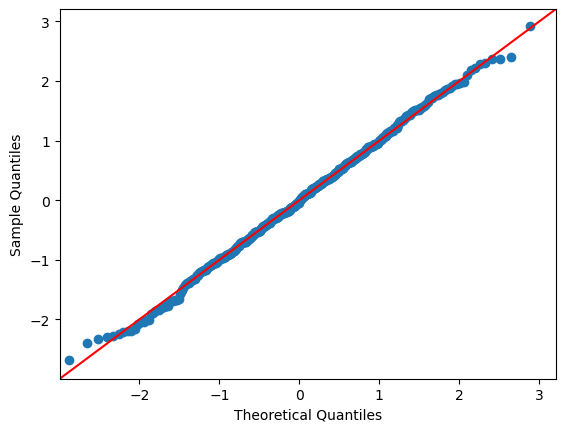

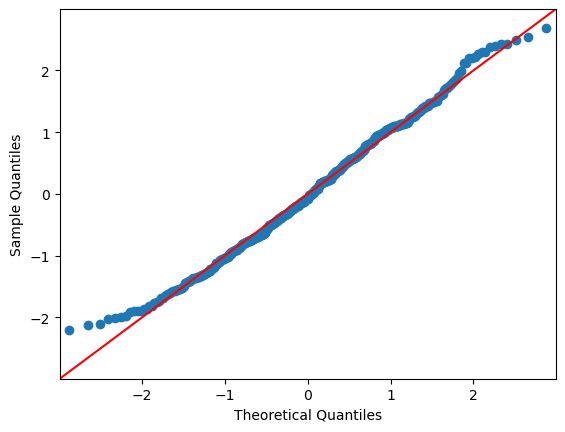

In [454]:
pc_ana('hC_df_4')

In [455]:
kw('hC_df_4')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


    [0.2, 0.2, 0.2, 0.4],     # num=5


In [456]:
pc_combine_data(500,'hC_df_5',5) 

In [457]:
data_C['hC_df_5'].describe()

GVWY        SHVR         ZIC         ZIP
count  500.000000  500.000000  500.000000  500.000000
mean   286.964000  298.671750  321.048000  311.038125
std    105.794173  124.285322  118.685328   72.931164
min     10.125000   17.875000    2.375000   86.562500
25%    210.968750  212.125000  242.062500  263.718750
50%    287.312500  295.750000  314.562500  310.312500
75%    358.343750  384.562500  394.781250  358.171875
max    618.625000  712.250000  676.750000  491.875000

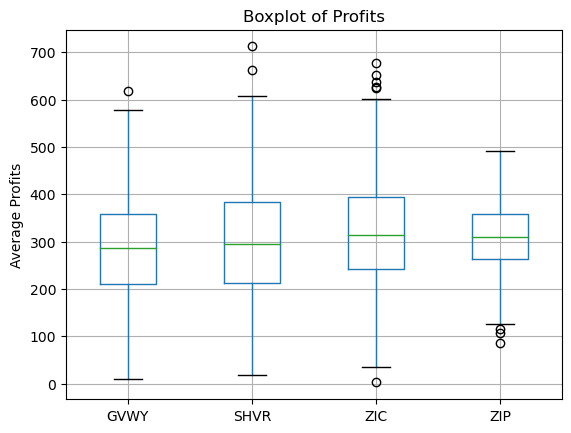

strategy GVWY. We cannot reject the null hypothesis (p=0.20). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.13). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.20). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.55). Therefore, data is normally distributed.


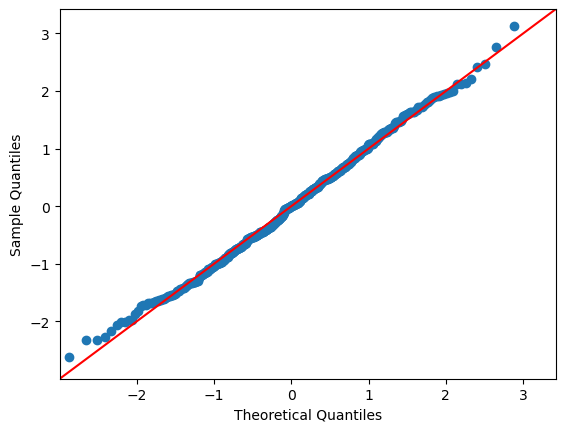

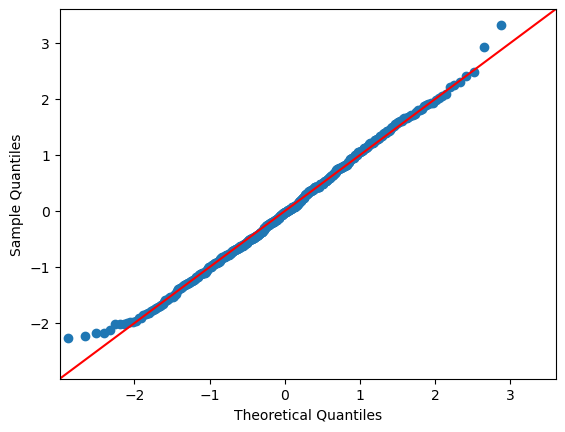

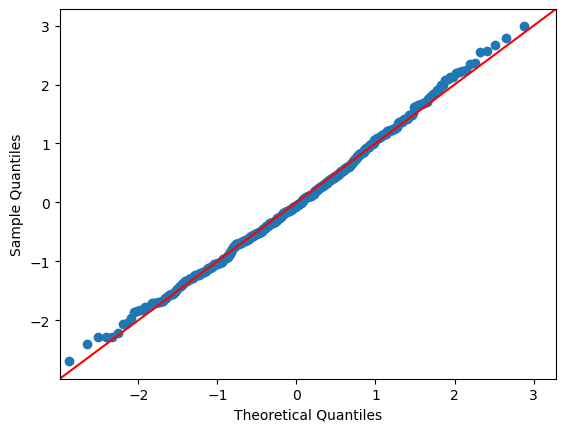

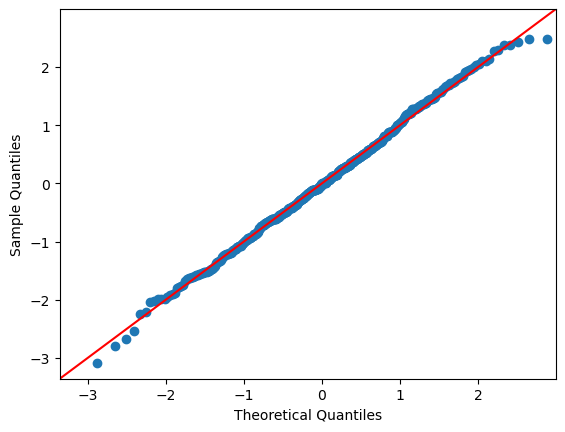

In [458]:
pc_ana('hC_df_5')

In [459]:
anova('hC_df_5')

ANOVA: (p=0.00 < 0.05). Reject null. The groups have a different population mean.


    [0.1, 0.3, 0.3, 0.3],     # num=6


In [460]:
pc_combine_data(500,'hC_df_6',6) 

In [461]:
data_C['hC_df_6'].describe()

GVWY        SHVR         ZIC         ZIP
count  500.000000  500.000000  500.000000  500.000000
mean   286.637500  301.259500  323.372333  308.847833
std     82.681113  170.933464   91.300342   91.020977
min     75.416667    0.250000   89.666667   43.333333
25%    228.645833  172.312500  260.041667  249.229167
50%    278.333333  303.875000  322.041667  302.166667
75%    336.250000  406.500000  391.854167  372.854167
max    556.416667  774.250000  575.333333  594.166667

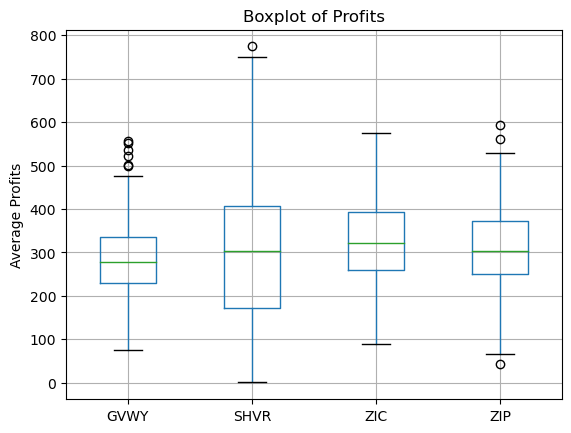

strategy GVWY. We can reject the null hypothesis (p=0.01). Therefore, data is not normally distributed.
strategy SHVR. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.34). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.39). Therefore, data is normally distributed.


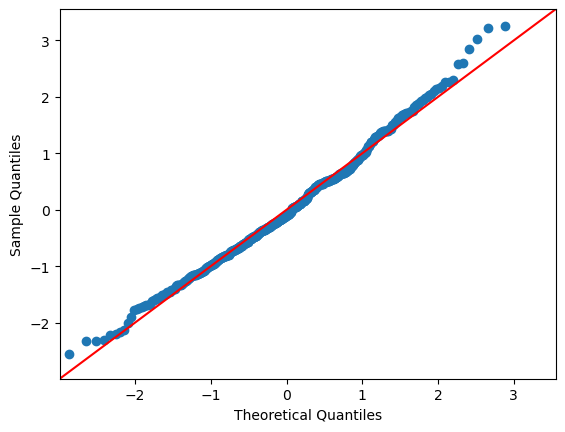

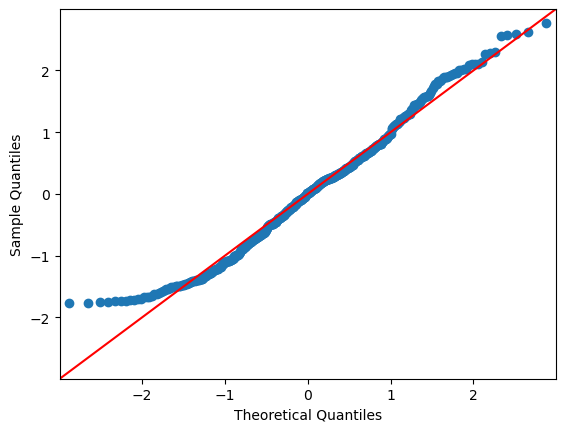

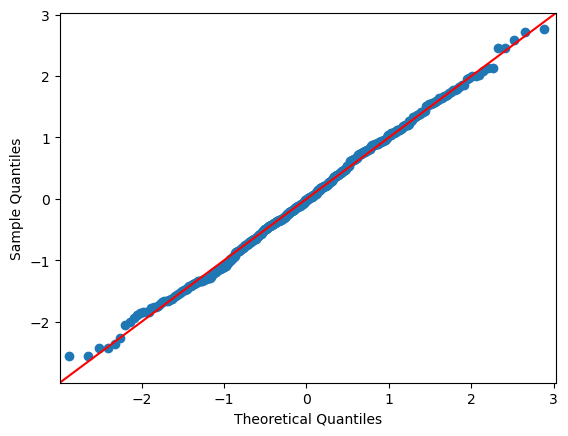

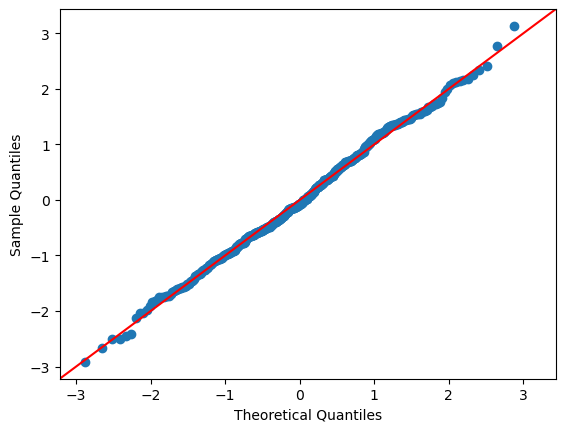

In [462]:
pc_ana('hC_df_6')

In [463]:
kw('hC_df_6')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


    [0.3, 0.1, 0.3, 0.3],     # num=7

In [464]:
pc_combine_data(500,'hC_df_7',7) 

In [465]:
data_C['hC_df_7'].describe()

GVWY        SHVR         ZIC         ZIP
count  500.000000  500.000000  500.000000  500.000000
mean   272.546500  302.155833  312.622167  315.769000
std    151.697607   92.205708   89.696216   92.810144
min      6.500000   60.583333   77.916667   88.916667
25%    162.000000  237.645833  245.729167  251.895833
50%    270.875000  302.166667  313.583333  310.041667
75%    364.750000  365.291667  376.791667  379.354167
max    752.000000  569.083333  584.500000  615.916667

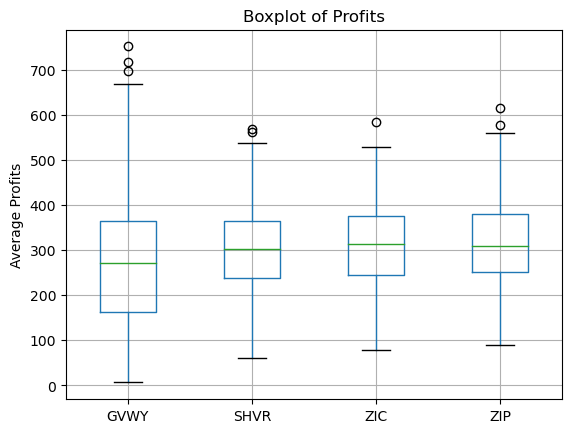

strategy GVWY. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.67). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.20). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.43). Therefore, data is normally distributed.


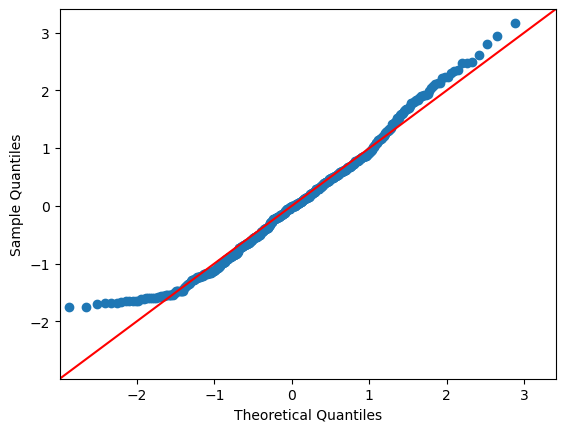

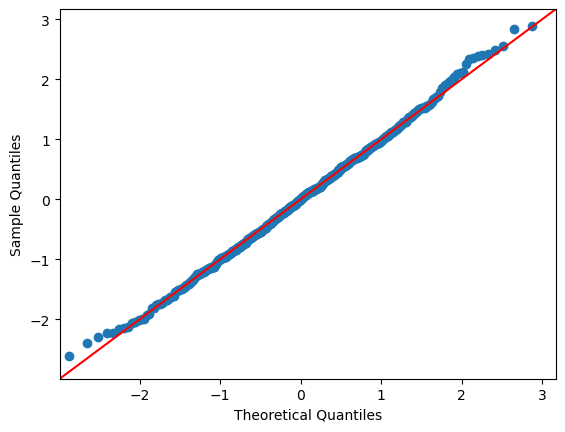

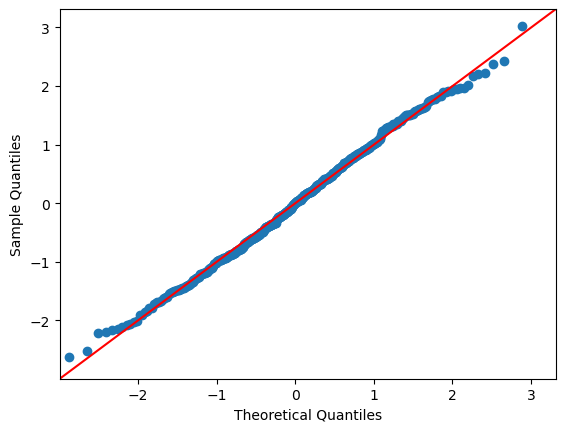

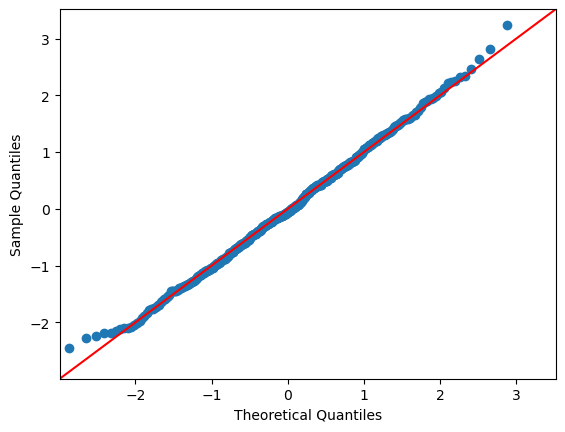

In [466]:
pc_ana('hC_df_7')

In [467]:
kw('hC_df_7')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


    [0.3, 0.3, 0.1, 0.3],     # num=8

In [468]:
pc_combine_data(500,'hC_df_8',8) 

In [469]:
data_C['hC_df_8'].describe()

GVWY        SHVR         ZIC         ZIP
count  500.000000  500.000000  500.000000  500.000000
mean   292.682667  292.459333  339.157000  323.804000
std     84.333887   94.179221  173.435772   94.159536
min     66.916667   59.250000    0.750000   34.666667
25%    238.208333  227.104167  209.750000  256.083334
50%    290.333333  292.875000  345.750000  320.875000
75%    347.479167  353.916667  451.875000  385.750000
max    574.416667  609.500000  776.500000  578.666667

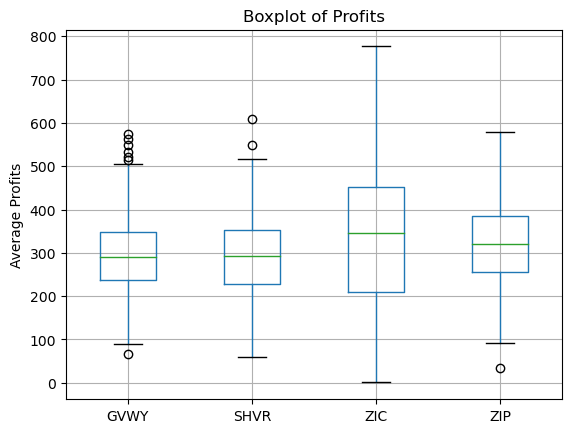

strategy GVWY. We cannot reject the null hypothesis (p=0.11). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.31). Therefore, data is normally distributed.
strategy ZIC. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.66). Therefore, data is normally distributed.


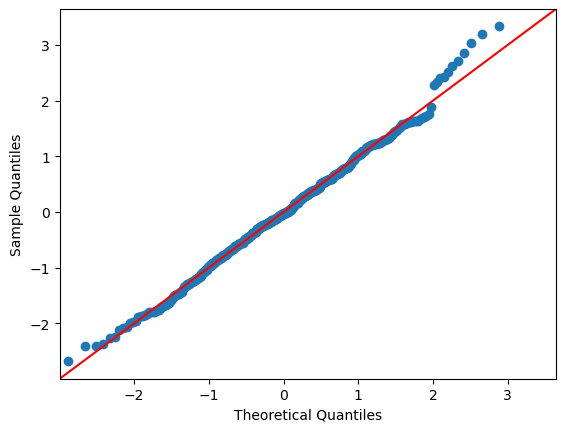

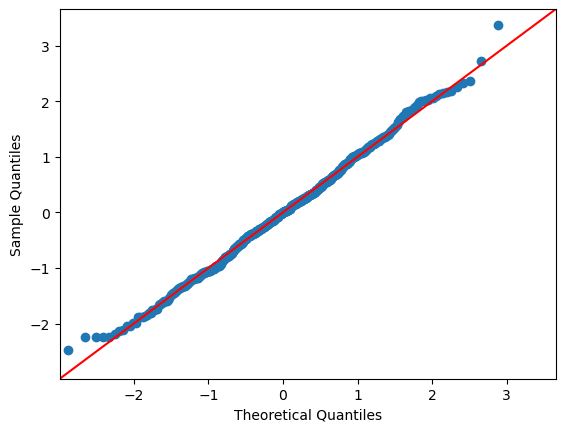

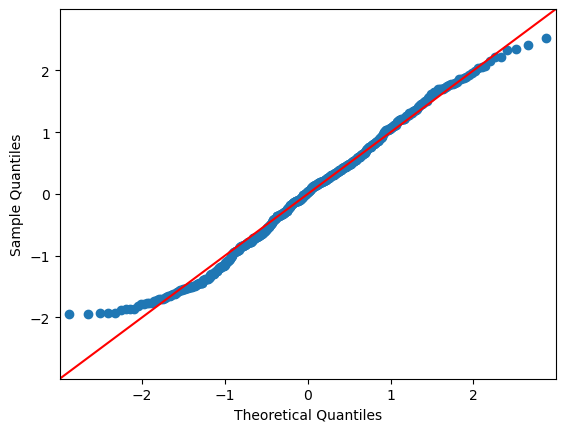

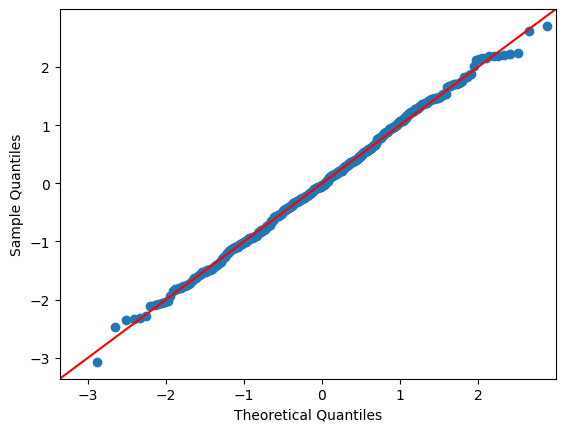

In [470]:
pc_ana('hC_df_8')

In [471]:
kw('hC_df_8')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


    [0.3, 0.3, 0.3, 0.1],     # num=9


In [472]:
pc_combine_data(500,'hC_df_9',9) 

In [473]:
data_C['hC_df_9'].describe()

GVWY        SHVR         ZIC        ZIP
count  500.000000  500.000000  500.000000  500.00000
mean   291.737167  304.000000  322.295833  315.57000
std     84.611317   88.597714   88.320618  179.48717
min     72.583333   80.583333   93.000000    1.00000
25%    231.958333  242.541667  263.645833  166.50000
50%    294.625000  301.583333  320.583333  305.75000
75%    351.416667  362.562500  380.479167  425.43750
max    498.916667  603.500000  570.416667  783.00000

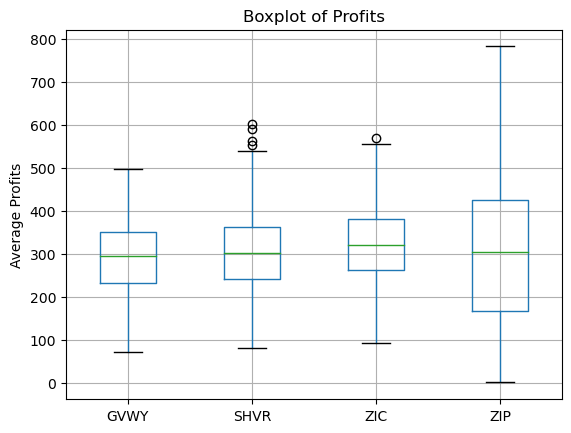

strategy GVWY. We cannot reject the null hypothesis (p=0.20). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.21). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.44). Therefore, data is normally distributed.
strategy ZIP. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.


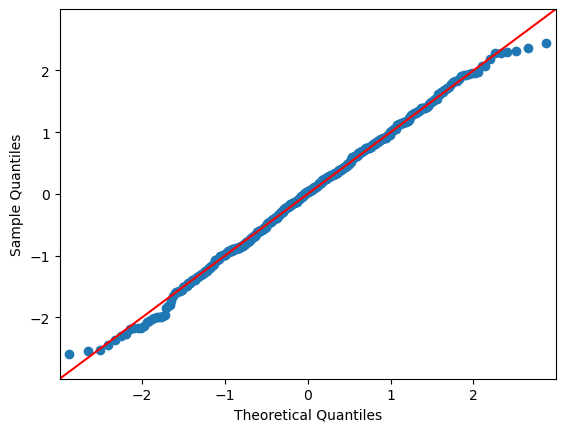

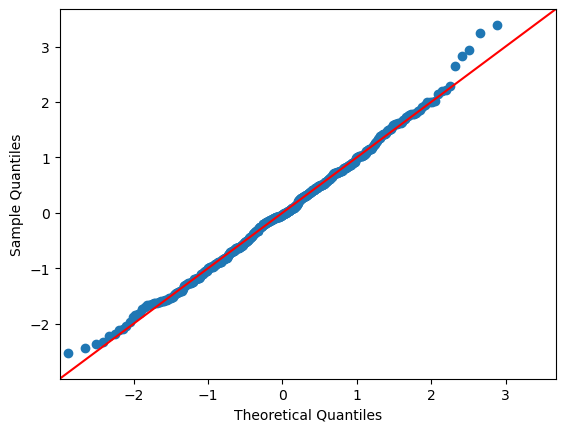

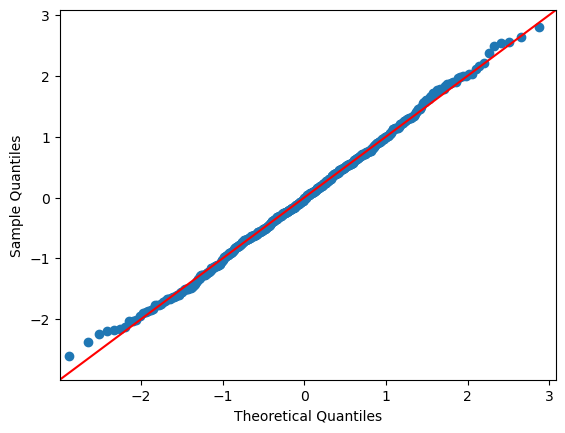

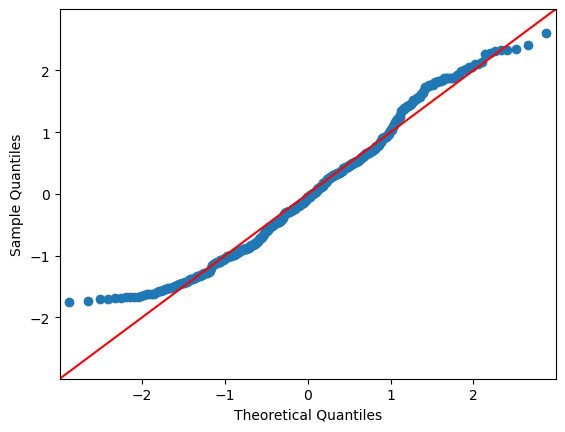

In [474]:
pc_ana('hC_df_9')

In [475]:
kw('hC_df_9')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


    [0.7, 0.1, 0.1, 0.1],     # num=10
  

In [476]:
pc_combine_data(500,'hC_df_10',10) 

In [477]:
data_C['hC_df_10'].describe()

GVWY        SHVR        ZIC         ZIP
count  500.0000  500.000000  500.00000  500.000000
mean   303.7745  291.970429  373.41150  353.356500
std    147.6415   41.560889  170.00731  174.217792
min      0.0000  184.035714   12.25000    0.000000
25%    194.8750  262.625000  249.37500  227.437500
50%    309.3750  290.410714  379.12500  353.000000
75%    401.9375  319.651785  478.68750  458.750000
max    715.2500  421.357143  789.75000  814.500000

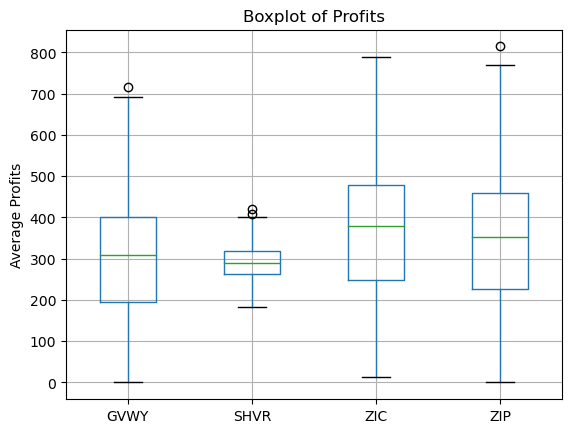

strategy GVWY. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.71). Therefore, data is normally distributed.
strategy ZIC. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIP. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.


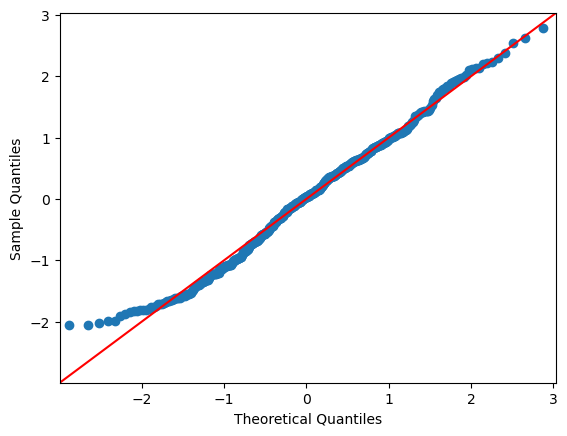

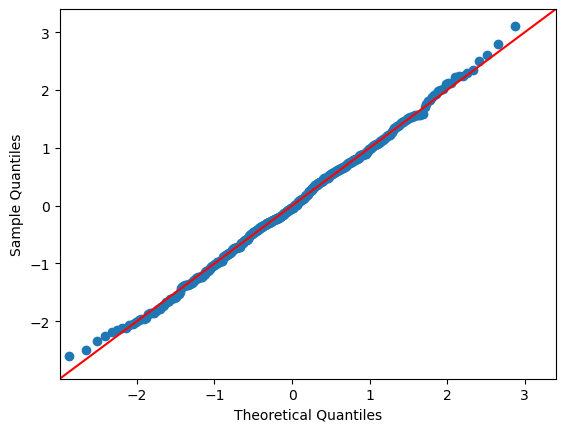

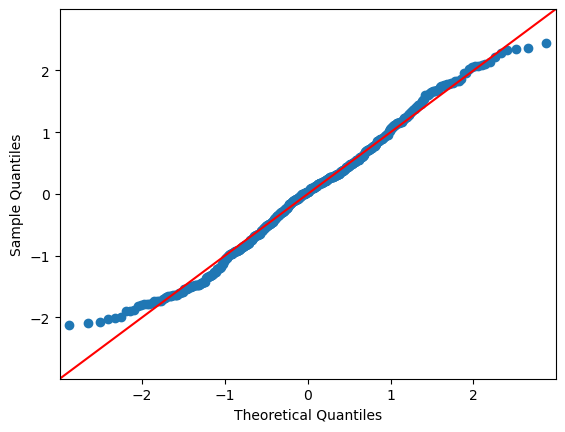

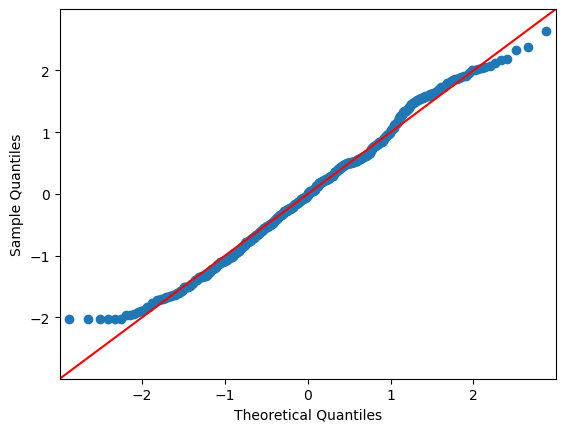

In [478]:
pc_ana('hC_df_10')

In [479]:
kw('hC_df_10')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


[0.1, 0.7, 0.1, 0.1],     # num=11

In [480]:
pc_combine_data(500,'hC_df_11',11) 

In [481]:
data_C['hC_df_11'].describe()

GVWY        SHVR         ZIC         ZIP
count  500.000000  500.000000  500.000000  500.000000
mean   298.587929  286.277000  366.962500  325.265000
std     38.372207  177.934222  181.834122  185.023056
min    188.107143    0.000000    2.250000    0.000000
25%    272.937500  148.500000  227.812500  186.187500
50%    299.642857  281.125000  371.500000  325.375000
75%    325.785715  398.500000  486.250000  444.875000
max    402.428571  796.500000  848.500000  768.500000

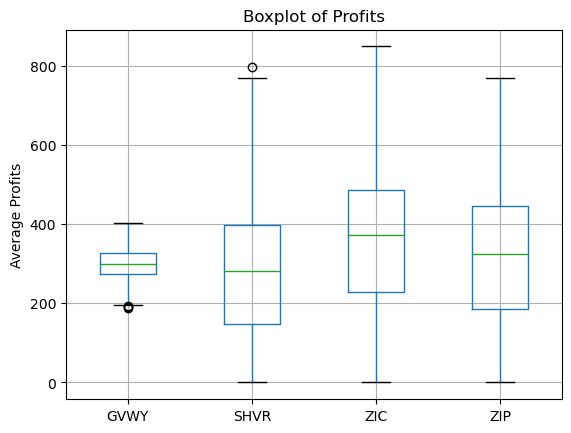

strategy GVWY. We cannot reject the null hypothesis (p=0.72). Therefore, data is normally distributed.
strategy SHVR. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIC. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIP. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.


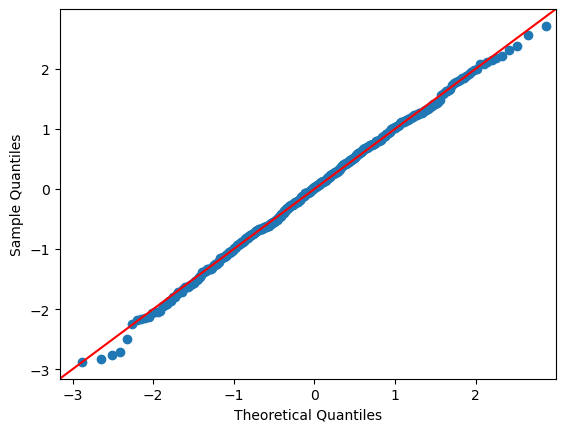

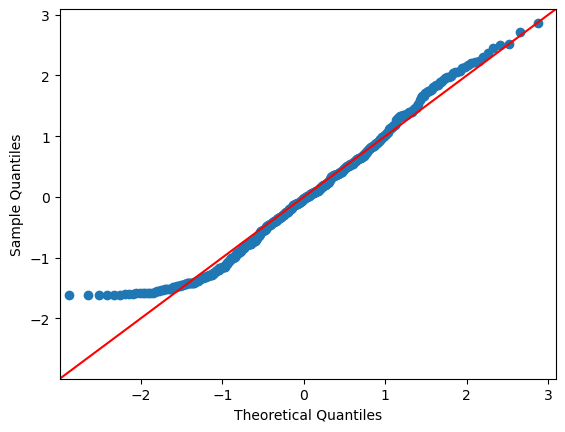

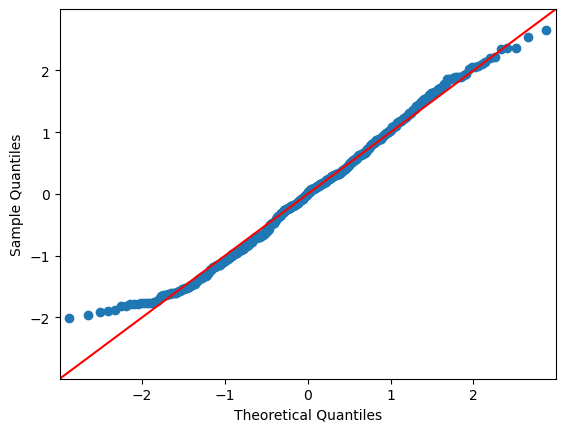

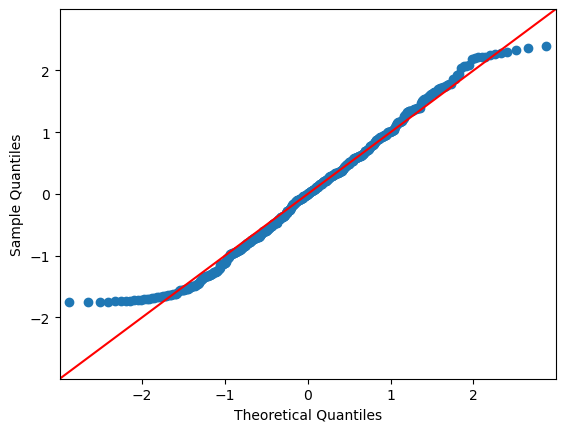

In [482]:
pc_ana('hC_df_11')

In [483]:
kw('hC_df_11')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


    [0.1, 0.1, 0.7, 0.1],     # num=12


In [484]:
pc_combine_data(500,'hC_df_12',12) 

In [485]:
data_C['hC_df_12'].describe()

GVWY        SHVR         ZIC         ZIP
count  500.00000  500.000000  500.000000  500.000000
mean   251.77350  332.434500  310.633429  300.272000
std    161.81969  176.301156   35.646579  162.430889
min      0.50000   23.500000  215.500000   10.500000
25%    118.37500  196.375000  287.642857  165.562500
50%    244.75000  328.125000  311.267857  307.875000
75%    363.75000  443.500000  335.607143  407.687500
max    735.50000  764.250000  401.964286  712.500000

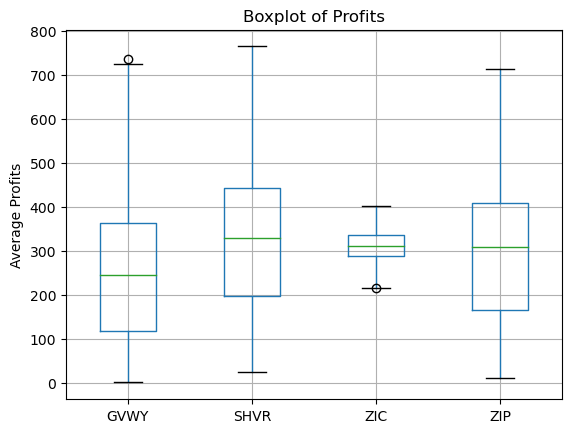

strategy GVWY. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy SHVR. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.18). Therefore, data is normally distributed.
strategy ZIP. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.


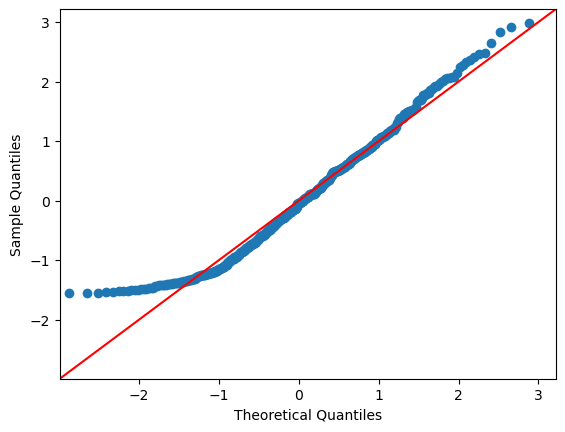

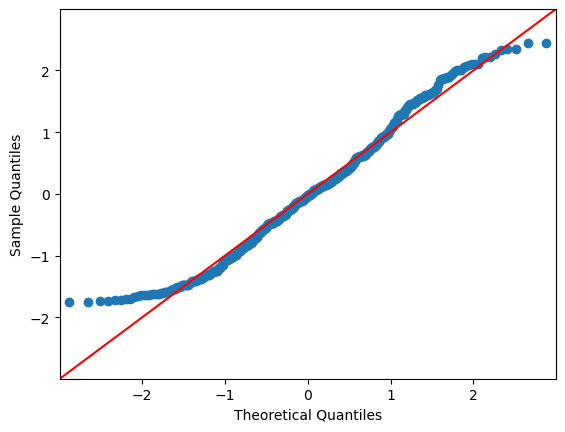

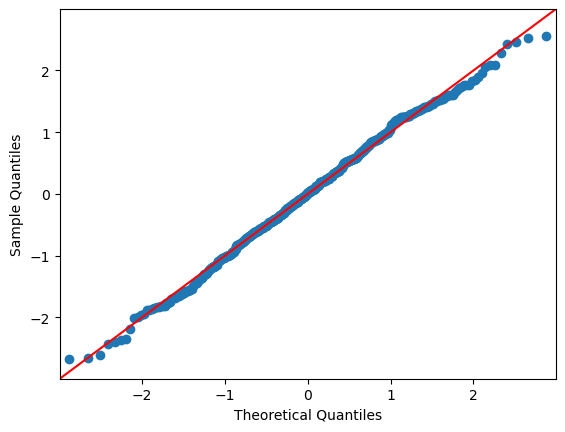

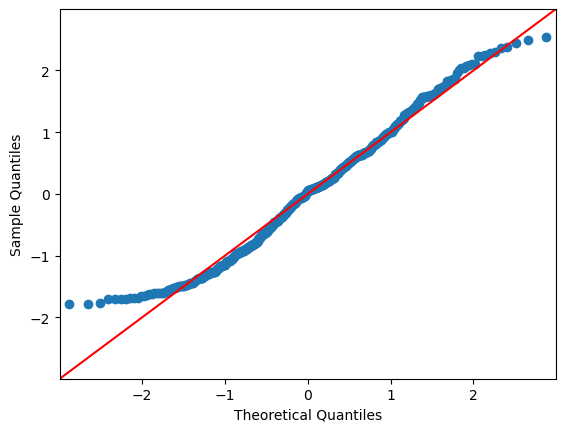

In [486]:
pc_ana('hC_df_12')

In [487]:
kw('hC_df_12')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


    [0.1, 0.1, 0.1, 0.7]      # num=13

In [488]:
pc_combine_data(500,'hC_df_13',13) 

In [489]:
data_C['hC_df_13'].describe()

GVWY        SHVR         ZIC         ZIP
count  500.000000  500.000000  500.000000  500.000000
mean   265.844500  293.742500  323.416500  306.334429
std    159.901219  181.789431  179.271972   38.756316
min      1.250000   11.500000    0.750000  183.821429
25%    140.500000  153.062500  185.875000  280.160715
50%    253.375000  276.000000  312.500000  306.875000
75%    367.625000  406.000000  442.812500  335.348215
max    766.750000  779.000000  763.500000  399.750000

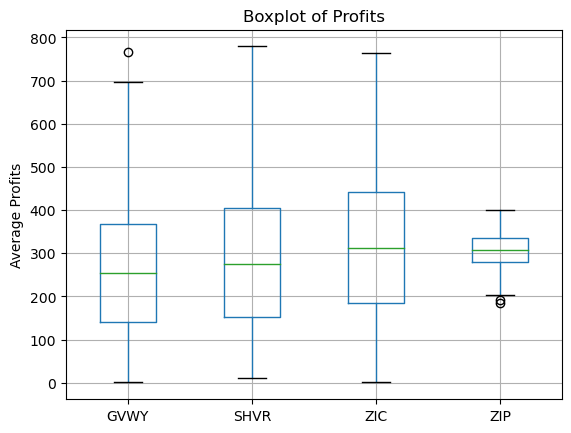

strategy GVWY. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy SHVR. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIC. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIP. We can reject the null hypothesis (p=0.01). Therefore, data is not normally distributed.


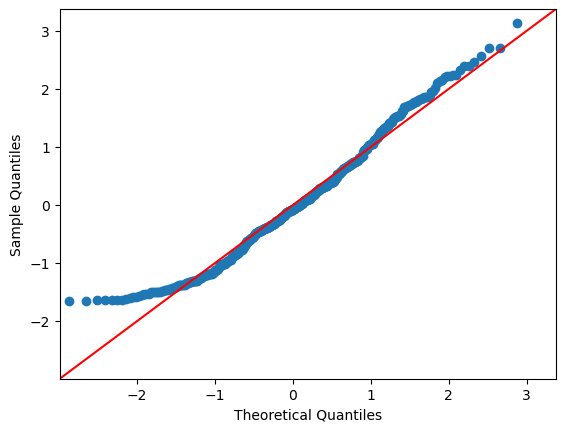

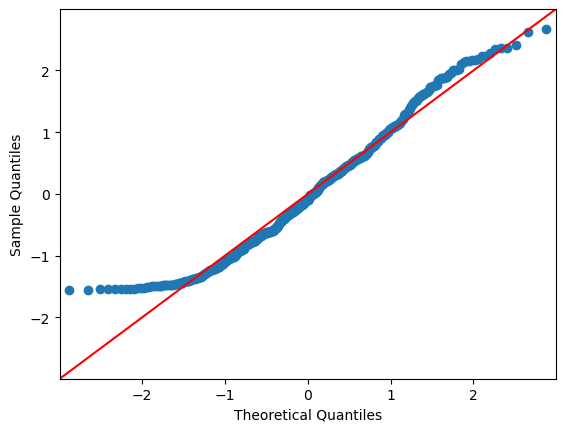

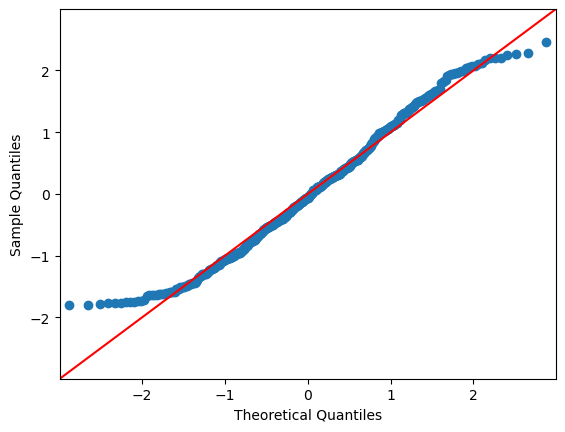

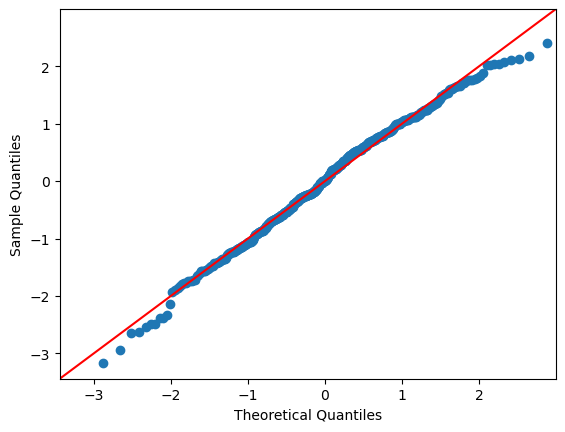

In [490]:
pc_ana('hC_df_13')

In [491]:
kw('hC_df_13')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.     so there is significant difference in profits


partD: 
D.1.

In [492]:
from BSE import *

def D_run_Vernon(N=10,trial_number=0): # “trial_number=0” means the first time of experiments for the entire 30 days
    start_time=0
    day=30
    end_time=60*60*24*day
    # set up supply and demand curves
    supply=(50,75)
    demand=(150, 125)

    supply_schedule=[{'from': start_time, 'to': end_time, 'ranges': [supply], 'stepmode': 'fixed'}]
    demand_schedule=[{'from': start_time, 'to': end_time, 'ranges': [demand], 'stepmode': 'fixed'}]
    order_interval=15   # change order_interval to a smaller number to reduce unnecessary time of expirement
    # change the 'timemode' into 'drip-poisson' which will be more suitable for real world
    order_sched={'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'drip-poisson'}

    # set up traders
    num_of_traders=10
    ZIPSH_num=int(1)
    ZIC_num=num_of_traders-ZIPSH_num
    
    buyers_spec=[('ZIPSH', 1, {'k': 4 ,'optimizer':'ZIPSH'}),('ZIC', ZIC_num)] 
    sellers_spec=[('ZIC', 10)]
    traders_spec={'sellers': sellers_spec, 'buyers': buyers_spec}

    # we need 'dump_strats',so set it "True"
    dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': True, 'dump_avgbals': False, 'dump_tape': False}

    # run N trials
    for i in range(N):
        trial_id=f'D_{trial_number+1}_{i}'  # use the beginning 'D' to have a difference with previous files
        verbose = False
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)



In [493]:
# use a loop to generate 9 times of experiments
for t in range(9):
    D_run_Vernon(N=10,trial_number=t)



After generating the data, we can draw the figures to check the trend of ZIPSH.

Figure 1: profitability of a sole ZIPSH buyer in a market populated by ZIC traders. Horizontal axis is
time, labelled in days; vertical axis is the profit-per-second (PPS) generated by the ZIPSH trader.

In [529]:
# create a draw_pps function to draw the Figure 1
import glob
import pandas as pd
import matplotlib.pyplot as plt
def draw_pps(N=10,trial_number=0):
    D_folder_path = '/Users/guzhemeimao/Downloads/' 
    for n in range(N):
        D_file_paths = glob.glob(D_folder_path + f'D_{trial_number+1}_{n}_strats.csv')
        for D_file_path in  D_file_paths:    
            D_df1 = pd.read_csv(D_file_path)
    plt.ylim([0.0,3.0])   # use the code to set a fixed range of value of y axis
    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days 
    D_pps_Y=D_df1.iloc[:,19]
    # draw a scatter plot
    plt.scatter(D_day_X,D_pps_Y)

    plt.show



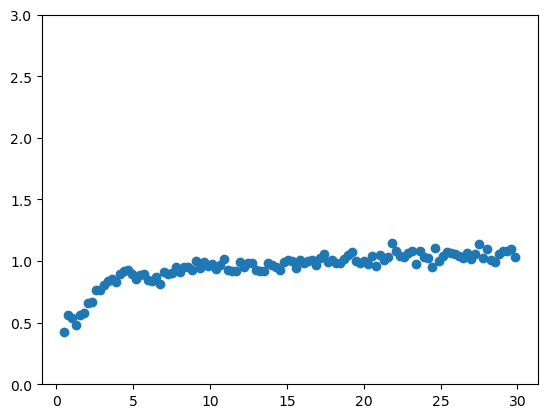

In [530]:
# invoke the function
draw_pps(trial_number=3)

As can be seen in Figure 1, there is indeed a clear improvement in profitability, which
rises from a PPS of roughly 0.5 at Day 0 to a PPS near 1.0 at Day 30, an increase of roughly 200%
in this experiment. 
It seems that the figure 1 shows that ZIPSH has an improvement in profitability.

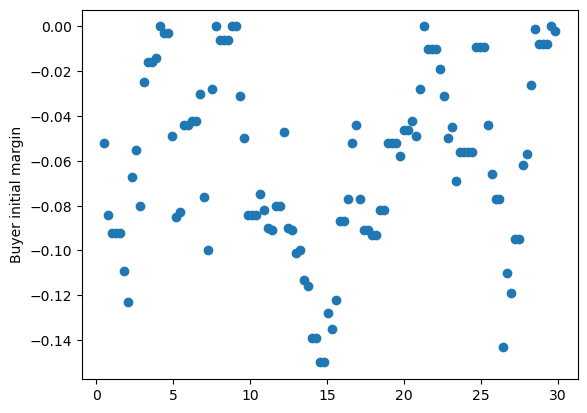

In [531]:
# create functions to draw the Figure 2
trial_number=3
N=10
D_folder_path = '/Users/guzhemeimao/Downloads/' 
for n in range(N):
    D_file_paths = glob.glob(D_folder_path + f'D_{trial_number+1}_{n}_strats.csv')
    for D_file_path in  D_file_paths:    
        D_df1 = pd.read_csv(D_file_path)
def draw_Figure2_1():
   
    # draw Buyer initial margin plot
    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days  
    D_buyer_Y=D_df1.iloc[:,7]
    plt.scatter(D_day_X,D_buyer_Y)
    plt.ylabel('Buyer initial margin')
    plt.show
def draw_Figure2_2():
    # draw Beta plot
    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days 
    D_beta_Y=D_df1.iloc[:,11]
    plt.scatter(D_day_X,D_beta_Y)
    plt.ylabel('Beta')
    plt.show
def draw_Figure2_3():
    # draw Momentum plot
    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days 
    D_momen_Y=D_df1.iloc[:,13]
    plt.scatter(D_day_X,D_momen_Y)
    plt.ylabel('Momentum')
    plt.show
def draw_Figure2_4():
    # draw C_a plot

    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days 
    D_ca_Y=D_df1.iloc[:,15]
    plt.scatter(D_day_X,D_ca_Y)
    plt.ylabel('C_a')
    plt.show
def draw_Figure2_5():

    # draw C_r plot
    
    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days 
    D_cr_Y=D_df1.iloc[:,17]
    plt.scatter(D_day_X,D_cr_Y)
    plt.ylabel('C_r')
    plt.show

draw_Figure2_1()


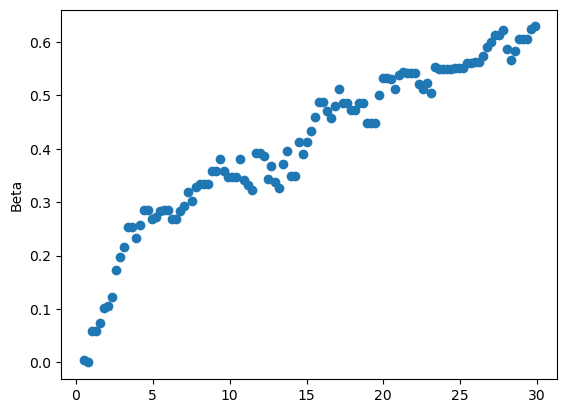

In [532]:
draw_Figure2_2()

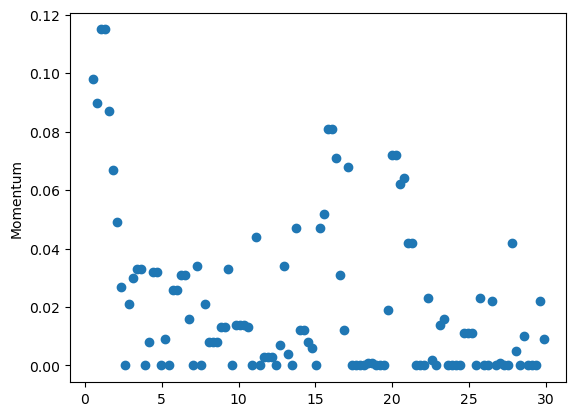

In [533]:
draw_Figure2_3()

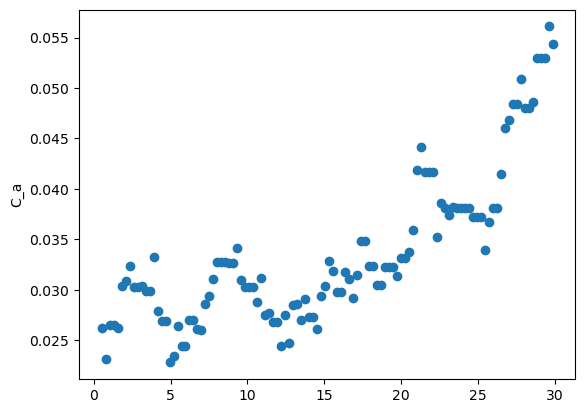

In [534]:
draw_Figure2_4()

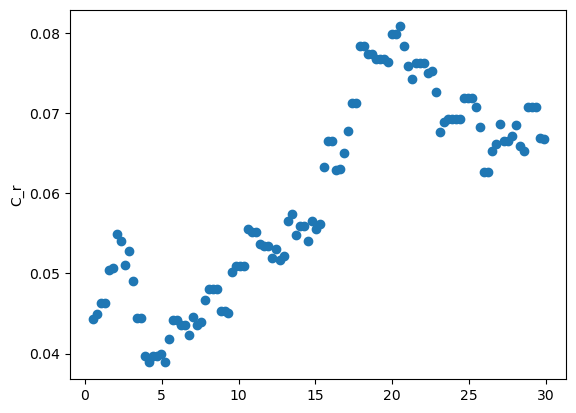

In [535]:
draw_Figure2_5()

Figure 2 shows the changes in the ZIPSH trader’s hyperparameter values over the duration of the
same experiment.
We can see each of the hyperparameters is gradually altered to get a higher profitability.

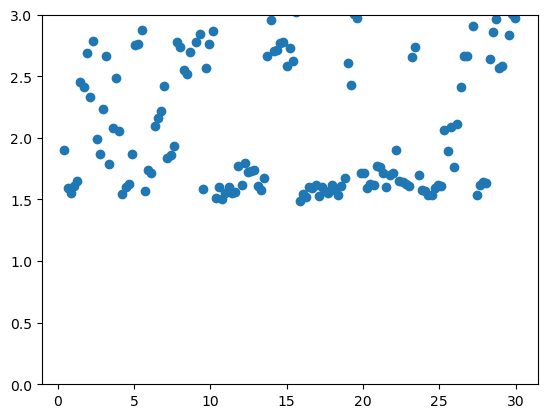

In [536]:
# invoke the function
draw_pps(trial_number=0)

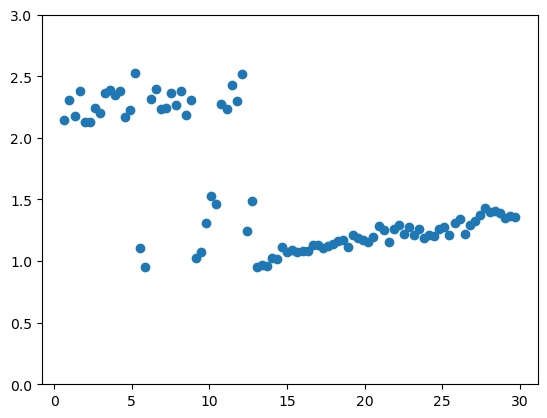

In [537]:
draw_pps(trial_number=1)

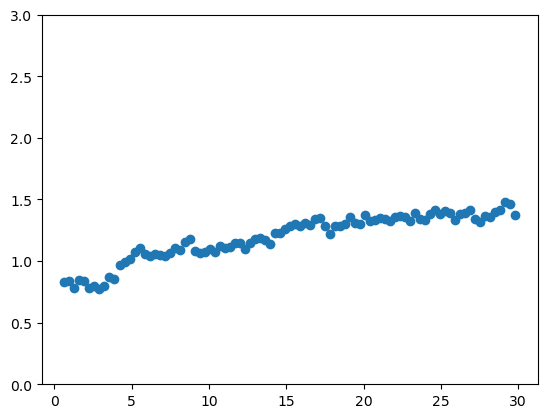

In [538]:
draw_pps(trial_number=2)

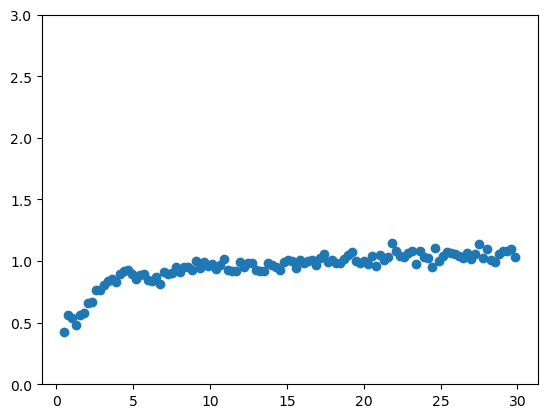

In [539]:
draw_pps(trial_number=3)

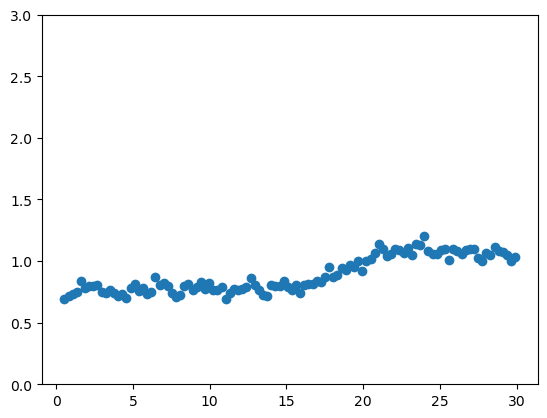

In [540]:
draw_pps(trial_number=4)

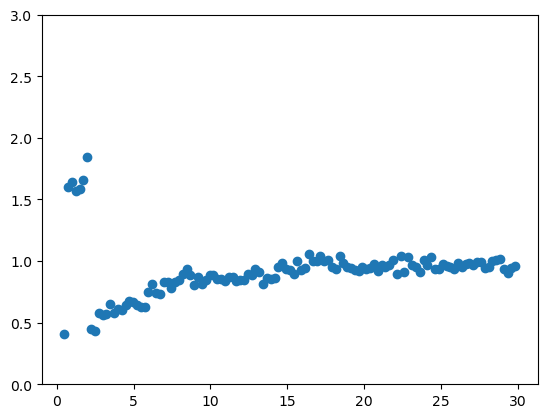

In [541]:
draw_pps(trial_number=5)

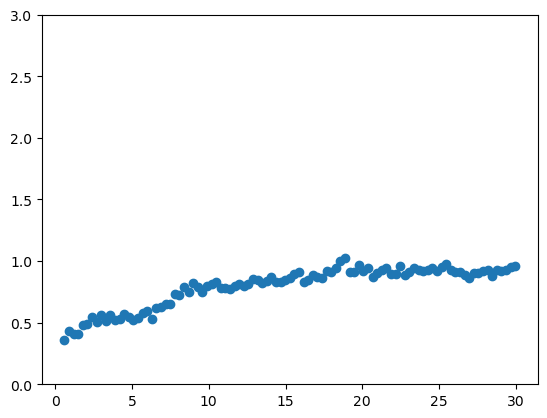

In [542]:
draw_pps(trial_number=6)

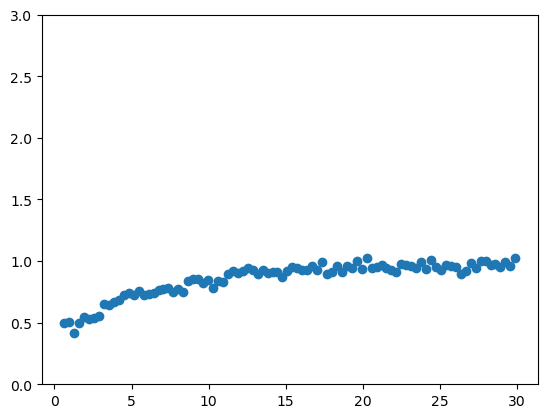

In [543]:
draw_pps(trial_number=7)

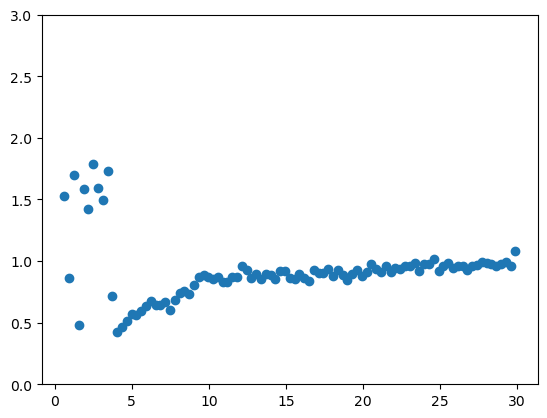

In [544]:
draw_pps(trial_number=8)

Then, I will make some changes to the experimental metrics after replicating the experiments.
1. The sample of 10 is too small to prove, I want to change the 'N=10' to 'N=40', as a larger sample size can not only reduce the impact of outliers of the ZIPSH strategy but also reduce the impact of noise level in the profitability scores.
2. I will alter the init_stratwaittime() function to give each strategy less evaluation time, which will increase the number of adaptive steps per day. I change the value of return to '3600+random.randint(0, 3600)'. In this way, we can use the limit of 30 days of simulation to see more obvious performance. Although it will increase the noise level, the option of 'N=40' will reduce the impact, so I think it is reasonable.
3. Under the change of '1' and '2', I think 30 days is enough for us.

In [545]:
D_run_Vernon(N=40,trial_number=9)

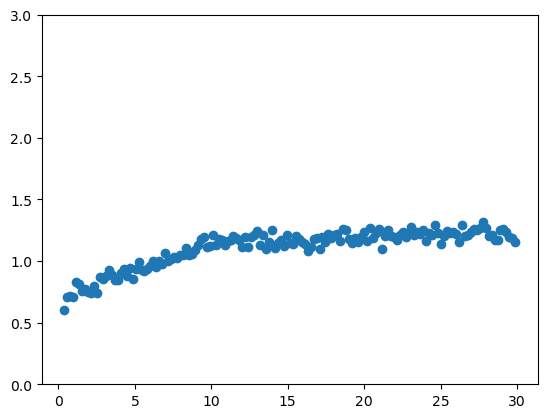

In [547]:
draw_pps(N=40,trial_number=9)

After altering the metric, the figure shows that the PPS of roughly 0.5 on Day 0 increases to nearly 1.4 on Day 30, which is an increase of roughly 280%.
In my opinion, the data is reliable and we can prove that the SH mechanism has made ZIP better suited to trading in the market full of ZIC traders with the special shape of supply and demand curves.

D.2.
In the auction market, supply and demand curves are very important. 
They reflect the behaviors of traders. 
Generally speaking, to get more profits, we need to choose our strategies depending on the shape of supply and demand curves.
After observing the performance of ZIPSH in one shape of supply and demand curves, I would like to explore all the scenarios and observe if there is one shape of supply and demand curves that is the most suitable one for implementing the ZIPSH strategy.

In [548]:
from BSE import *
# s1 is the initial value of the supply curve and s2 is the end value
# d1 is the initial value of the demand curve and d2 is the end value   
def D2_run_Vernon(N=10,new_name=None,s1=50,s2=75,d1=150,d2=125): # use new_name to change the name of data file
    start_time=0
    day=30
    end_time=60*60*24*day
    # change the shape of supply and demand curves to explore 
    # Set up a completely elastic demand curve
    supply=(s1,s2)
    demand=(d1,d2)
   
    supply_schedule=[{'from': start_time, 'to': end_time, 'ranges': [supply], 'stepmode': 'fixed'}]
    demand_schedule=[{'from': start_time, 'to': end_time, 'ranges': [demand], 'stepmode': 'fixed'}]
    order_interval=15   

    order_sched={'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'drip-poisson'}

  
    num_of_traders=10
    ZIPSH_num=int(1)
    ZIC_num=num_of_traders-ZIPSH_num
    
    buyers_spec=[('ZIPSH', 1, {'k': 4 ,'optimizer':'ZIPSH'}),('ZIC', ZIC_num)] 
    sellers_spec=[('ZIC', 10)]
    traders_spec={'sellers': sellers_spec, 'buyers': buyers_spec}


    dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': True, 'dump_avgbals': False, 'dump_tape': False}


    for i in range(N):
        trial_id=f'D2_{new_name}_{i}'  # change the id to make the data file name clear
        verbose = False
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)



In [549]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
def D2_draw_pps(N=10,new_name='com_ela_d'):
    D2_folder_path = '/Users/guzhemeimao/Downloads/' 
    for n in range(N):
        D2_file_paths = glob.glob(D2_folder_path + f'D2_{new_name}_{n}_strats.csv')
        for D2_file_path in  D2_file_paths:    
            D2_df1 = pd.read_csv(D2_file_path)
    
    D2_time_X=D2_df1.iloc[:,1] # it is measured in seconds
    D2_day_X=D2_time_X/86400  # it is measured in days 
    D2_pps_Y=D2_df1.iloc[:,19]
    # draw a scatter plot
    plt.scatter(D2_day_X,D2_pps_Y)

    plt.show()



1. Completely elastic demand curve and standard supply curve

In [610]:
D2_run_Vernon(N=10,new_name='com_ela_d',d1=310,d2=310)

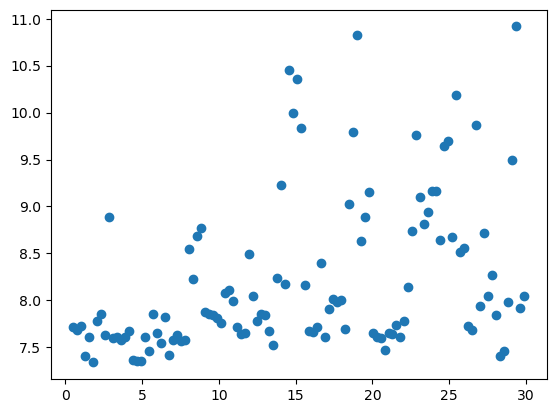

In [611]:
D2_draw_pps(N=10,new_name='com_ela_d')

Under a completely elastic demand curve and standard supply curve, small price changes can cause a big change in demand. 
We can see in the figure that the ZIPSH does not perform well. The pps do not show a trend over time.
Maybe it is because the strategy can not be able to adapt to the market conditions quickly. 

2. Steeper supply curve and standard demand curve

In [5]:
D2_run_Vernon(N=10,new_name='com_ste_s',s1=1,s2=500)

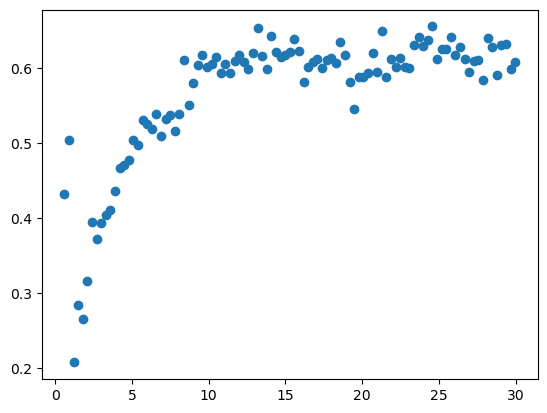

In [304]:
D2_draw_pps(N=10,new_name='com_ste_s')

The figure shows a distinct increase in pps over time. On day 0, the pps is about 0.2, and on day 30, the pps is about0.7, an increase of roughly 350%.
We know that ZIPSH is suitable for the market with a steeper supply curve and standard demand curve.

3. Steeper supply curve and completely elastic demand curve

In [7]:
D2_run_Vernon(N=10,new_name='com_ste_s_ela_d',s1=1,s2=500,d1=310,d2=310)

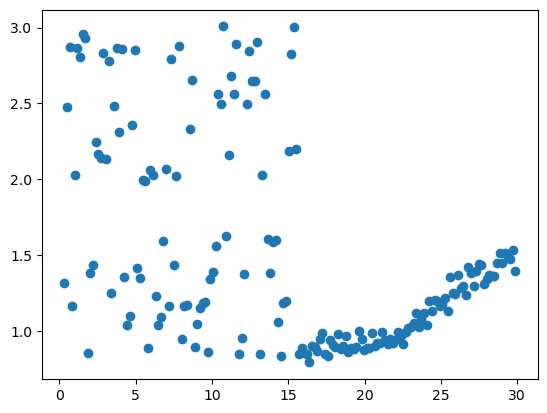

In [17]:
D2_draw_pps(N=10,new_name='com_ste_s_ela_d')

It seems that the pps have a decreasing trend over time from day 0 to day 15, while, from day 15 to day 30, the pps have an increasing trend over time. 
So, to explore more useful information, we need to set a new trail with a time longer than 30 days.

4. Steeper demand curve and standard supply curve 

In [11]:
D2_run_Vernon(N=10,new_name='com_in_d',d1=1,d2=500)

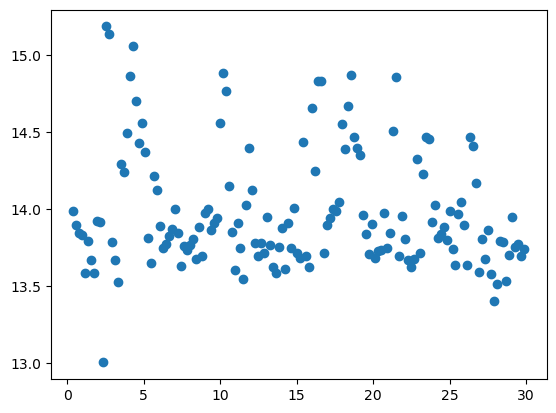

In [19]:
D2_draw_pps(N=10,new_name='com_in_d')

Under a steeper demand curve and standard supply curve, this means that changes in prices do not significantly affect demand.  
We can see in the figure that the ZIPSH does not perform well. The pps do not show a trend over time.
This may be because even if ZIPSH can find better parameters, the change in trading order may be limited, so it can not be visualized in such an extreme market situation.

5. Completely inelastic supply curve and standard demand curve 

In [9]:
D2_run_Vernon(N=10,new_name='com_in_s',s1=310,s2=310)

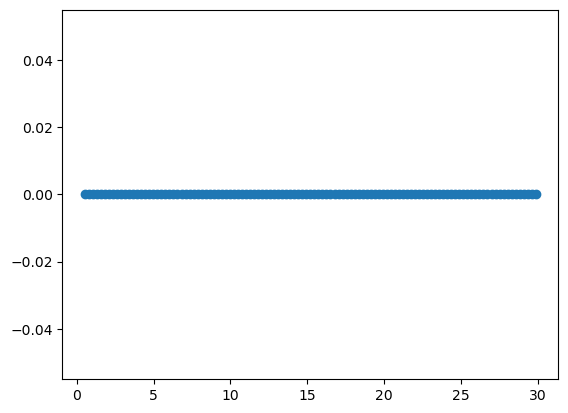

In [307]:
D2_draw_pps(N=10,new_name='com_in_s')

6. Steeper demand curve and completely inelastic supply curve 

In [305]:
D2_run_Vernon(N=10,new_name='com_ste_d_in_s',s1=310,s2=310,d1=1,d2=500)

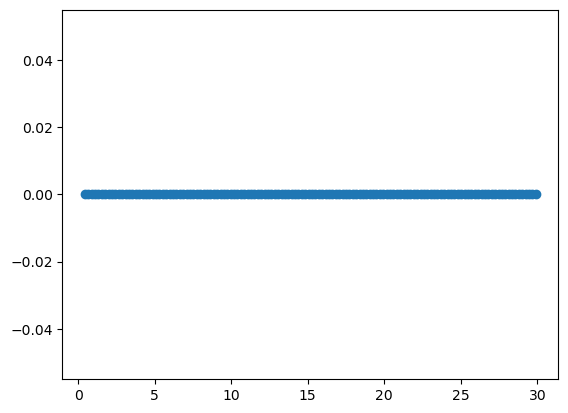

In [306]:
D2_draw_pps(N=10,new_name='com_ste_d_in_s')

The situation of 5 and 6 have the same figures which show that ZIPSH can not gain any profit in the market.
In such a market, price can not influence the supply, so the completely inelastic supply curve makes it impossible for all traders to gain profit.

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT. 

In [673]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

In [674]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "CW-INFT-2475879.ipynb" # Enter name of this file here
printWordCount(this_file_name)

Word count: 1958. Limit is 2000 words.
